In [1]:
import numpy as np
import pandas as pd
import itertools
#from tqdm import tqdm
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
plt.style.use("default")
import re
import requests
from bs4 import BeautifulSoup
# For reproducibility
np.random.seed(42)


In [35]:
# ------------------------------
# Universe from daily screener output (etf_screened_today.csv)
# ------------------------------
from pathlib import Path
repo_root = Path.cwd().parent

config_dir = repo_root / "data"
config_dir.mkdir(parents=True, exist_ok=True)

_screen_path = config_dir / "etf_screened_today.csv"

screen_df = pd.read_csv(_screen_path)

if "include_for_algo" not in screen_df.columns:
    raise ValueError(f"Screener CSV missing include_for_algo column: {_screen_path}")

screen_pass = screen_df[screen_df["include_for_algo"] == True].copy()

# Normalize tickers
for col in ["ETF", "Underlying"]:
    if col in screen_pass.columns:
        screen_pass[col] = (
            screen_pass[col].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()
        )

if "Underlying" not in screen_pass.columns or "ETF" not in screen_pass.columns:
    raise ValueError(f"Screener CSV must contain ETF + Underlying columns: {_screen_path}")

print(f"Screener path: {_screen_path}")



Screener path: c:\Users\werdn\Documents\Investing\ls-algo\data\etf_screened_today.csv


In [36]:
import ftplib

ftp = ftplib.FTP("ftp2.interactivebrokers.com")
ftp.login(user="shortstock", passwd="")  # password is blank / anonymous

files = ftp.nlst()
print(files)

ftp.quit()


['australia.txt', 'australia.txt.md5', 'austria.txt', 'austria.txt.md5', 'belgium.txt', 'belgium.txt.md5', 'british.txt', 'british.txt.md5', 'canada.txt', 'canada.txt.md5', 'dutch.txt', 'dutch.txt.md5', 'france.txt', 'france.txt.md5', 'germany.txt', 'germany.txt.md5', 'hongkong.txt', 'hongkong.txt.md5', 'india.txt', 'india.txt.md5', 'italy.txt', 'italy.txt.md5', 'japan.txt', 'japan.txt.md5', 'mexico.txt', 'mexico.txt.md5', 'singapore.txt', 'singapore.txt.md5', 'spain.txt', 'spain.txt.md5', 'stockmargin_final_dtls.IB-AU.dat', 'stockmargin_final_dtls.IB-AU.dat.md5', 'stockmargin_final_dtls.IB-CAN.dat', 'stockmargin_final_dtls.IB-CAN.dat.md5', 'stockmargin_final_dtls.IB-HK.dat', 'stockmargin_final_dtls.IB-HK.dat.md5', 'stockmargin_final_dtls.IB-IN.dat', 'stockmargin_final_dtls.IB-IN.dat.md5', 'stockmargin_final_dtls.IB-JP.dat', 'stockmargin_final_dtls.IB-JP.dat.md5', 'stockmargin_final_dtls.IB-SG.dat', 'stockmargin_final_dtls.IB-SG.dat.md5', 'stockmargin_final_dtls.IB-UKL.dat', 'stockmarg

'221 Goodbye.'

In [37]:
import ftplib
import io

def fetch_ibkr_shortstock_file(filename="usa.txt") -> pd.DataFrame:
    ftp = ftplib.FTP("ftp2.interactivebrokers.com")
    ftp.login(user="shortstock", passwd="")

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    # Find the header line that starts with #SYM|
    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#SYM|"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_line = lines[header_idx]
    data_lines = lines[header_idx + 1:]

    # Build column names from header
    header_cols = [c.strip().lstrip("#").lower() for c in header_line.split("|")]

    # Join data lines back to a CSV-like string
    data_str = "\n".join(data_lines)
    data_buf = io.StringIO(data_str)

    # Read data; allow Python engine for safety
    df = pd.read_csv(
        data_buf,
        sep="|",
        header=None,
        engine="python"
    )

    # Trim / align columns
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]

    # Drop any empty / unnamed trailing columns
    df = df.drop(columns=[c for c in df.columns if not c or str(c).startswith("unnamed")], errors="ignore")

    return df


In [38]:
short_df = fetch_ibkr_shortstock_file("usa.txt")
short_df.head()


sym  cur                          name          con          isin  \
0     A  USD      AGILENT TECHNOLOGIES INC    1715006.0  XXXXXXXU1016   
1    AA  USD                    ALCOA CORP  251962528.0  XXXXXXX21065   
2   AAA  USD  ALTERNATIVE ACCESS FIRST PRI  591368776.0  XXXXXXXX6105   
3  AAAA  USD  AMPLIUS AGGRESSIVE A ALL ETF  799151665.0  XXXXXXXQ6897   
4  AAAC  USD          COLUMBIA AAA CLO ETF  837910779.0  XXXXXXXL7635   

   rebaterate  feerate available          figi  
0      3.3900   0.2500   5100000  BBG000C2V3D6  
1      3.2319   0.4081   5900000  BBG00B3T3HD3  
2     -1.7260   5.3660      9000  BBG01B0JRCS6  
3    -70.0897  73.7297     90000  BBG01W275XX6  
4         NaN      NaN       100  BBG01YZNRVY0

In [39]:
short_df.columns

Index(['sym', 'cur', 'name', 'con', 'isin', 'rebaterate', 'feerate',
       'available', 'figi'],
      dtype='object')

In [40]:
import numpy as np

def build_ibkr_short_maps(
    filename="usa.txt",
    default_borrow=0.05,   # 5% if not found
    default_rebate=0.0
):
    """
    Use IBKR's public shortstock FTP file to build:
      - net borrow rate map (fee - rebate)
      - rebate rate map
      - available-shares map

    All rates returned as decimals (e.g. 0.12 = 12% per year).
    """

    short_df = fetch_ibkr_shortstock_file(filename)

    # Clean / normalize columns
    short_df["sym"] = short_df["sym"].astype(str).str.upper().str.strip()

    # Some files are in percent (e.g. 3.6300 means 3.63%)
    # Convert to decimals
    short_df["rebate_annual"] = pd.to_numeric(short_df["rebaterate"], errors="coerce") / 100.0
    short_df["fee_annual"]    = pd.to_numeric(short_df["feerate"],    errors="coerce") / 100.0
    short_df["available_int"] = pd.to_numeric(short_df["available"],  errors="coerce")

    # Net borrow cost to you ≈ fee - rebate.
    # If this goes negative (i.e. you actually earn carry),
    # you can either keep it or clip at 0. I'll clip at 0 to be conservative.
    short_df["net_borrow_annual"] = short_df["fee_annual"] - short_df["rebate_annual"]
    short_df["net_borrow_annual"] = short_df["net_borrow_annual"].clip(lower=0)

    # Filter only the symbols we care about
    sub = short_df.copy()

    borrow_map = {}
    rebate_map = {}
    available_map = {}

    for _, row in sub.iterrows():
        sym = row["sym"]
        if pd.notna(row["net_borrow_annual"]):
            borrow_map[sym] = float(row["net_borrow_annual"])
        if pd.notna(row["rebate_annual"]):
            rebate_map[sym] = float(row["rebate_annual"])
        if pd.notna(row["available_int"]):
            available_map[sym] = int(row["available_int"])

    # Defaults for anything missing
    borrow_map["default"] = default_borrow
    rebate_map["default"] = default_rebate

    return borrow_map, rebate_map, available_map


In [41]:
borrow_map, rebate_map, available_map = build_ibkr_short_maps(
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

borrow_map


{'A': 0.0,
 'AA': 0.0,
 'AAA': 0.07092,
 'AAAA': 1.4381939999999998,
 'AAAU': 0.0,
 'AABB': 0.007531999999999999,
 'AABVF': 0.0,
 'AACAY': 0.028810000000000002,
 'AACB': 0.276476,
 'AACBU': 0.0,
 'AACG': 0.050390000000000004,
 'AACIU': 1.04885,
 'AACS': 0.0,
 'AACTF': 0.16681,
 'AADR': 0.087334,
 'AAEQ': 0.0,
 'AAGAF': 0.095794,
 'AAGC': 0.230338,
 'AAGFF': 0.049212,
 'AAGIY': 0.0,
 'AAGR': 0.299342,
 'AAIRF': 0.125654,
 'AAL': 0.0,
 'AALG': 0.236618,
 'AAME': 0.023505999999999996,
 'AAMI': 0.0,
 'AAMMF': 0.125108,
 'AAMTF': 0.0,
 'AAMUQ': 0.0,
 'AAOI': 0.0,
 'AAON': 0.0,
 'AAP': 0.0,
 'AAPB': 0.00511,
 'AAPD': 0.050432,
 'AAPG': 0.7018899999999999,
 'AAPI': 0.0,
 'AAPJ': 0.0,
 'AAPL': 0.0,
 'AAPR': 0.02198,
 'AAPT': 0.0,
 'AAPU': 0.07227599999999999,
 'AAPW': 0.231346,
 'AAPX': 0.15263,
 'AAPY': 0.046391999999999996,
 'AARD': 0.004561999999999997,
 'AASP': 0.0,
 'AAT': 0.0,
 'AATC': 0.067702,
 'AATV': 0.0,
 'AAUAF': 0.0,
 'AAUC': 0.0008339999999999979,
 'AAUGF': 0.07419799999999999,
 

In [42]:
available_map

{'A': 5100000,
 'AA': 5900000,
 'AAA': 9000,
 'AAAA': 90000,
 'AAAC': 100,
 'AAAU': 950000,
 'AABVF': 15000,
 'AACAY': 70000,
 'AACB': 2400000,
 'AACBU': 300,
 'AACG': 350000,
 'AACIU': 90000,
 'AACS': 1700000,
 'AACTF': 150000,
 'AADR': 10000,
 'AAEQ': 60000,
 'AAGAF': 2100000,
 'AAGC': 3100000,
 'AAGFF': 4100000,
 'AAGIY': 300000,
 'AAGR': 300000,
 'AAIRF': 50000,
 'AALG': 600,
 'AAME': 90000,
 'AAMI': 450000,
 'AAMMF': 500000,
 'AAMTF': 20000,
 'AAMUQ': 850000,
 'AAOI': 2300000,
 'AAON': 300000,
 'AAP': 550000,
 'AAPB': 45000,
 'AAPD': 80000,
 'AAPG': 50000,
 'AAPI': 4000,
 'AAPR': 45000,
 'AAPT': 7700000,
 'AAPU': 20000,
 'AAPW': 15000,
 'AAPX': 200,
 'AAPY': 7000,
 'AARD': 900000,
 'AASP': 3000,
 'AAT': 1000000,
 'AATC': 7000,
 'AATV': 35000,
 'AAUAF': 2400000,
 'AAUC': 300000,
 'AAUGF': 85000,
 'AAUM': 100,
 'AAUS': 200000,
 'AAVM': 300000,
 'AAVMY': 50000,
 'AAVVF': 1800000,
 'AAWH': 4700000,
 'AAXJ': 20000,
 'AAXT': 15000,
 'AB': 95000,
 'ABAT': 400000,
 'ABBB': 35000,
 'ABBNY'

In [43]:
def get_rebalance_days(idx: pd.DatetimeIndex, freq: str) -> set[pd.Timestamp]:
    """
    Return a set of pd.Timestamp rebalance days, guaranteed to be:
      - tz-naive
      - elements that appear in idx
      - comparable with loop variable t (which will be from idx)
    """
    if idx.tz is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)

    idx = pd.DatetimeIndex(idx)  # ensure DatetimeIndex
    if len(idx) == 0:
        return set()

    freq = str(freq).upper()

    # Always include the first day so portfolio can initialize when eligible
    days = {pd.Timestamp(idx[0])}

    if freq in ("NEVER",):
        return days

    if freq in ("D", "DAILY"):
        return set(pd.Timestamp(x) for x in idx)

    if freq not in ("W", "M", "Q"):
        raise ValueError("freq must be one of: 'D','W','M','Q','Never'")

    # last trading day in each period
    periods = idx.to_period(freq)
    last_days = (
        pd.Series(idx, index=idx)
        .groupby(periods)
        .apply(lambda s: s.iloc[-1])
        .tolist()
    )

    for d in last_days:
        days.add(pd.Timestamp(d))

    return days


In [44]:
def first_valid_date(rets: pd.DataFrame, sym: str) -> pd.Timestamp | None:
    # prefer _TR if present
    candidates = [f"{sym}_TR", sym]
    for col in candidates:
        if col in rets.columns:
            s = rets[col]
            # valid = non-NA (you can also add: & (s != 0) if you want)
            fv = s.first_valid_index()
            if fv is not None:
                return pd.Timestamp(fv)
    return None

def build_pair_start_dates(rets: pd.DataFrame, pairs: list[tuple[str, str]]):
    """
    pairs are (underlying, etf) in your convention.
    returns dict: {(und, etf): start_date}
    """
    pair_start = {}
    for und, etf in pairs:
        und0 = und.replace(".", "-")
        etf0 = etf.replace(".", "-")

        d1 = first_valid_date(rets, und0)
        d2 = first_valid_date(rets, etf0)

        if d1 is None or d2 is None:
            continue  # cannot trade this pair at all

        pair_start[(und0, etf0)] = max(d1, d2)
    return pair_start

def apply_pair_start_mask(pair_rets_df: pd.DataFrame, pair_start_dates: dict, pairs: list[tuple[str,str]]):
    """
    pair_rets_df columns are pair keys like "UND|ETF"
    sets returns to 0 before that pair's start date (i.e., excludes it)
    """
    out = pair_rets_df.copy()
    for und, etf in pairs:
        key = f"{und.upper().replace('.','-')}|{etf.upper().replace('.','-')}"
        if key not in out.columns:
            continue
        start = pair_start_dates.get((und.replace(".","-"), etf.replace(".","-")))
        if start is None:
            # if we somehow created it but don't have a start date, zero it out completely
            out[key] = 0.0
            continue
        out.loc[out.index < start, key] = 0.0
    return out


def build_symbol_start_from_pairs(rets: pd.DataFrame, pairs: list[tuple[str, str]]) -> dict[str, pd.Timestamp]:
    """Return dict mapping each symbol in each pair to the pair's start date (max of leg start dates).
    Symbols are normalized by replacing '.'->'-'. Uses *_TR columns if present.
    """
    pair_start = build_pair_start_dates(rets, pairs)
    sym_start: dict[str, pd.Timestamp] = {}
    for (und, etf), d0 in pair_start.items():
        und_n = und.replace(".", "-")
        etf_n = etf.replace(".", "-")
        sym_start[und_n] = d0
        sym_start[etf_n] = d0
    return sym_start

def build_pairs_from_df(df: pd.DataFrame, und_col: str="Underlying", etf_col: str="ETF") -> list[tuple[str,str]]:
    """Build (underlying, etf) pairs from a dataframe with Underlying/ETF columns."""
    return list(zip(
        df[und_col].astype(str).str.replace(".", "-", regex=False),
        df[etf_col].astype(str).str.replace(".", "-", regex=False),
    ))


In [45]:
import yfinance as yf

def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}
    """
    t = yf.Ticker(ticker)

    df = t.history(period='max', auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    # Restrict dates if provided
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index))

    divs = divs.reindex(close.index, fill_value=0.0)

    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


In [46]:
trading_days = 252
def perf_stats(ret, label):
    T = len(ret)
    if T == 0:
        return {"Portfolio": label, "TradingDays": 0,
                "CAGR": np.nan, "Vol": np.nan, "MaxDD": np.nan}
    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1
    vol  = ret.std() * np.sqrt(trading_days)
    curve = (1 + ret).cumprod()
    dd = (curve / curve.cummax() - 1).min()
    return {"Portfolio": label, "TradingDays": T,
            "CAGR": cagr, "Vol": vol, "MaxDD": dd}


In [47]:
def summarize_pair_count(pc: pd.Series, min_pairs=20, prefix=""):
    out = {}

    if pc is None or pc.empty:
        out[f"{prefix}MinPairs"] = np.nan
        out[f"{prefix}MaxPairs"] = np.nan
        out[f"{prefix}AvgPairs"] = np.nan
        out[f"{prefix}FirstDate_{min_pairs}pairs"] = pd.NaT
        return out

    out[f"{prefix}MinPairs"] = int(pc.min())
    out[f"{prefix}MaxPairs"] = int(pc.max())
    out[f"{prefix}AvgPairs"] = float(pc.mean())

    eligible = pc[pc >= min_pairs]
    out[f"{prefix}FirstDate_{min_pairs}pairs"] = (
        eligible.index[0] if not eligible.empty else pd.NaT
    )

    return out


In [48]:
def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr|, vol_annual, etc.
        ret:   daily simple returns (aligned with tr_price.index[1:])
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {
        "cagr": cagr,
        "vol_annual": vol_annual,
        "n_obs": T,
    }
    return stats, ret

In [49]:
import numpy as np
import pandas as pd

TRADING_DAYS = 252

# -----------------------------
# Perf stats (CAGR/Vol/DD/Sortino/Calmar)
# -----------------------------
def max_drawdown_from_curve(curve: pd.Series) -> float:
    """
    curve: equity curve indexed by date (positive values)
    returns: minimum drawdown (negative number), e.g. -0.35
    """
    curve = curve.dropna()
    if curve.empty:
        return np.nan
    peak = curve.cummax()
    dd = curve / peak - 1.0
    return float(dd.min())

def sharpe_ratio(ret: pd.Series, rf_annual: float = 0.0, trading_days: int = TRADING_DAYS) -> float:
    """
    ret: simple daily returns
    rf_annual: annual risk-free rate (decimal)
    """
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    rf_daily = (1.0 + rf_annual) ** (1.0 / trading_days) - 1.0
    ex = ret - rf_daily
    vol = ex.std(ddof=0)
    if not np.isfinite(vol) or vol <= 0:
        return np.nan
    return float(ex.mean() / vol * np.sqrt(trading_days))

def sortino_ratio(ret: pd.Series, mar_annual: float = 0.0, trading_days: int = TRADING_DAYS) -> float:
    """
    mar_annual: minimum acceptable return (annual), often 0
    """
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    mar_daily = (1.0 + mar_annual) ** (1.0 / trading_days) - 1.0
    downside = ret[ret < mar_daily] - mar_daily
    dd = downside.std(ddof=0)
    if not np.isfinite(dd) or dd <= 0:
        return np.nan
    return float((ret.mean() - mar_daily) / dd * np.sqrt(trading_days))

def cagr_from_equity_curve(curve: pd.Series) -> float:
    """
    curve: equity curve indexed by date
    """
    curve = curve.dropna()
    if len(curve) < 2:
        return np.nan
    start_v = float(curve.iloc[0])
    end_v = float(curve.iloc[-1])
    if not (np.isfinite(start_v) and np.isfinite(end_v)) or start_v <= 0 or end_v <= 0:
        return np.nan
    days = (curve.index[-1] - curve.index[0]).days
    if days <= 0:
        return np.nan
    years = days / 365.25
    return float((end_v / start_v) ** (1.0 / years) - 1.0)

def annualized_vol(ret: pd.Series, trading_days: int = TRADING_DAYS) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    return float(ret.std(ddof=0) * np.sqrt(trading_days))

def annualized_return_from_daily(ret: pd.Series, trading_days: int = TRADING_DAYS) -> float:
    """
    Geometric annualized return from daily simple returns.
    """
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    log_g = np.log1p(ret).mean() * trading_days
    return float(np.expm1(log_g))

def perf_stats_extended(
    ret: pd.Series,
    *,
    rf_annual: float = 0.0,
    mar_annual: float = 0.0,
    trading_days: int = TRADING_DAYS,
) -> dict:
    """
    ret: DAILY SIMPLE RETURNS of the strategy.
    Computes:
      - TradingDays
      - TotalReturn (compound)
      - CAGR (geometric annualized)
      - AnnRet (geometric annualized; same as CAGR if continuous series)
      - AnnVol
      - MaxDD (from equity curve built off returns)
      - Sharpe (0% rf by default)
      - Sortino (0% MAR by default)
      - Calmar (CAGR / |MaxDD|)
    """
    ret = ret.dropna()

    n = int(len(ret))
    if n == 0:
        return {
            "TradingDays": 0,
            "TotalReturn": np.nan,
            "CAGR": np.nan,
            "AnnRet": np.nan,
            "AnnVol": np.nan,
            "MaxDD": np.nan,
            "Sharpe": np.nan,
            "Sortino": np.nan,
            "Calmar": np.nan,
        }

    # equity curve starting at 1.0
    eq = (1.0 + ret).cumprod()
    mdd = max_drawdown_from_curve(eq)

    total_return = float(eq.iloc[-1] - 1.0)
    cagr = cagr_from_equity_curve(eq)
    ann_ret = annualized_return_from_daily(ret, trading_days=trading_days)
    ann_vol = annualized_vol(ret, trading_days=trading_days)
    shp = sharpe_ratio(ret, rf_annual=rf_annual, trading_days=trading_days)
    srt = sortino_ratio(ret, mar_annual=mar_annual, trading_days=trading_days)

    calmar = np.nan
    if np.isfinite(cagr) and np.isfinite(mdd) and mdd < 0:
        calmar = float(cagr / abs(mdd))

    return {
        "TradingDays": n,
        "TotalReturn": total_return,
        "CAGR": cagr,
        "AnnRet": ann_ret,
        "AnnVol": ann_vol,
        "MaxDD": mdd,
        "Sharpe": shp,
        "Sortino": srt,
        "Calmar": calmar,
    }


In [50]:
# ============================================================
# Universe construction (your exact snippet)
# ============================================================
benchmark_map = {
    "SPX":   "SPY",
    "NDX":   "QQQ",
    "DJIA":  "DIA",
    "RUT":   "IWM",
    "SOX":   "SOXX",
    "FIN":   "XLF",
    "BIOTECH":"XBI",
    "TECH":  "XLK",
    "WTI":   "USO",
    "TSLA":  "TSLA",
    "MSTR":  "MSTR",
    "NVDA":  "NVDA",
    "BTC":   "IBIT",
    "ETH":   "ETHA",
    "CRCL":  "CRCL",
    "CRWV":  "CRWV",
    "GDX":   "GDX",
    "SLV":   "SLV",
    "XLE":   "XLE",
    "XOP":   "XOP",
    "TLT":   "TLT",
}

pairs_2x = [
    ("SSO",  "SDS",  2, "SPX"),
    ("QLD",  "QID",  2, "NDX"),
    ("DDM",  "DXD",  2, "DJIA"),
    ("UWM",  "TWM",  2, "RUT"),
    ("UCO",  "SCO",  2, "WTI"),
    ("MSTU", "MSTZ", 2, "MSTR"),
    ("NVDX", "NVDQ", 2, "NVDA"),
    ("BTCL", "BTCZ", 2, "BTC"),
    ("ETU",  "ETHD", 2, "ETH"),
    ("CCUP", "CRCD", 2, "CRCL"),
    ("CRWU", "CORD", 2, "CRWV"),
    ("TSLR", "TSLQ", 2, "TSLA"),
    ("AGQ",  "ZSL",  2, "SLV"),
]

pairs_3x = [
    ("TQQQ", "SQQQ", 3, "NDX"),
    ("SPXL", "SPXS", 3, "SPX"),
    ("TNA",  "TZA",  3, "RUT"),
    ("SOXL", "SOXS", 3, "SOX"),
    ("FAS",  "FAZ",  3, "FIN"),
    ("LABU", "LABD", 3, "BIOTECH"),
    ("TECL", "TECS", 3, "TECH"),
    ("UDOW", "SDOW", 3, "DJIA"),
    ("NUGT", "DUST", 3, "GDX"),
]

extra_inverse = [
    ("TTXD", 2, "TECH"),
    ("TSXD", 2, "SOX"),
    ("WEBS", 3, "TECH"),
    ("FNGD", 3, "TECH"),
    ("TECS", 3, "TECH"),
    ("REW",  2, "TECH"),
    ("SOXS", 3, "SOX"),
    ("FAZ",  3, "FIN"),
    ("SKF",  2, "FIN"),
    ("SPXU", 3, "SPX"),
    ("SDOW", 3, "DJIA"),
    ("TZA",  3, "RUT"),
    ("SDS",  2, "SPX"),
    ("QID",  2, "NDX"),
    ("DXD",  2, "DJIA"),
    ("TWM",  2, "RUT"),
    ("ZSL",  2, "SLV"),
    ("DUST", 3, "GDX"),
    ("DUG",  2, "XLE"),
    ("DRIP", 2, "XOP"),
    ("TMV",  3, "TLT"),
    ("TBT",  2, "TLT"),
    ("TBX",  2, "TLT"),
    ("TSLQ", 2, "TSLA"),
    ("NVDS", 1.5, "NVDA"),
]

pairs_df = pd.DataFrame(pairs_2x + pairs_3x, columns=["BullETF", "InverseETF", "Leverage", "Group"])
extra_df = pd.DataFrame(extra_inverse, columns=["InverseETF", "Leverage", "Group"])

inv_from_pairs = pairs_df[["InverseETF", "Leverage", "Group"]].copy()
universe = (
    pd.concat([inv_from_pairs, extra_df], ignore_index=True)
      .drop_duplicates(subset=["InverseETF"], keep="first")
      .reset_index(drop=True)
)

universe["Benchmark"] = universe["Group"].map(benchmark_map)
universe = universe.dropna(subset=["Benchmark"]).reset_index(drop=True)

import numpy as np
import pandas as pd

TRADING_DAYS = 252

# ----------------------------
# Helpers (your logic)
# ----------------------------
def _norm_sym(x: str) -> str:
    return str(x).upper().replace(".", "-")

def make_borrow_daily_map(
    *,
    tickers: list[str],
    borrow_annual_map: dict[str, float] | None = None,   # annual decimals (0.10 = 10%)
    default_borrow_annual: float = 0.10,
    trading_days: int = TRADING_DAYS,
    clamp_min_annual: float = 0.0,
    clamp_max_annual: float | None = None,
) -> dict[str, float]:
    borrow_annual_map = borrow_annual_map or {}
    out: dict[str, float] = {}
    for t in tickers:
        tt = _norm_sym(t)
        annual = float(borrow_annual_map.get(tt, default_borrow_annual))
        if clamp_max_annual is not None:
            annual = min(annual, float(clamp_max_annual))
        annual = max(annual, float(clamp_min_annual))
        out[tt] = annual / float(trading_days)
    return out

def _borrow_daily(borrow_daily_map: dict[str, float], ticker: str, default_borrow_annual: float) -> float:
    t = _norm_sym(ticker)
    b = borrow_daily_map.get(t, np.nan)
    if np.isfinite(b):
        return float(b)
    return float(default_borrow_annual) / TRADING_DAYS

def build_prices_tr_from_yf(tickers: list[str], start: str = "1900-01-01") -> pd.DataFrame:
    """
    Minimal TR proxy: uses Adj Close (dividend-adjusted) as TR proxy.
    Output columns: {TICKER}_TR
    """
    import yfinance as yf

    tickers = [_norm_sym(t) for t in tickers]
    df = yf.download(
        tickers,
        start=start,
        auto_adjust=False,
        progress=False,
        group_by="column",
        actions=False,
        threads=True,
    )

    if isinstance(df.columns, pd.MultiIndex):
        if "Adj Close" in df.columns.get_level_values(0):
            px = df["Adj Close"].copy()
        else:
            px = df["Close"].copy()
    else:
        px = df.get("Adj Close", df.get("Close")).to_frame()

    px.index = pd.to_datetime(px.index).tz_localize(None).normalize()
    px.columns = [f"{_norm_sym(c)}_TR" for c in px.columns]
    return px.sort_index()


# ============================================================
# RUN: all inverse ETFs in universe, short $1k/day each
# ============================================================
inverse_tickers = sorted({_norm_sym(x) for x in universe["InverseETF"].tolist()})

print("Universe size:", len(inverse_tickers))
print("Tickers:", inverse_tickers)

# Borrow map overrides (annual decimals). If you have a global `borrow_map`, this will use it.
borrow_annual_overrides = {}
default_override = 0.10
if "borrow_map" in globals() and globals().get("borrow_map") is not None:
    bm = globals()["borrow_map"]
    default_override = float(bm.get("default", default_override))
    borrow_annual_overrides = { _norm_sym(k): float(v) for k, v in bm.items() if k != "default" }

borrow_daily_map = make_borrow_daily_map(
    tickers=inverse_tickers,
    borrow_annual_map=borrow_annual_overrides,
    default_borrow_annual=default_override,
    trading_days=TRADING_DAYS,
    clamp_min_annual=0.0,
    clamp_max_annual=None,
)

tickers_from_df = pd.unique(
    screen_df[["ETF", "Underlying"]]
        .astype(str)
        .values
        .ravel()
)

# Combine with inverse_tickers and keep unique
all_unique_tickers = pd.unique(
    np.concatenate([tickers_from_df, np.array(inverse_tickers, dtype=str)])
)

# Optional: sort alphabetically
all_unique_tickers = sorted(all_unique_tickers)

print(all_unique_tickers)

# Download once
prices = build_prices_tr_from_yf(all_unique_tickers, start="1900-01-01")
print("prices range:", prices.index.min(), "->", prices.index.max(), "rows:", len(prices))


Universe size: 35
Tickers: ['BTCZ', 'CORD', 'CRCD', 'DRIP', 'DUG', 'DUST', 'DXD', 'ETHD', 'FAZ', 'FNGD', 'LABD', 'MSTZ', 'NVDQ', 'NVDS', 'QID', 'REW', 'SCO', 'SDOW', 'SDS', 'SKF', 'SOXS', 'SPXS', 'SPXU', 'SQQQ', 'TBT', 'TBX', 'TECS', 'TMV', 'TSLQ', 'TSXD', 'TTXD', 'TWM', 'TZA', 'WEBS', 'ZSL']
['AAL', 'AALG', 'AAPB', 'AAPL', 'AAPU', 'AAPW', 'AAPX', 'ABNB', 'ABNG', 'ABNY', 'ACHR', 'ADBE', 'ADBG', 'AFRM', 'AFRU', 'AI', 'AIYY', 'ALAB', 'ALB', 'ALBG', 'AMD', 'AMDG', 'AMDL', 'AMDW', 'AMDY', 'AMUU', 'AMYY', 'AMZN', 'AMZU', 'AMZW', 'AMZY', 'AMZZ', 'APH', 'APHU', 'APLD', 'APLX', 'APLY', 'APP', 'APPX', 'ARCX', 'ARKK', 'ARM', 'ARMG', 'ARMU', 'ARMW', 'ASMG', 'ASML', 'ASMU', 'ASTS', 'ASTX', 'AUR', 'AURU', 'AVGG', 'AVGO', 'AVGU', 'AVGW', 'AVL', 'AXON', 'AXP', 'AXPG', 'AXUP', 'AZYY', 'BA', 'BABA', 'BABO', 'BABU', 'BABW', 'BABX', 'BAIG', 'BBAI', 'BBYY', 'BE', 'BEG', 'BEX', 'BIDG', 'BIDU', 'BITF', 'BITU', 'BITX', 'BKNG', 'BKNU', 'BLSG', 'BLSH', 'BLSX', 'BMNG', 'BMNR', 'BMNU', 'BOEG', 'BOEU', 'BRK-B', '


5 Failed downloads:
['AXPG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1900-01-01 -> 2026-02-19) (Yahoo error = "1d data not available for startTime=-2208971040 and endTime=1771519244. Only 100 years worth of day granularity data are allowed to be fetched per request.")')
['CLSZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 1900-01-01 -> 2026-02-19) (Yahoo error = "1d data not available for startTime=-2208971040 and endTime=1771519246. Only 100 years worth of day granularity data are allowed to be fetched per request.")')
['FCXG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1900-01-01 -> 2026-02-19) (Yahoo error = "1d data not available for startTime=-2208971040 and endTime=1771519252. Only 100 years worth of day granularity data are allowed to be fetched per request.")')
['LEUX', 'COHX']: YFPricesMissingError('possibly delisted; no price data found  (1d 1900-01-01 -> 2026-02-19) (Yahoo error = "1d data not availab

prices range: 1962-01-02 00:00:00 -> 2026-02-19 00:00:00 rows: 16141


In [51]:
# ----------------------------
# Backtest (your exact ladder logic)
# ----------------------------
def backtest_daily_tranche_short_per_name(
    *,
    tr_prices: pd.DataFrame,
    tickers: list[str],
    borrow_daily_map: dict[str, float],
    backtest_start: str | None = None,
    portfolio_equity: float = 10_000_000.0,
    daily_short_dollars: float = 1_000.0,
    default_borrow_annual: float = 0.10,
    require_price_col: bool = True,
) -> dict:
    px = tr_prices.copy()
    px.index = pd.to_datetime(px.index).tz_localize(None).normalize()

    if backtest_start is not None:
        px = px.loc[px.index >= pd.Timestamp(backtest_start)]

    if px.empty:
        raise ValueError("Price dataframe is empty after date filtering (or input tr_prices empty).")

    tickers = [_norm_sym(t) for t in tickers]
    results = {}
    stats_rows = []

    for tkr in tickers:
        col = f"{tkr}_TR"
        if col not in px.columns:
            if require_price_col:
                continue
            results[tkr] = {"returns": pd.Series(dtype=float), "equity_curve": pd.Series(dtype=float)}
            continue

        s = px[col].dropna()
        if s.empty:
            continue

        idx = s.index
        equity = float(portfolio_equity)
        shares = 0.0  # accumulated short shares (negative)

        rets   = pd.Series(index=idx, dtype=float)
        curve  = pd.Series(index=idx, dtype=float)
        dd     = pd.Series(index=idx, dtype=float)
        gross  = pd.Series(index=idx, dtype=float)
        dep    = pd.Series(index=idx, dtype=float)
        sh_ser = pd.Series(index=idx, dtype=float)

        peak = equity
        prev = None
        deployed_total = 0.0

        for dt in idx:
            p = float(s.at[dt])
            if not (np.isfinite(p) and p > 0):
                continue

            # Add today's tranche at today's close
            shares += -float(daily_short_dollars) / p
            deployed_total += float(daily_short_dollars)

            if prev is None:
                curve.at[dt]  = equity
                rets.at[dt]   = 0.0
                dd.at[dt]     = 0.0
                gross.at[dt]  = abs(shares) * p / equity if equity > 0 else np.nan
                dep.at[dt]    = deployed_total
                sh_ser.at[dt] = shares
                prev = dt
                continue

            p0 = float(s.at[prev])
            p1 = float(s.at[dt])
            if not (np.isfinite(p0) and np.isfinite(p1) and p0 > 0):
                prev = dt
                continue

            pnl = shares * (p1 - p0)

            # Borrow on prior close MV
            bday = _borrow_daily(borrow_daily_map, tkr, default_borrow_annual)
            pnl -= abs(shares) * p0 * float(bday)

            r = pnl / equity if equity != 0 else 0.0
            equity *= (1.0 + r)

            peak = max(peak, equity)
            curve.at[dt]  = equity
            rets.at[dt]   = r
            dd.at[dt]     = (equity / peak) - 1.0
            gross.at[dt]  = abs(shares) * p1 / equity if equity > 0 else np.nan
            dep.at[dt]    = deployed_total
            sh_ser.at[dt] = shares

            prev = dt

        rets  = rets.dropna()
        curve = curve.dropna()
        dd    = dd.dropna()
        gross = gross.dropna()
        dep   = dep.dropna()
        sh_ser = sh_ser.dropna()

        # You already have this in your notebook
        st = perf_stats_extended(rets)

        stats_rows.append({
            "ticker": tkr,
            "inception": idx.min().date() if len(idx) else None,
            "TradingDays": st["TradingDays"],
            "CAGR": st["CAGR"],
            "AnnVol": st["AnnVol"],
            "MaxDD": st["MaxDD"],
            "Sharpe": st["Sharpe"],
            "Sortino": st["Sortino"],
            "Calmar": st["Calmar"],
            "TotalReturn": st["TotalReturn"],
            "AvgGrossNotionalPctEquity": float(gross.mean()) if len(gross) else np.nan,
            "BorrowAnnualUsed": float(_borrow_daily(borrow_daily_map, tkr, default_borrow_annual) * TRADING_DAYS),
            "FinalDeployed_$": float(dep.iloc[-1]) if len(dep) else np.nan,
            "FinalGrossNotional_$": float(abs(shares) * float(s.iloc[-1])) if len(s) else np.nan,
        })

        results[tkr] = {
            "returns": rets,
            "equity_curve": curve,
            "drawdown": dd,
            "gross_notional_pct_equity": gross,
            "deployed_$": dep,
            "short_shares": sh_ser,
        }

    stats = pd.DataFrame(stats_rows)
    if not stats.empty:
        stats = stats.sort_values(["CAGR", "Sharpe"], ascending=[False, False]).reset_index(drop=True)

    return {"by_ticker": results, "stats": stats}


# Backtest
out = backtest_daily_tranche_short_per_name(
    tr_prices=prices,
    tickers=inverse_tickers,
    borrow_daily_map=borrow_daily_map,
    backtest_start=None,
    portfolio_equity=10_000_000.0,
    daily_short_dollars=1_000.0,
    default_borrow_annual=default_override,
)

stats = out["stats"].copy()

# Join universe metadata (leverage/group/benchmark)
meta = universe.copy()
meta["InverseETF"] = meta["InverseETF"].map(_norm_sym)
stats = stats.merge(meta.rename(columns={"InverseETF":"ticker"}), on="ticker", how="left")

# Output
pd.set_option("display.max_rows", 200)
print(stats)

stats.to_csv("inverse_etf_daily_tranche_short_stats.csv", index=False)
print("Saved: inverse_etf_daily_tranche_short_stats.csv")


c:\Users\werdn\miniforge3\envs\ls-research\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


   ticker   inception  TradingDays      CAGR    AnnVol     MaxDD    Sharpe  \
0    SOXS  2010-03-11         4010  0.020987  0.023407 -0.034480  0.900712   
1    SQQQ  2010-02-11         4029  0.018734  0.021420 -0.030235  0.878922   
2    TSLQ  2022-07-14          904  0.018519  0.026100 -0.025860  0.719160   
3     QID  2006-07-13         4932  0.017884  0.026171 -0.075451  0.691616   
4    DUST  2010-12-08         3822  0.017728  0.087457 -0.224513  0.244913   
5    SDOW  2010-02-11         4030  0.017529  0.028061 -0.075093  0.634425   
6     ZSL  2008-12-03         4329  0.017183  0.058153 -0.183684  0.322680   
7    LABD  2015-05-28         2699  0.016181  0.047459 -0.110724  0.362644   
8    TECS  2008-12-30         4311  0.015685  0.021322 -0.032817  0.741947   
9    NVDS  2022-07-14          904  0.015051  0.012274 -0.013407  1.228566   
10    SDS  2006-07-13         4932  0.015001  0.032447 -0.093726  0.475918   
11   NVDQ  2023-10-19          585  0.014778  0.013854 -0.013492

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# ----------------------------
# Weights (target config)
# ----------------------------
portfolio_weights = {
    "SQQQ": 0.15,
    "TQQY": 0.07,
    "SDS":  0.22,
    "LABD": 0.08,
    "EWV":  0.18,
    "SOXS": 0.05,
    "FAZ":  0.08,
    "DUST": 0.03,
    "ZSL":  0.01,
    "TSLQ": 0.04,
    "TSYY": 0.02,
    "NVDQ": 0.04,
    "NVYY": 0.03,
}

# ----------------------------
# Helpers
# ----------------------------
def _norm_sym(x: str) -> str:
    return str(x).upper().replace(".", "-")

def _fmt_pct(x: float) -> str:
    return "n/a" if (x is None or not np.isfinite(x)) else f"{100*x:,.2f}%"

def _fmt_dol(x: float) -> str:
    return "n/a" if (x is None or not np.isfinite(x)) else f"${x:,.0f}"

def _cagr_from_equity(eq: pd.Series) -> float:
    eq = eq.dropna()
    if len(eq) < 2:
        return np.nan
    start_v, end_v = float(eq.iloc[0]), float(eq.iloc[-1])
    if start_v <= 0 or end_v <= 0:
        return np.nan
    days = (eq.index[-1] - eq.index[0]).days
    if days <= 0:
        return np.nan
    years = days / 365.25
    return (end_v / start_v) ** (1.0 / years) - 1.0

def _ann_vol_from_returns(rets: pd.Series) -> float:
    rets = rets.dropna()
    if len(rets) < 3:
        return np.nan
    return float(rets.std(ddof=0) * np.sqrt(TRADING_DAYS))

def _sharpe_from_returns(rets: pd.Series) -> float:
    rets = rets.dropna()
    if len(rets) < 3:
        return np.nan
    vol = rets.std(ddof=0)
    if vol <= 0 or not np.isfinite(vol):
        return np.nan
    return float((rets.mean() / vol) * np.sqrt(TRADING_DAYS))

def _max_drawdown_pct(eq: pd.Series) -> float:
    eq = eq.dropna()
    if eq.empty:
        return np.nan
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())

def _max_drawdown_dollars(eq: pd.Series) -> float:
    eq = eq.dropna()
    if eq.empty:
        return np.nan
    peak = eq.cummax()
    dd_dol = eq - peak
    return float(dd_dol.min())  # negative number

def make_borrow_daily_map(
    *,
    tickers: list[str],
    borrow_annual_map: dict[str, float] | None = None,   # annual decimals (0.10 = 10%)
    default_borrow_annual: float = 0.10,
    trading_days: int = TRADING_DAYS,
    clamp_min_annual: float = 0.0,
    clamp_max_annual: float | None = None,
) -> dict[str, float]:
    borrow_annual_map = borrow_annual_map or {}
    out: dict[str, float] = {}
    for t in tickers:
        tt = _norm_sym(t)
        annual = float(borrow_annual_map.get(tt, default_borrow_annual))
        if clamp_max_annual is not None:
            annual = min(annual, float(clamp_max_annual))
        annual = max(annual, float(clamp_min_annual))
        out[tt] = annual / float(trading_days)
    return out

def _borrow_daily(borrow_daily_map: dict[str, float], ticker: str, default_borrow_annual: float) -> float:
    t = _norm_sym(ticker)
    b = borrow_daily_map.get(t, np.nan)
    if np.isfinite(b):
        return float(b)
    return float(default_borrow_annual) / TRADING_DAYS

def build_prices_tr_from_yf(tickers: list[str], start: str = "1900-01-01") -> pd.DataFrame:
    """
    Minimal TR proxy: uses Adj Close (dividend-adjusted) as TR proxy.
    Output columns: {TICKER}_TR
    """
    import yfinance as yf

    tickers = [_norm_sym(t) for t in tickers]
    df = yf.download(
        tickers,
        start=start,
        auto_adjust=False,
        progress=False,
        group_by="column",
        actions=False,
        threads=True,
    )

    if isinstance(df.columns, pd.MultiIndex):
        if "Adj Close" in df.columns.get_level_values(0):
            px = df["Adj Close"].copy()
        else:
            px = df["Close"].copy()
    else:
        px = df.get("Adj Close", df.get("Close")).to_frame()

    px.index = pd.to_datetime(px.index).tz_localize(None).normalize()
    px.columns = [f"{_norm_sym(c)}_TR" for c in px.columns]
    return px.sort_index()

def _normalize_weights(w: dict[str, float]) -> dict[str, float]:
    s = float(sum(w.values()))
    if not np.isfinite(s) or s <= 0:
        raise ValueError("Weights must sum to a positive number.")
    return {k: float(v) / s for k, v in w.items()}

def _find_first_ticker_by_inception(tr_prices: pd.DataFrame, tickers: list[str]) -> str:
    first_dates = {}
    for t in tickers:
        col = f"{t}_TR"
        if col in tr_prices.columns:
            s = tr_prices[col].dropna()
            if len(s):
                first_dates[t] = s.index.min()
    if not first_dates:
        raise ValueError("No tickers have any price data.")
    return min(first_dates.items(), key=lambda kv: kv[1])[0]

def _active_weights_for_date(
    *,
    target_weights: dict[str, float],
    first_ticker: str,
    has_price: dict[str, bool],
) -> dict[str, float]:
    if not has_price.get(first_ticker, False):
        raise ValueError("First ticker has no price at this date.")
    available = [t for t, ok in has_price.items() if ok]
    if available == [first_ticker]:
        return {first_ticker: 1.0}
    w_avail = {t: target_weights[t] for t in available}
    return _normalize_weights(w_avail)

def backtest_combined_inverse_portfolio_dynamic_activation(
    *,
    tr_prices: pd.DataFrame,
    target_weights: dict[str, float],
    borrow_daily_map: dict[str, float],
    portfolio_equity: float = 10_000_000.0,
    daily_total_short: float = 300.0,
    default_borrow_annual: float = 0.10,
    first_ticker: str | None = None,
):
    target_weights = {_norm_sym(k): float(v) for k, v in target_weights.items()}
    target_weights = _normalize_weights(target_weights)
    tickers = sorted(target_weights.keys())

    px = tr_prices.copy()
    px.index = pd.to_datetime(px.index).tz_localize(None).normalize()

    needed_cols = [f"{t}_TR" for t in tickers]
    missing = [c for c in needed_cols if c not in px.columns]
    if missing:
        raise ValueError(f"Missing price columns: {missing}")

    if first_ticker is None:
        first_ticker = _find_first_ticker_by_inception(px, tickers)
    first_ticker = _norm_sym(first_ticker)

    start_date = px[f"{first_ticker}_TR"].dropna().index.min()
    px = px.loc[px.index >= start_date].copy()
    px = px.loc[px[f"{first_ticker}_TR"].notna()].copy()
    if px.empty:
        raise ValueError("No dates available after aligning to first_ticker.")

    idx = px.index

    cash = float(portfolio_equity)
    shares = {t: 0.0 for t in tickers}  # negative for shorts

    equity_curve = pd.Series(index=idx, dtype=float, name="Equity")
    gross_pct = pd.Series(index=idx, dtype=float, name="GrossPctEq")
    gross_notional_ = pd.Series(index=idx, dtype=float, name="GrossShort$")
    gross_notional_pct = pd.Series(index=idx, dtype=float, name="GrossShortPct")

    dd_pct = pd.Series(index=idx, dtype=float, name="DrawdownPct")
    dd_dol = pd.Series(index=idx, dtype=float, name="Drawdown$")

    used_weights_df = pd.DataFrame(index=idx, columns=tickers, dtype=float)

    prev = None
    peak = portfolio_equity

    for dt in idx:
        has_price = {}
        prices = {}
        for t in tickers:
            p = px.at[dt, f"{t}_TR"]
            ok = np.isfinite(p) and float(p) > 0
            has_price[t] = bool(ok)
            prices[t] = float(p) if ok else np.nan

        w_today = _active_weights_for_date(
            target_weights=target_weights,
            first_ticker=first_ticker,
            has_price=has_price,
        )
        for t in tickers:
            used_weights_df.at[dt, t] = float(w_today.get(t, 0.0))

        # 1) daily tranches
        for t, w in w_today.items():
            p = prices[t]
            alloc = daily_total_short * float(w)
            shares[t] += -alloc / p
            cash += alloc

        # 2) PnL + borrow
        if prev is not None:
            for t in tickers:
                p0 = px.at[prev, f"{t}_TR"]
                p1 = px.at[dt, f"{t}_TR"]
                if not (np.isfinite(p0) and np.isfinite(p1) and float(p0) > 0 and float(p1) > 0):
                    continue
                sh = shares[t]
                cash += sh * (float(p1) - float(p0))
                bday = _borrow_daily(borrow_daily_map, t, default_borrow_annual)
                cash -= abs(sh) * float(p0) * float(bday)

        # 3) NAV
        short_mv = 0.0
        for t in tickers:
            p = px.at[dt, f"{t}_TR"]
            if np.isfinite(p) and float(p) > 0:
                short_mv += abs(shares[t]) * float(p)

        equity = cash - short_mv

        peak = max(peak, equity)

        equity_curve.at[dt] = equity
        gross_notional_.at[dt] = short_mv
        gross_notional_pct.at[dt] = short_mv / equity if equity > 0 else np.nan

        dd_pct.at[dt] = (equity / peak) - 1.0
        dd_dol.at[dt] = equity - peak


        prev = dt

    returns = equity_curve.pct_change().dropna()

    metrics = {
        "StartDate": idx.min().date(),
        "EndDate": idx.max().date(),
        "Years": (idx.max() - idx.min()).days / 365.25,
        "FinalEquity": float(equity_curve.dropna().iloc[-1]),
        "CAGR": _cagr_from_equity(equity_curve),
        "AnnVol": _ann_vol_from_returns(returns),
        "Sharpe": _sharpe_from_returns(returns),
        "MaxDD_pct": _max_drawdown_pct(equity_curve),
        "MaxDD_$": _max_drawdown_dollars(equity_curve),  # negative $
        "FinalGrossPctEq": float(gross_pct.dropna().iloc[-1]) if gross_pct.dropna().size else np.nan,
        "FirstTicker": first_ticker,
        "FirstTickerStart": start_date.date(),
    }

    return {
        "equity_curve": equity_curve,
        "returns": returns,
        "gross_notional_$": gross_notional_,
        "gross_notional_pct_equity": gross_notional_pct,
        "drawdown_pct": dd_pct,
        "drawdown_$": dd_dol,
        "metrics": metrics,
    }


def spy_equity_curve_from_tr(prices_tr: pd.DataFrame, idx: pd.DatetimeIndex, start_equity: float) -> pd.Series:
    col = "SPY_TR"
    if col not in prices_tr.columns:
        raise ValueError("SPY_TR not found in prices.")
    spy = prices_tr[col].reindex(idx).ffill().dropna()
    if spy.empty:
        raise ValueError("No SPY data after aligning to portfolio dates.")
    spy_norm = spy / float(spy.iloc[0])
    return spy_norm * float(start_equity)

def metrics_from_equity(eq: pd.Series) -> dict:
    eq = eq.dropna()
    rets = eq.pct_change().dropna()
    return {
        "FinalEquity": float(eq.iloc[-1]) if len(eq) else np.nan,
        "CAGR": _cagr_from_equity(eq),
        "AnnVol": _ann_vol_from_returns(rets),
        "Sharpe": _sharpe_from_returns(rets),
        "MaxDD_pct": _max_drawdown_pct(eq),
        "MaxDD_$": _max_drawdown_dollars(eq),
    }

# ----------------------------
# RUN
# ----------------------------
daily_total_short = 300.0
start_equity = 10_000_000.0

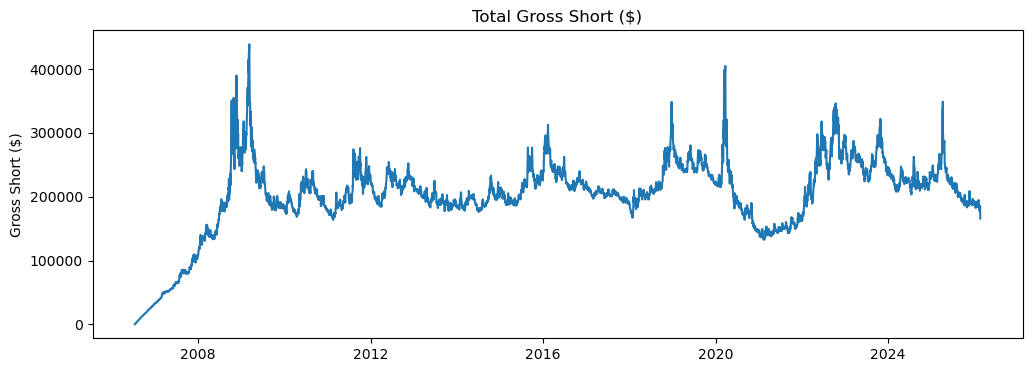

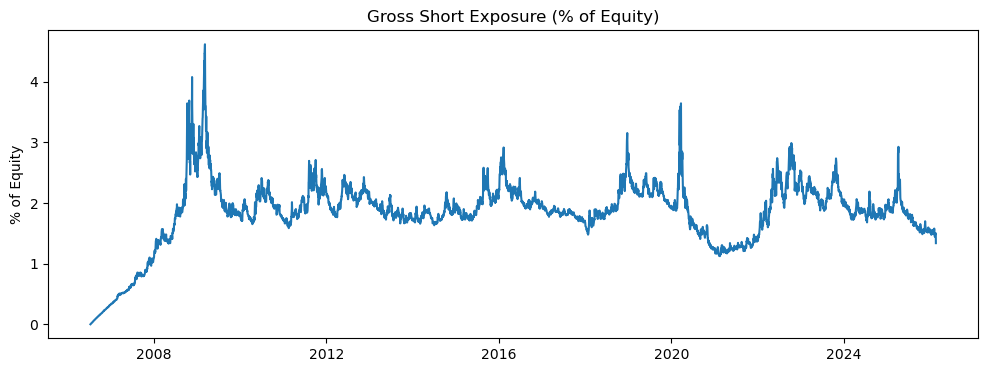

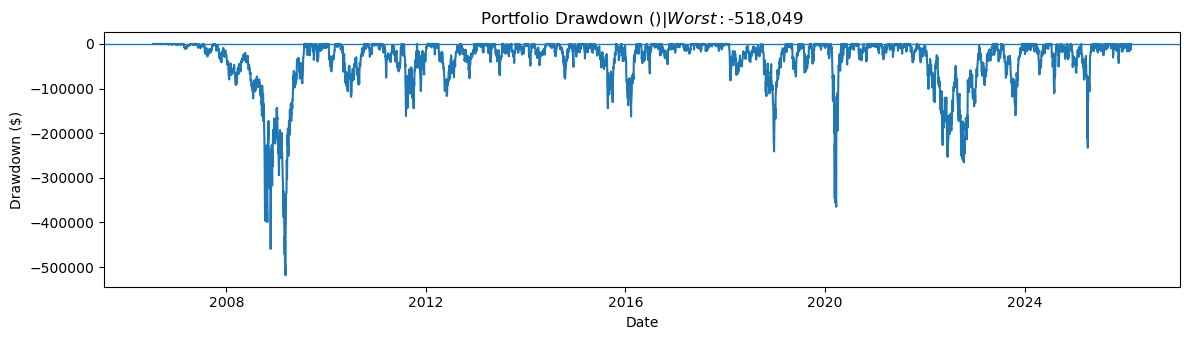

Current Gross Short: $165,818
Current Gross Short % of Equity: 1.34%
=== Portfolio (dynamic activation) ===
First ticker: SDS (start 2006-07-13)
Backtest window: 2006-07-13 -> 2026-02-19  (19.61 years)
Final equity: $12,383,419
CAGR: 1.10%
Ann vol: 1.97%
Sharpe (rf=0): 0.56
Max drawdown: -5.17%  ($-518,049)
Final gross % equity: n/a


In [53]:

# Borrow overrides (optional): uses global borrow_map if present
borrow_annual_overrides = {}
default_override = 0.10
if "borrow_map" in globals() and globals().get("borrow_map") is not None:
    bm = globals()["borrow_map"]
    default_override = float(bm.get("default", default_override))
    borrow_annual_overrides = {_norm_sym(k): float(v) for k, v in bm.items() if k != "default"}

bt = backtest_combined_inverse_portfolio_dynamic_activation(
    tr_prices=prices,
    target_weights=portfolio_weights,
    borrow_daily_map=borrow_daily_map,
    portfolio_equity=start_equity,
    daily_total_short=daily_total_short,
    default_borrow_annual=default_override,
)

port_curve = bt["equity_curve"]
port_m = bt["metrics"]
port_curve = bt["equity_curve"]
gross_    = bt["gross_notional_$"]
gross_pct  = bt["gross_notional_pct_equity"]


# ----------------------------
# PLOT (equity curves)
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(port_curve.index, port_curve.values, label="Inverse Basket")
plt.axhline(start_equity, linewidth=1)
plt.title("Bucket 3")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(gross_.index, gross_.values)
plt.title("Total Gross Short ($)")
plt.ylabel("Gross Short ($)")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(gross_pct.index, gross_pct.values * 100)
plt.title("Gross Short Exposure (% of Equity)")
plt.ylabel("% of Equity")
plt.show()


# ----------------------------
# PLOT (drawdown in $)
# ----------------------------
dd_dol = bt["drawdown_$"].dropna()
plt.figure(figsize=(12, 3.5))
plt.plot(dd_dol.index, dd_dol.values)
plt.axhline(0, linewidth=1)
plt.title(f"Portfolio Drawdown ($) | Worst: {_fmt_dol(port_m['MaxDD_$'])}")
plt.ylabel("Drawdown ($)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# ----------------------------
# PRINT METRICS (portfolio + SPY)
# ----------------------------
current_gross = gross_.iloc[-1]
current_pct   = gross_pct.iloc[-1] * 100

print("Current Gross Short: ${:,.0f}".format(current_gross))
print("Current Gross Short % of Equity: {:.2f}%".format(current_pct))

print("=== Portfolio (dynamic activation) ===")
print(f"First ticker: {port_m['FirstTicker']} (start {port_m['FirstTickerStart']})")
print(f"Backtest window: {port_m['StartDate']} -> {port_m['EndDate']}  ({port_m['Years']:.2f} years)")
print(f"Final equity: {_fmt_dol(port_m['FinalEquity'])}")
print(f"CAGR: {_fmt_pct(port_m['CAGR'])}")
print(f"Ann vol: {_fmt_pct(port_m['AnnVol'])}")
print(f"Sharpe (rf=0): {port_m['Sharpe']:.2f}" if np.isfinite(port_m["Sharpe"]) else "Sharpe (rf=0): n/a")
print(f"Max drawdown: {_fmt_pct(port_m['MaxDD_pct'])}  ({_fmt_dol(port_m['MaxDD_$'])})")
print(f"Final gross % equity: {_fmt_pct(port_m['FinalGrossPctEq'])}")

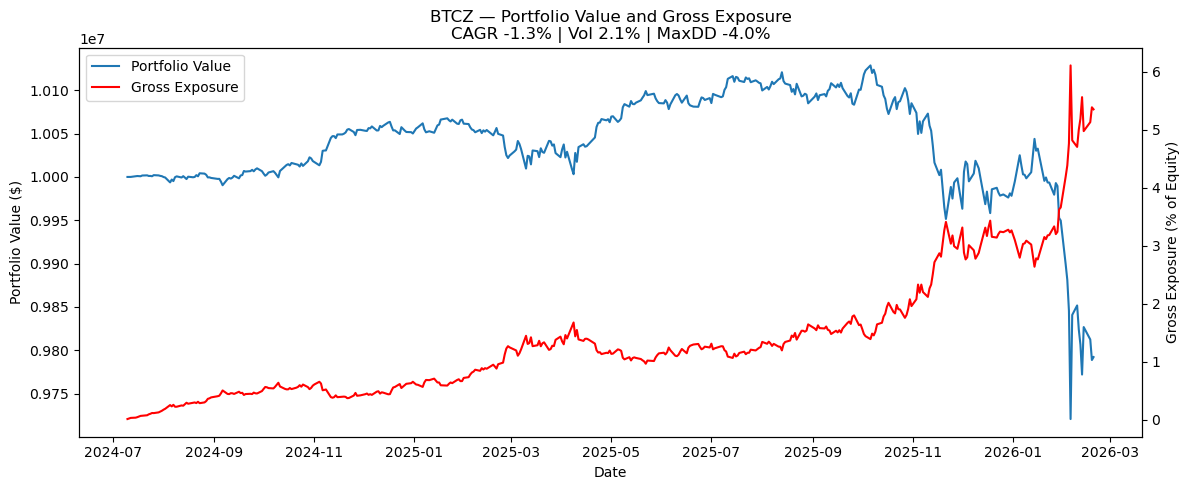

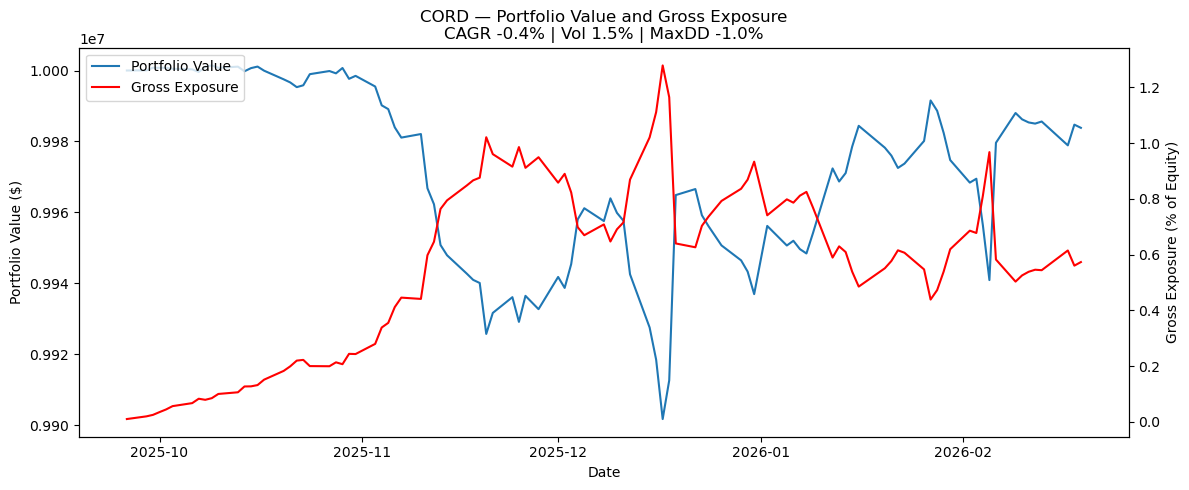

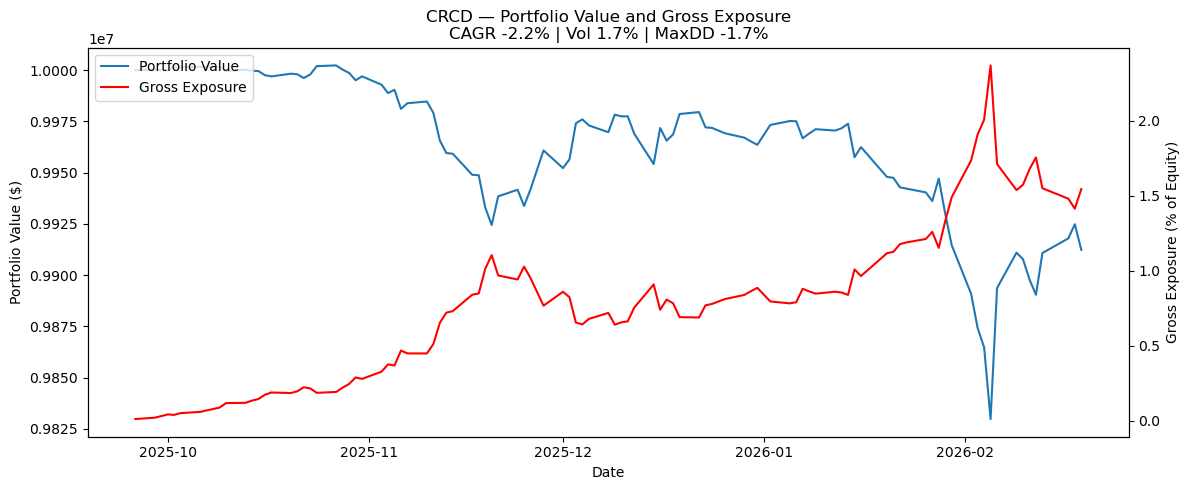

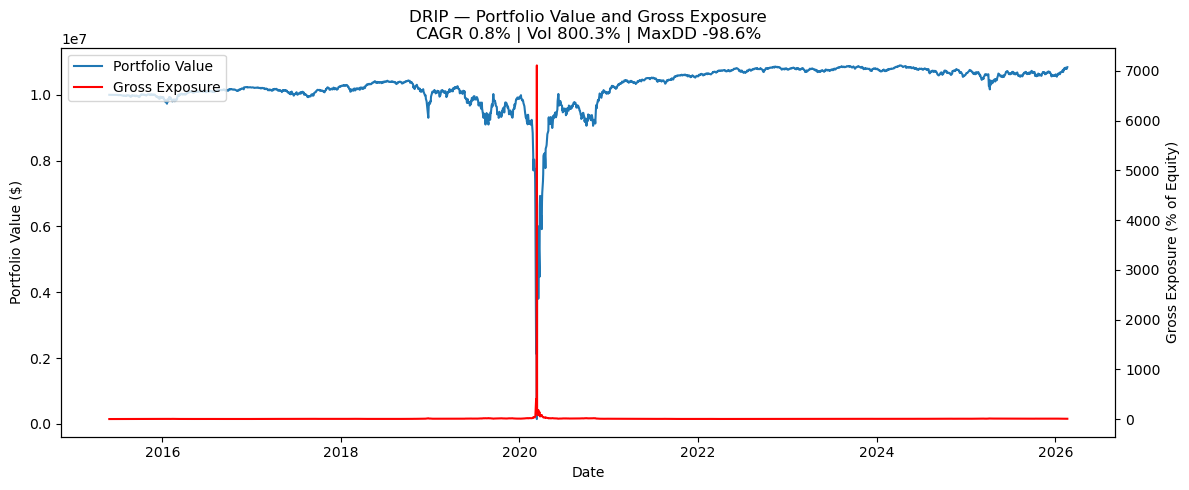

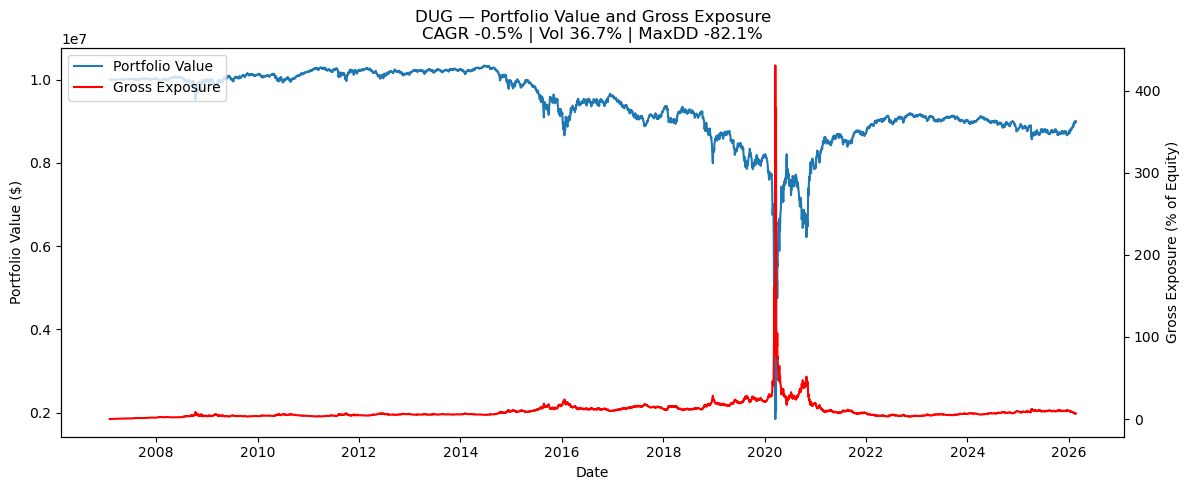

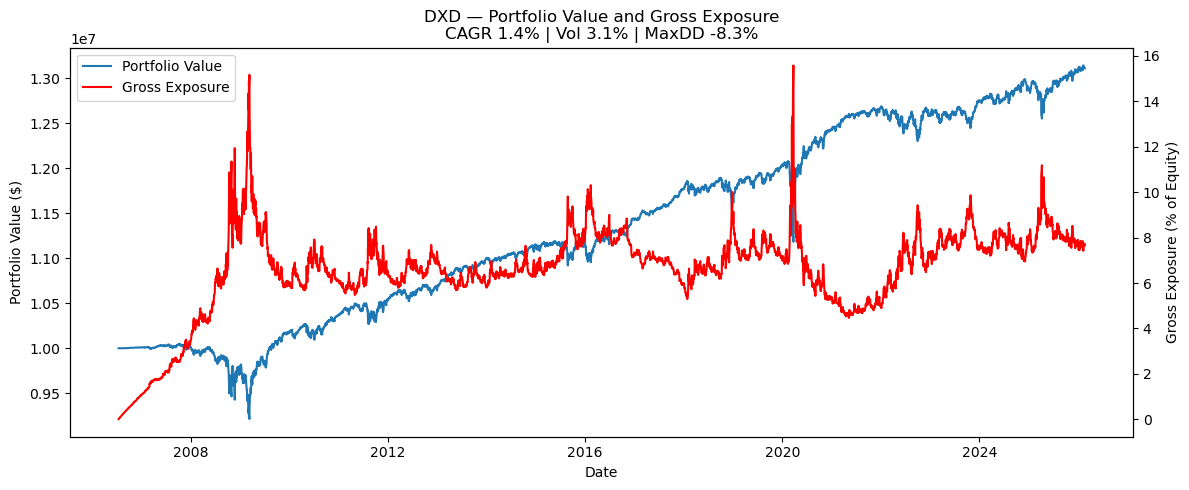

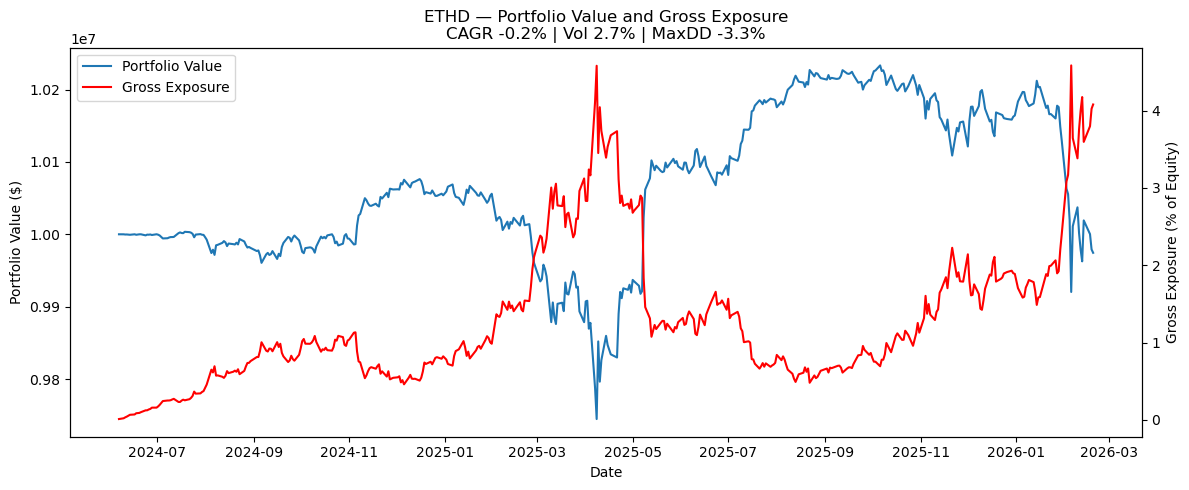

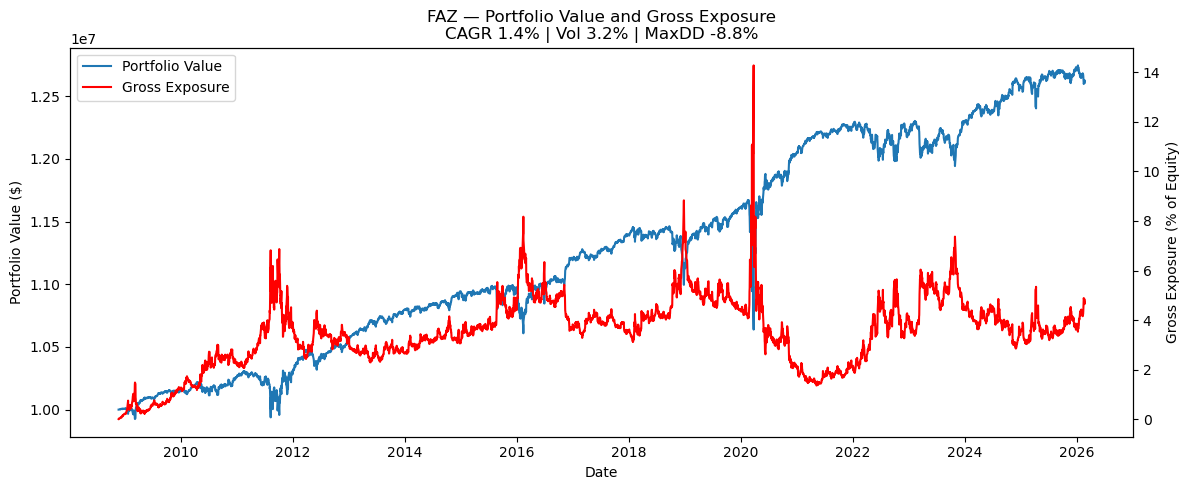

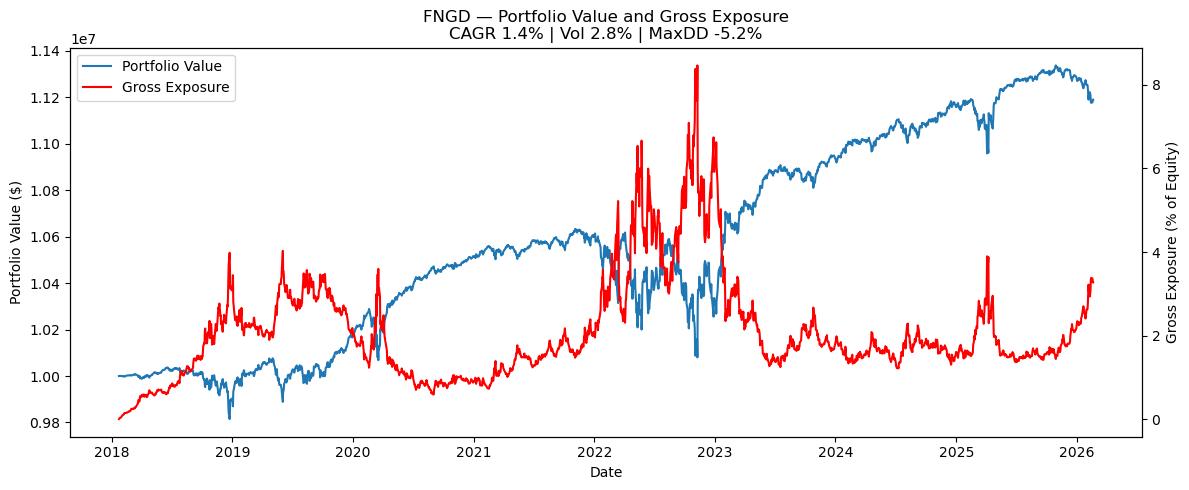

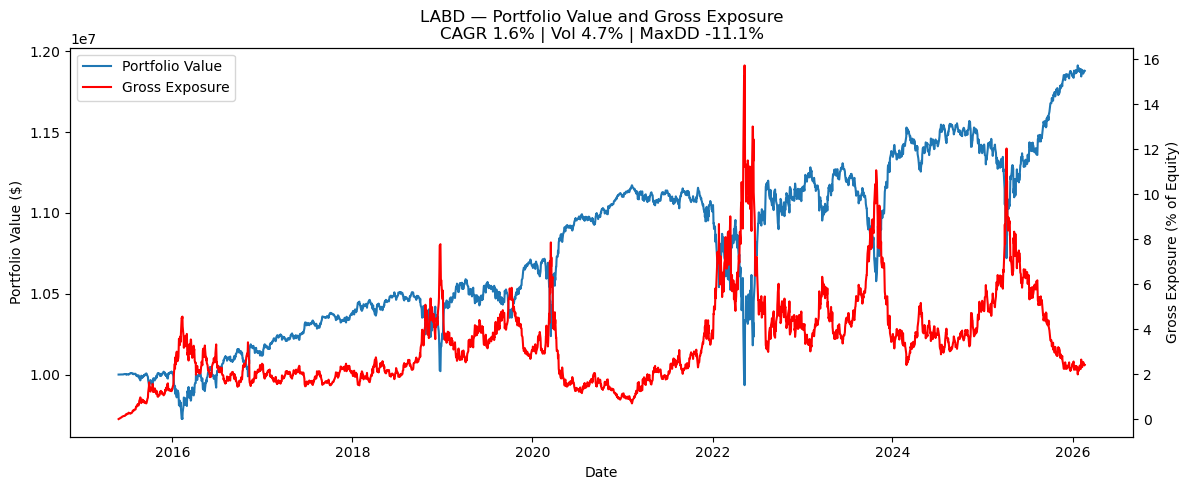

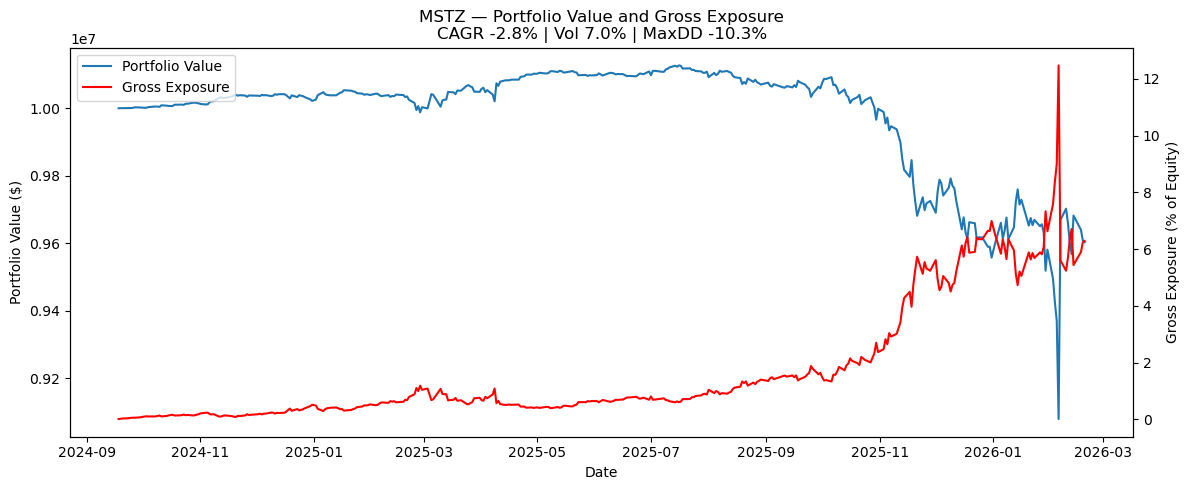

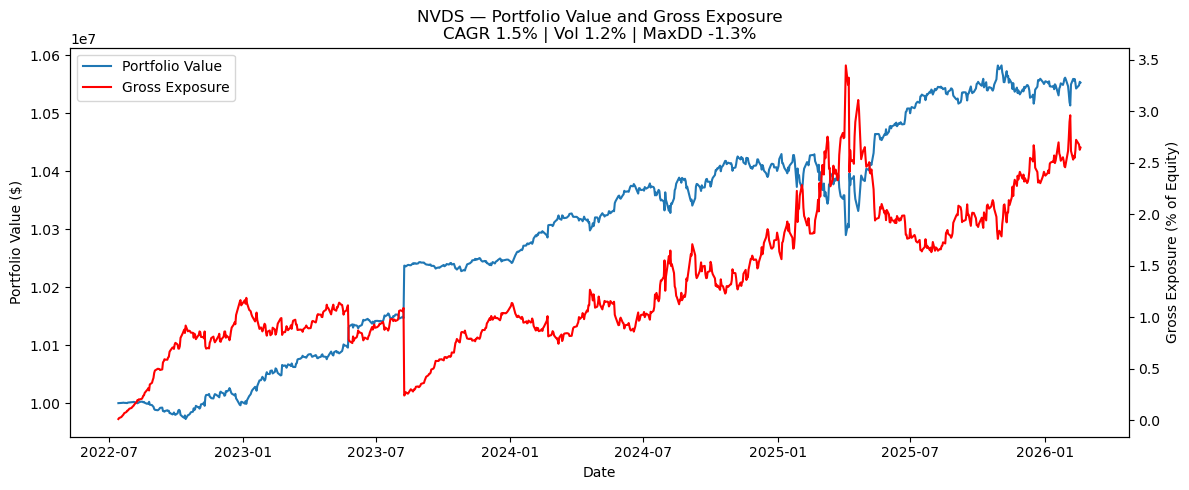

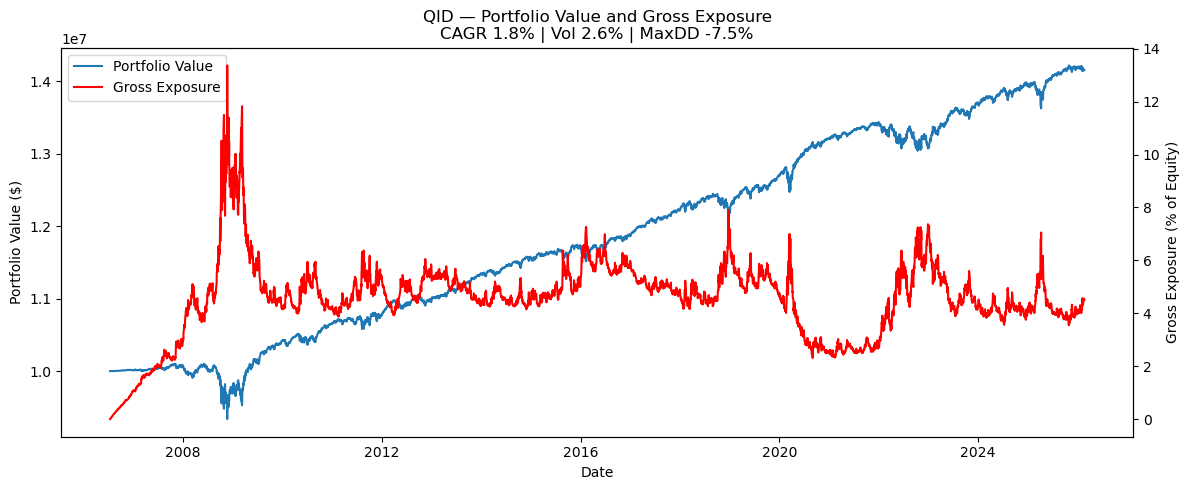

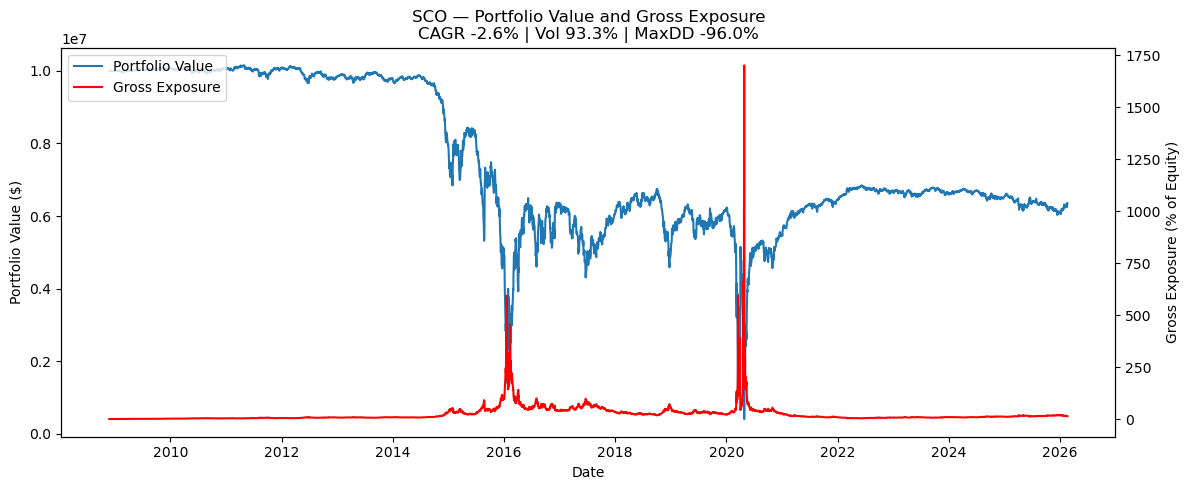

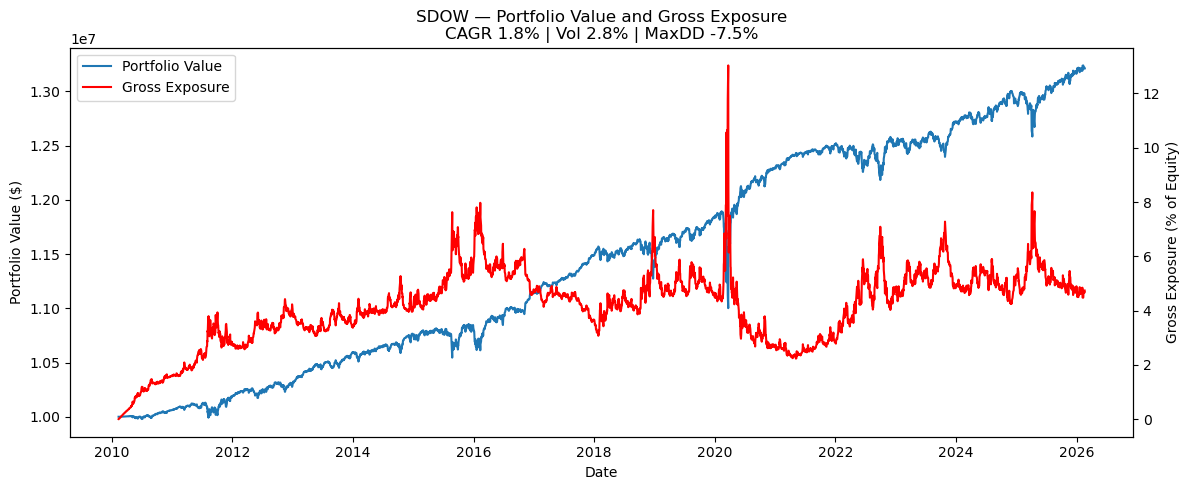

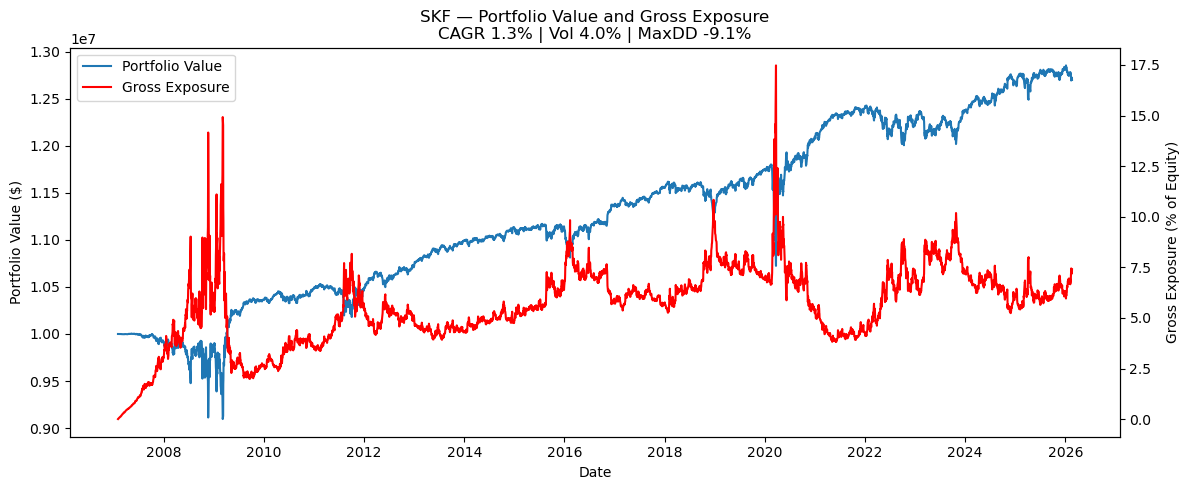

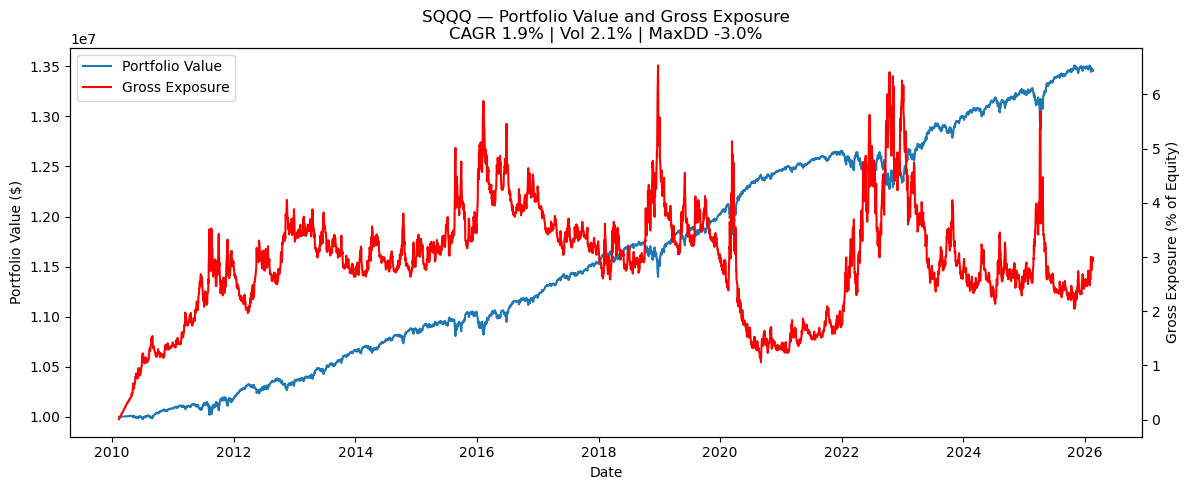

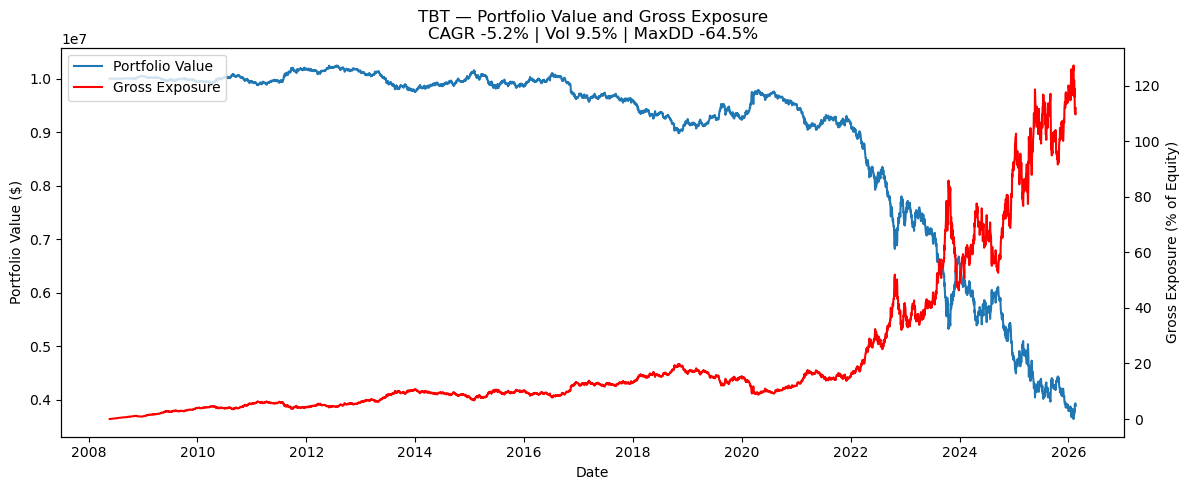

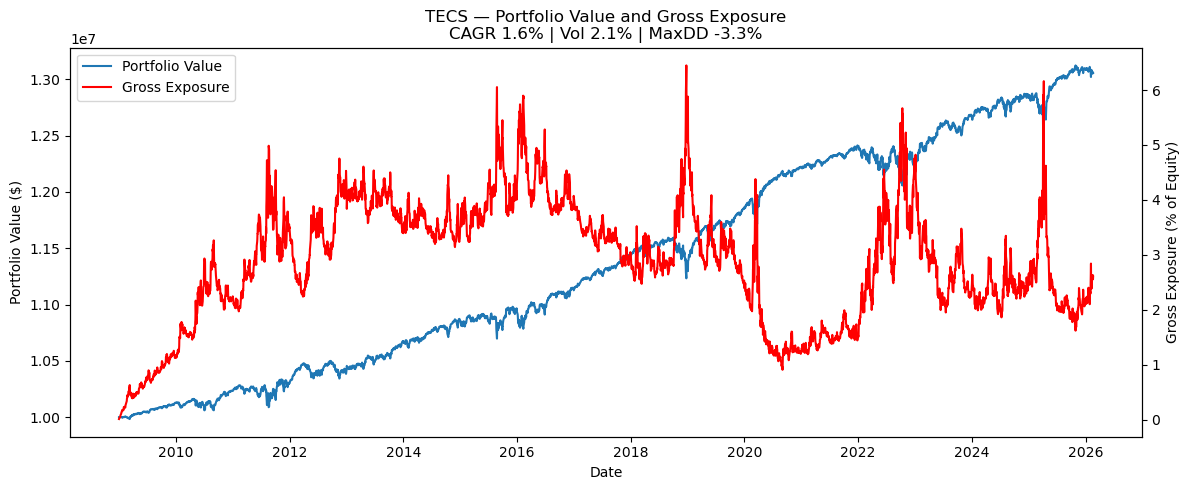

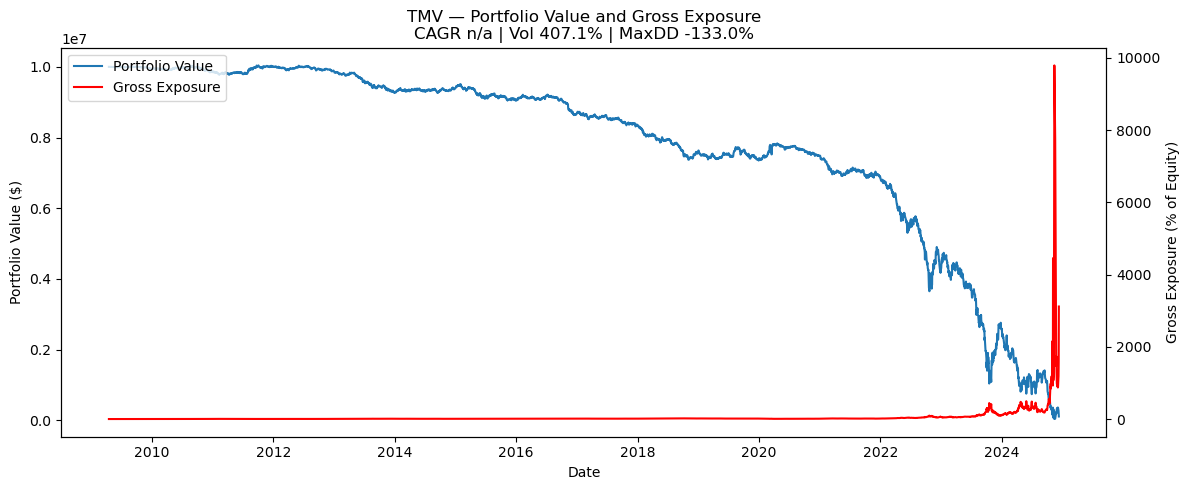

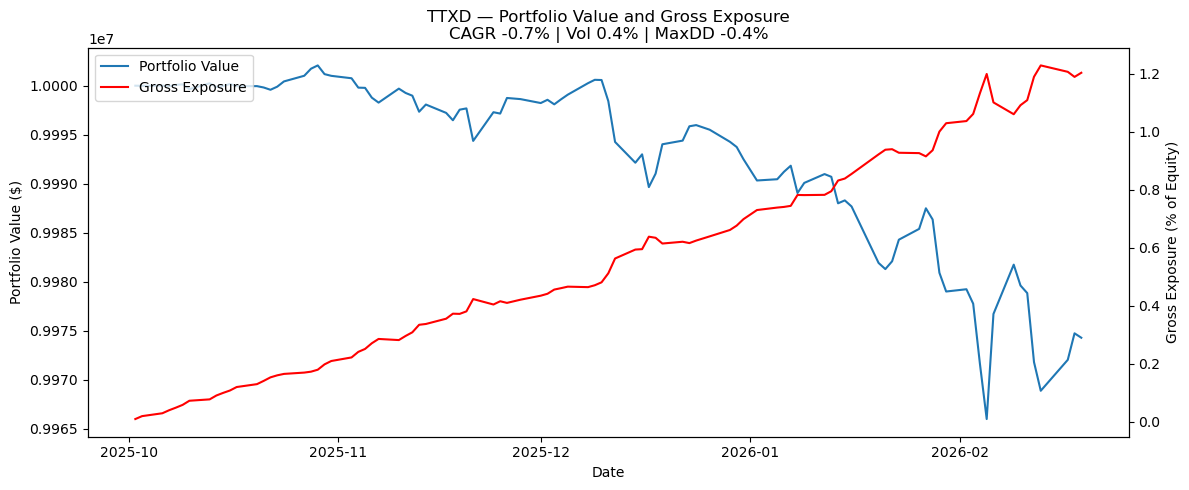

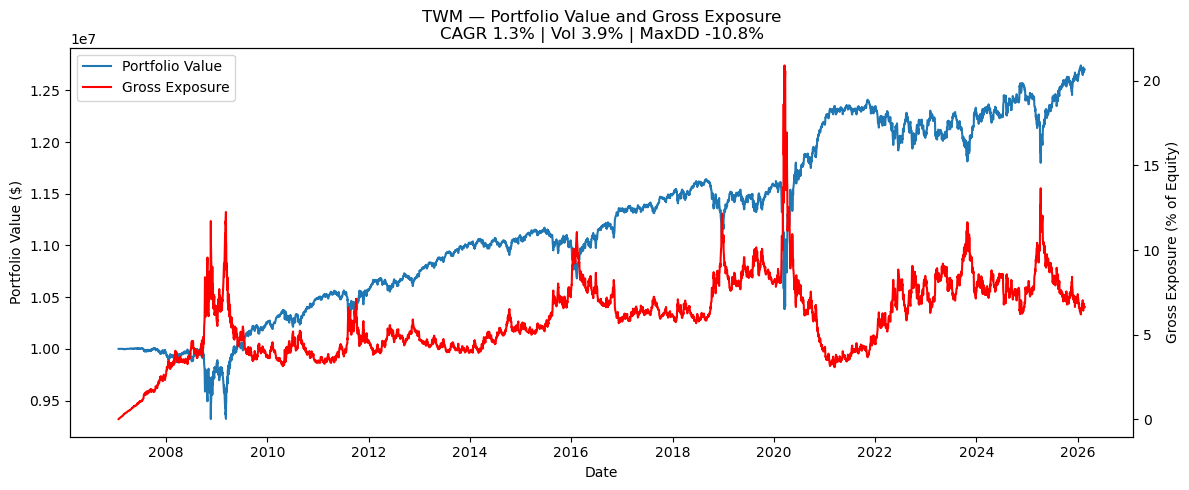

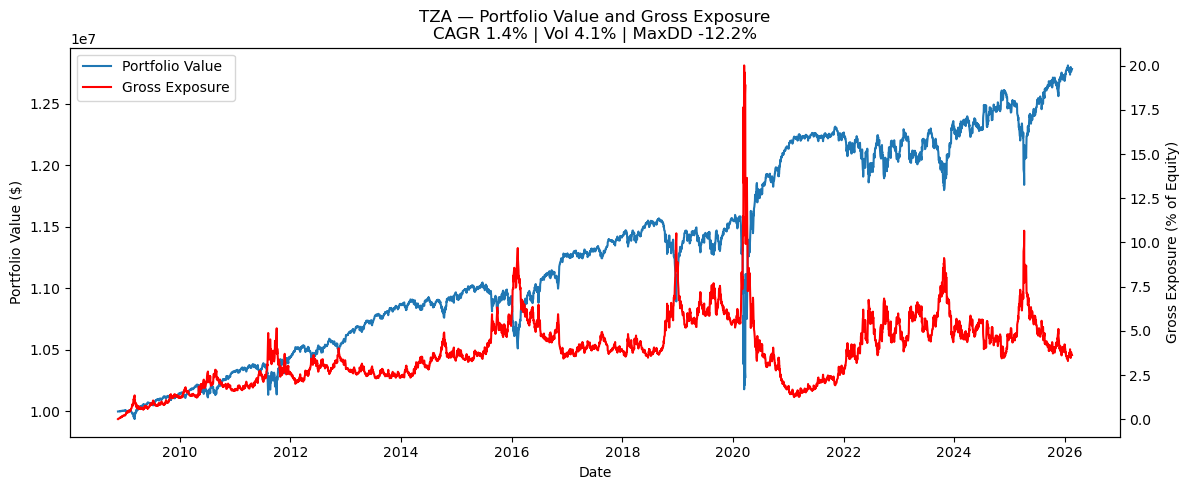

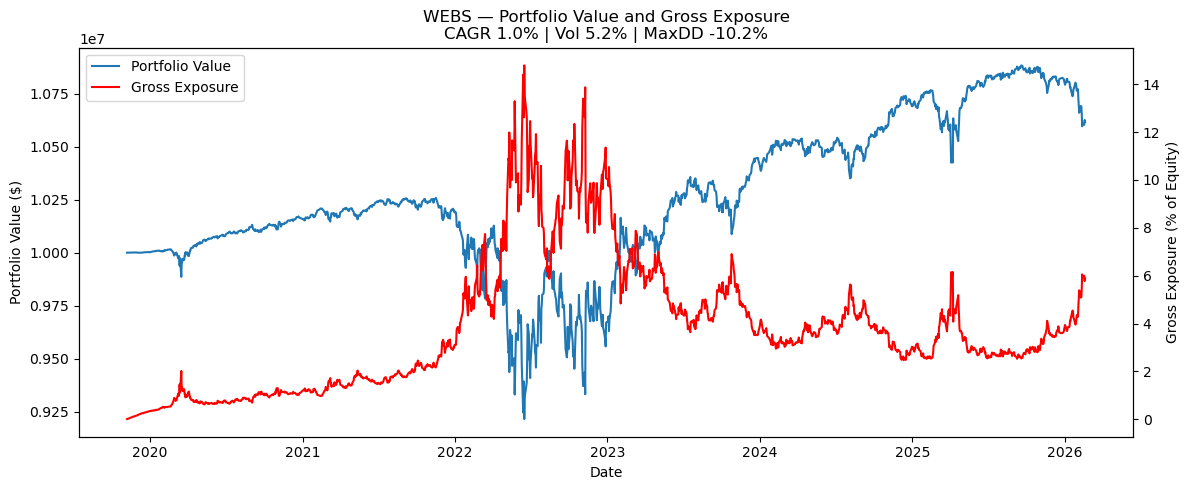

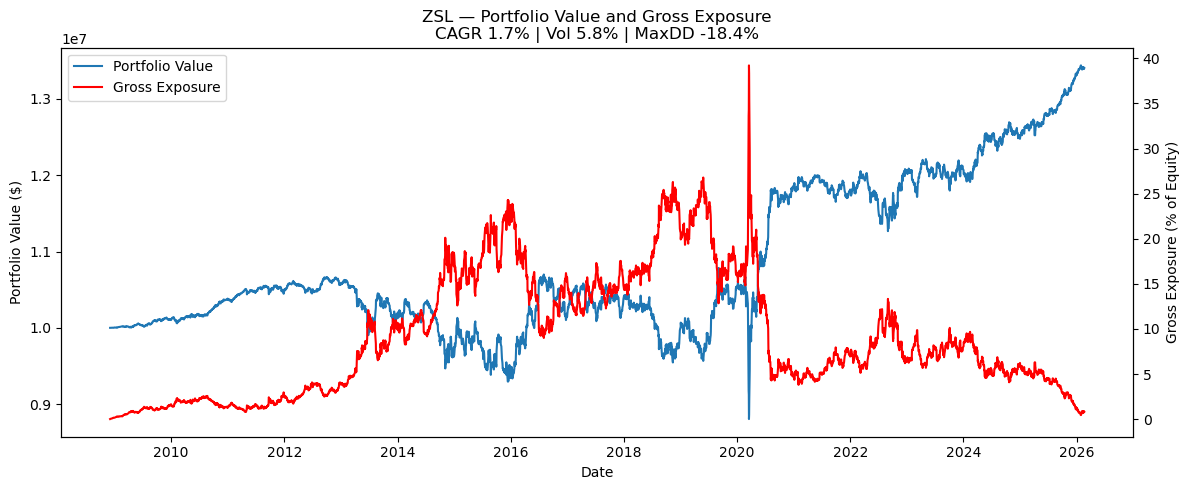

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_equity_and_gross_overlay_all_universe(
    out: dict,
    universe: pd.DataFrame,
    *,
    start: str | None = None,
    end: str | None = None,
    stats_df: pd.DataFrame | None = None,   # default: out["stats"]
    figsize=(12, 5),
):
    """
    Plots (per ticker):
      - equity_curve (left axis)
      - gross_notional_pct_equity (right axis, %)

    Adds perf stats in the title:
      CAGR, AnnVol, MaxDD   (from out["stats"] or supplied stats_df)

    Automatically uses ALL tickers from universe["InverseETF"].
    """

    by_ticker = out.get("by_ticker", {})
    if stats_df is None:
        stats_df = out.get("stats", pd.DataFrame()).copy()
    else:
        stats_df = stats_df.copy()

    # normalize tickers for join and lookup
    stats_df["ticker"] = stats_df["ticker"].astype(str).map(_norm_sym)

    # build ticker list from universe
    tickers = sorted({_norm_sym(x) for x in universe["InverseETF"].tolist()})

    # index stats for fast lookup
    stats_idx = stats_df.set_index("ticker", drop=False)

    start_ts = pd.Timestamp(start) if start is not None else None
    end_ts   = pd.Timestamp(end) if end is not None else None

    for tkr in tickers:
        if tkr not in by_ticker:
            # skip if no backtest output for this symbol
            continue

        d = by_ticker[tkr]
        equity = d.get("equity_curve", pd.Series(dtype=float)).dropna()
        gross  = d.get("gross_notional_pct_equity", pd.Series(dtype=float)).dropna()

        if equity.empty or gross.empty:
            continue

        equity.index = pd.to_datetime(equity.index)
        gross.index  = pd.to_datetime(gross.index)

        # date filter
        if start_ts is not None:
            equity = equity.loc[equity.index >= start_ts]
            gross  = gross.loc[gross.index >= start_ts]
        if end_ts is not None:
            equity = equity.loc[equity.index <= end_ts]
            gross  = gross.loc[gross.index <= end_ts]

        # align dates
        common = equity.index.intersection(gross.index)
        equity = equity.loc[common]
        gross  = gross.loc[common]

        if equity.empty or gross.empty:
            continue

        # pull stats for title
        if tkr in stats_idx.index:
            row = stats_idx.loc[tkr]
            cagr = row.get("CAGR", np.nan)
            vol  = row.get("AnnVol", np.nan)
            mdd  = row.get("MaxDD", np.nan)

            # format as percents
            cagr_s = f"{100*cagr:,.1f}%" if np.isfinite(cagr) else "n/a"
            vol_s  = f"{100*vol:,.1f}%"  if np.isfinite(vol)  else "n/a"
            mdd_s  = f"{100*mdd:,.1f}%"  if np.isfinite(mdd)  else "n/a"
            subtitle = f"CAGR {cagr_s} | Vol {vol_s} | MaxDD {mdd_s}"
        else:
            subtitle = "CAGR n/a | Vol n/a | MaxDD n/a"

        # plot
        fig, ax1 = plt.subplots(figsize=figsize)

        ax1.plot(equity.index, equity.values, label="Portfolio Value")
        ax1.set_ylabel("Portfolio Value ($)")
        ax1.set_xlabel("Date")

        ax2 = ax1.twinx()
        ax2.plot(gross.index, 100.0 * gross.values, label="Gross Exposure", color="red")
        ax2.set_ylabel("Gross Exposure (% of Equity)")

        # single combined legend (clean)
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1 + h2, l1 + l2, loc="upper left", frameon=True)

        ax1.set_title(f"{tkr} — Portfolio Value and Gross Exposure\n{subtitle}")

        plt.tight_layout()
        plt.show()


# ==========================
# RUN (uses your objects)
# ==========================
plot_equity_and_gross_overlay_all_universe(
    out=out,             # <-- from your backtest run
    universe=universe,   # <-- your constructed universe DataFrame
    stats_df=stats,      # <-- merged stats+meta (optional but recommended)
    start=None,
    end=None,
)


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

PAIRS = {
    "SPY": ("SPY", "SDS"),
    "QQQ": ("QQQ", "SQQQ"),
    "GLD": ("GLD", "DUST"),
    "BIOTECH": ("IBB", "LABD"),
}

# ----------------------------
# Helpers
# ----------------------------
def _fmt_pct(x: float) -> str:
    return "n/a" if (x is None or not np.isfinite(x)) else f"{100*x:,.1f}%"

def _max_drawdown_from_equity(eq: pd.Series) -> float:
    eq = eq.dropna()
    if eq.empty:
        return np.nan
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())

def _cagr_from_equity(eq: pd.Series) -> float:
    eq = eq.dropna()
    if len(eq) < 2:
        return np.nan
    start_v, end_v = float(eq.iloc[0]), float(eq.iloc[-1])
    if start_v <= 0 or end_v <= 0:
        return np.nan
    days = (eq.index[-1] - eq.index[0]).days
    if days <= 0:
        return np.nan
    years = days / 365.25
    return (end_v / start_v) ** (1.0 / years) - 1.0

def _ann_vol_from_equity(eq: pd.Series) -> float:
    eq = eq.dropna()
    if len(eq) < 3:
        return np.nan
    r = eq.pct_change().dropna()
    return float(r.std(ddof=0) * np.sqrt(TRADING_DAYS)) if not r.empty else np.nan

def _sharpe_from_equity(eq: pd.Series) -> float:
    eq = eq.dropna()
    if len(eq) < 3:
        return np.nan
    r = eq.pct_change().dropna()
    if r.empty:
        return np.nan
    vol = r.std(ddof=0)
    return float((r.mean() / vol) * np.sqrt(TRADING_DAYS)) if vol > 0 else np.nan

def _get_px_col(px: pd.DataFrame, ticker: str) -> pd.Series:
    t = str(ticker).upper()
    if t in px.columns:
        return px[t].dropna()

    candidates = [
        f"{t}_TR", f"{t}_tr",
        f"{t}_Adj Close", f"{t}_adjclose",
        f"{t}_Close", f"{t}_close",
        f"{t}_PX", f"{t}_px",
    ]
    for c in candidates:
        if c in px.columns:
            return px[c].dropna()

    if isinstance(px.columns, pd.MultiIndex):
        if t in px.columns.get_level_values(-1):
            sub = px.xs(t, axis=1, level=-1)
            for col in ["TR", "Adj Close", "Close", "close", "adjclose"]:
                if col in sub.columns:
                    return sub[col].dropna()
            return sub.iloc[:, 0].dropna()

        if t in px.columns.get_level_values(0):
            sub = px.xs(t, axis=1, level=0)
            for col in ["TR", "Adj Close", "Close", "close", "adjclose"]:
                if col in sub.columns:
                    return sub[col].dropna()
            return sub.iloc[:, 0].dropna()

    raise KeyError(f"{ticker} not found. Available cols: {list(px.columns)[:20]}")

def _annualized_vol(ret: pd.Series, window: int) -> pd.Series:
    return ret.rolling(window).std(ddof=0) * np.sqrt(TRADING_DAYS)

def backtest_dca_independent(
    px_s: pd.Series,
    *,
    direction: str,                 # "long" or "short"
    symbol: str,
    start_equity: float,
    daily_notional: float,
    enable_risk_band: bool,
    vol_window: int,
    target_risk: float | pd.Series,     # legacy path (optional)
    band: float,
    rebalance_on_low: bool,             # kept for compatibility
    borrow_annual_map: dict | None,
    borrow_day_count: int = 360,
    desired_exposure: float | pd.Series | None = None,  # desired gross exposure ($)
):
    """
    Cash-consistent DCA backtest.

    State:
      - cash: starts at start_equity
      - shares: positive magnitude for both long and short
      - NAV/equity is computed as:
          long:  cash + shares*px
          short: cash - shares*px

    DCA each day by fixed notional:
      long:  buy $daily_notional  => cash -= N, shares += N/px
      short: short $daily_notional => cash += N, shares += N/px

    Rebalance (if enabled):
      - If desired_exposure provided: target gross exposure
      - Else legacy target_risk sizing
    """

    px_s = px_s.dropna().astype(float)
    idx = px_s.index
    ret = px_s.pct_change()

    # Normalize desired exposure series
    if desired_exposure is not None:
        if isinstance(desired_exposure, pd.Series):
            desired_exposure_s = desired_exposure.reindex(idx).ffill().bfill()
        else:
            desired_exposure_s = pd.Series(float(desired_exposure), index=idx)
    else:
        desired_exposure_s = None

    # Normalize target_risk series (legacy)
    if isinstance(target_risk, pd.Series):
        tr = target_risk.reindex(idx).ffill().bfill()
    else:
        tr = pd.Series(float(target_risk), index=idx)

    # Borrow series for shorts
    if borrow_annual_map is not None:
        b = borrow_annual_map.get(symbol, borrow_annual_map.get("default", 0.0))
        if isinstance(b, pd.Series):
            borrow_ann = b.reindex(idx).ffill().bfill().astype(float)
        else:
            borrow_ann = pd.Series(float(b), index=idx)
    else:
        borrow_ann = pd.Series(0.0, index=idx)

    # Rolling realized vol of instrument returns (annualized)
    vol = ret.rolling(vol_window).std(ddof=0) * np.sqrt(TRADING_DAYS)

    # ---- State
    cash = float(start_equity)
    shares = 0.0  # magnitude
    rebalanced_days = 0
    borrow_cost_total = 0.0

    # ---- Diagnostics
    equity_hist = []
    cash_hist = []
    shares_hist = []
    gross_exposure_hist = []
    borrow_cost_hist = []
    realized_vol_hist = []
    desired_exposure_hist = []
    did_rebalance_hist = []
    target_risk_hist = []

    def _nav(px: float) -> float:
        if direction == "long":
            return cash + shares * px
        else:
            return cash - shares * px

    for t, dt in enumerate(idx):
        px = float(px_s.iloc[t])
        if not (np.isfinite(px) and px > 0):
            # still record something consistent
            equity_hist.append(np.nan)
            cash_hist.append(cash)
            shares_hist.append(shares)
            gross_exposure_hist.append(np.nan)
            borrow_cost_hist.append(0.0)
            realized_vol_hist.append(np.nan)
            desired_exposure_hist.append(np.nan)
            did_rebalance_hist.append(False)
            target_risk_hist.append(float(tr.iloc[t]))
            continue

        # 0) Mark NAV at start-of-day (mark-to-market happens automatically via NAV formula)
        equity = _nav(px)

        # 1) Borrow cost (charged daily on current short notional)
        if direction == "short":
            short_notional = shares * px
            bc = short_notional * float(borrow_ann.iloc[t]) / float(borrow_day_count)
            cash -= bc
            borrow_cost_total += bc
            borrow_cost_hist.append(bc)
            equity = _nav(px)
        else:
            borrow_cost_hist.append(0.0)

        # 2) Daily DCA trade (cash-consistent)
        N = float(daily_notional)
        if direction == "long":
            # buy $N
            cash -= N
            shares += N / px
        else:
            # short $N (receive proceeds)
            cash += N
            shares += N / px

        equity = _nav(px)

        # 3) Rebalance (ONLY if enabled; your short should set enable_risk_band=False)
        did_rebal = False
        if enable_risk_band and t > 0:
            current_gross = shares * px

            # Preferred: target gross exposure series
            if desired_exposure_s is not None:
                desired_gross = float(desired_exposure_s.iloc[t])
                if np.isfinite(desired_gross) and desired_gross > 0:
                    lo = (1.0 - band) * desired_gross
                    hi = (1.0 + band) * desired_gross
                    if current_gross < lo or current_gross > hi:
                        target_shares = desired_gross / px
                        delta_shares = target_shares - shares  # + means buy (or short more), - means sell (or cover)

                        if direction == "long":
                            # buy/sell underlying to reach target
                            cash -= delta_shares * px
                        else:
                            # change short: increasing shares -> receive proceeds, decreasing -> pay to cover
                            cash += delta_shares * px

                        shares = target_shares
                        rebalanced_days += 1
                        did_rebal = True

                desired_exposure_hist.append(desired_gross)
                realized_vol_hist.append(float(vol.iloc[t]) if np.isfinite(vol.iloc[t]) else np.nan)

            # Legacy: target_risk sizing (uses equity & vol)
            else:
                sig = float(vol.iloc[t]) if np.isfinite(vol.iloc[t]) else np.nan
                tr_t = float(tr.iloc[t])
                if np.isfinite(sig) and sig > 0 and np.isfinite(tr_t) and tr_t > 0:
                    desired_gross = equity * (tr_t / sig)
                    lo = (1.0 - band) * desired_gross
                    hi = (1.0 + band) * desired_gross
                    if current_gross < lo or current_gross > hi:
                        target_shares = desired_gross / px
                        delta_shares = target_shares - shares

                        if direction == "long":
                            cash -= delta_shares * px
                        else:
                            cash += delta_shares * px

                        shares = target_shares
                        rebalanced_days += 1
                        did_rebal = True

                    desired_exposure_hist.append(desired_gross)
                    realized_vol_hist.append(sig)
                else:
                    desired_exposure_hist.append(np.nan)
                    realized_vol_hist.append(np.nan)

            equity = _nav(px)
        else:
            desired_exposure_hist.append(np.nan)
            realized_vol_hist.append(np.nan)

        # 4) Store diagnostics
        equity_hist.append(equity)
        cash_hist.append(cash)
        shares_hist.append(shares)
        gross_exposure_hist.append(shares * px)
        did_rebalance_hist.append(did_rebal)
        target_risk_hist.append(float(tr.iloc[t]))

    equity_s = pd.Series(equity_hist, index=idx, name="equity")

    diag = pd.DataFrame(
        {
            "Equity": equity_s,
            "Cash": cash_hist,
            "Shares": shares_hist,
            "GrossExposure": gross_exposure_hist,
            "TargetRisk": target_risk_hist,
            "RealizedVol": realized_vol_hist,
            "DesiredExposure": desired_exposure_hist,
            "DidRebalance": did_rebalance_hist,
            "BorrowCost": borrow_cost_hist,
        },
        index=idx,
    )

    return {
        "symbol": symbol,
        "direction": direction,
        "equity": equity_s,
        "diag": diag,
        "rebalanced_days": int(rebalanced_days),
        "borrow_cost_total": float(borrow_cost_total),
        "gross_exposure_mean": float(diag["GrossExposure"].mean()),
        "gross_exposure_max": float(diag["GrossExposure"].max()),
        "gross_exposure_end": float(diag["GrossExposure"].iloc[-1]),
    }


# ----------------------------
# Compare long vs short (SHORT NEVER REBALANCES)
# ----------------------------
def compare_long_vs_short_independent(
    px: pd.DataFrame,
    *,
    borrow_annual_map: dict,
    start_equity: float = 100_000.0,
    daily_notional: float = 200.0,
    vol_window: int = 60,
    band: float = 0.25,
    borrow_day_count: int = 360,
    plot: bool = True,
    alpha: float = 1.0,               # risk-match aggressiveness
    min_long_gross: float = 0.0,
    max_long_gross: float | None = None,
):
    """
    SHORT inverse ETF sleeve:
      - DCA daily
      - NEVER rebalance (enable_risk_band=False, always)

    LONG sleeve:
      - DCA daily
      - rebalance ONLY when its gross exposure drifts outside a band around
        the desired risk-matched gross exposure vs the short sleeve.

    Risk proxy:
      risk = gross_exposure * realized_vol (annualized)
    Desired long gross:
      gross_long = alpha * gross_short * vol_short / vol_long
    """
    out = {}

    for name, (under, inv) in PAIRS.items():
        px_u = _get_px_col(px, under)
        px_i = _get_px_col(px, inv)
        df = pd.DataFrame({under: px_u, inv: px_i}).dropna()
        px_u2, px_i2 = df[under], df[inv]

        # 1) SHORT sleeve first: DCA only, NEVER rebalance
        short_res = backtest_dca_independent(
            px_i2,
            direction="short",
            symbol=inv,
            start_equity=start_equity,
            daily_notional=daily_notional,
            enable_risk_band=False,        # <<< GUARANTEES no rebalance
            vol_window=vol_window,
            target_risk=0.0,
            band=band,
            rebalance_on_low=False,
            borrow_annual_map=borrow_annual_map,
            borrow_day_count=borrow_day_count,
        )

        # 2) Compute realized vols for both instruments (annualized)
        ret_u = px_u2.pct_change()
        ret_i = px_i2.pct_change()
        vol_u = _annualized_vol(ret_u, window=vol_window)
        vol_i = _annualized_vol(ret_i, window=vol_window)

        # 3) Short's *actual* gross exposure path from the sim
        short_gross = short_res["diag"]["GrossExposure"].reindex(df.index).ffill()

        # risk proxy
        risk_short = short_gross * vol_i

        # desired long gross to match short risk
        desired_long_gross = alpha * (risk_short / vol_u)

        # clean + guardrails
        desired_long_gross = desired_long_gross.replace([np.inf, -np.inf], np.nan).ffill().bfill()
        desired_long_gross = desired_long_gross.clip(lower=min_long_gross)
        if max_long_gross is not None:
            desired_long_gross = desired_long_gross.clip(upper=float(max_long_gross))

        # 4) LONG sleeve: rebalance only when outside band vs desired_long_gross
        long_res = backtest_dca_independent(
            px_u2,
            direction="long",
            symbol=under,
            start_equity=start_equity,
            daily_notional=daily_notional,
            enable_risk_band=True,          # <<< only long rebalances
            vol_window=vol_window,
            target_risk=0.0,                # unused since desired_exposure provided
            band=band,
            rebalance_on_low=False,
            borrow_annual_map=None,
            borrow_day_count=borrow_day_count,
            desired_exposure=desired_long_gross,
        )

        out[name] = {
            "long": long_res,
            "short": short_res,
            "desired_long_gross": desired_long_gross,
            "vol_long": vol_u,
            "vol_short": vol_i,
        }

        # Print stats
        for label, res in [("LONG", long_res), ("SHORT", short_res)]:
            eq = res["equity"].dropna()
            cagr = _cagr_from_equity(eq)
            vol  = _ann_vol_from_equity(eq)
            mdd  = _max_drawdown_from_equity(eq)
            shrp = _sharpe_from_equity(eq)
            bor  = res.get("borrow_cost_total", 0.0)
            rb   = res.get("rebalanced_days", 0)
            print(
                f"{name:8s} {label:5s} | CAGR {_fmt_pct(cagr)} | Vol {_fmt_pct(vol)} | MaxDD {_fmt_pct(mdd)} "
                f"| Sharpe {shrp if np.isfinite(shrp) else np.nan:.2f} | RebalDays {rb} | Borrow ${bor:,.0f}"
            )

        if plot:
            eL = long_res["equity"].dropna()
            eS = short_res["equity"].dropna()
            common = eL.index.intersection(eS.index)
            if len(common) > 10:
                plt.figure(figsize=(12, 5))
                plt.plot(eL.loc[common].index, eL.loc[common].values, label=f"Long {under}")
                plt.plot(eS.loc[common].index, eS.loc[common].values, label=f"Short {inv}")
                plt.axhline(start_equity, linewidth=1)
                plt.title(f"{name}: Independent equity curves (DCA long vs DCA short)")
                plt.ylabel("Equity ($)")
                plt.xlabel("Date")
                plt.legend(loc="upper left")
                plt.tight_layout()
                plt.show()

    return out

tickers = ["SPY","SDS","QQQ","SQQQ","GLD","DUST","IBB","LABD"]
px = build_prices_tr_from_yf(tickers, start="2000-01-01")

SPY      LONG  | CAGR 1.9% | Vol 3.1% | MaxDD -8.7% | Sharpe 0.63 | RebalDays 79 | Borrow $0
SPY      SHORT | CAGR 1.6% | Vol 3.2% | MaxDD -9.2% | Sharpe 0.50 | RebalDays 0 | Borrow $483,811


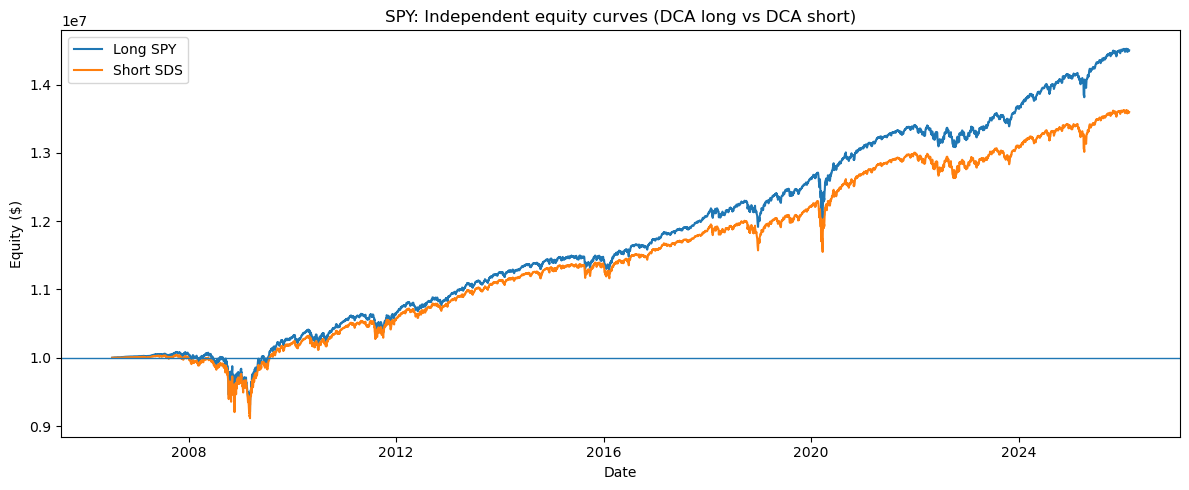

QQQ      LONG  | CAGR 2.1% | Vol 2.1% | MaxDD -2.8% | Sharpe 1.00 | RebalDays 124 | Borrow $0
QQQ      SHORT | CAGR 1.9% | Vol 2.1% | MaxDD -3.0% | Sharpe 0.89 | RebalDays 0 | Borrow $129,941


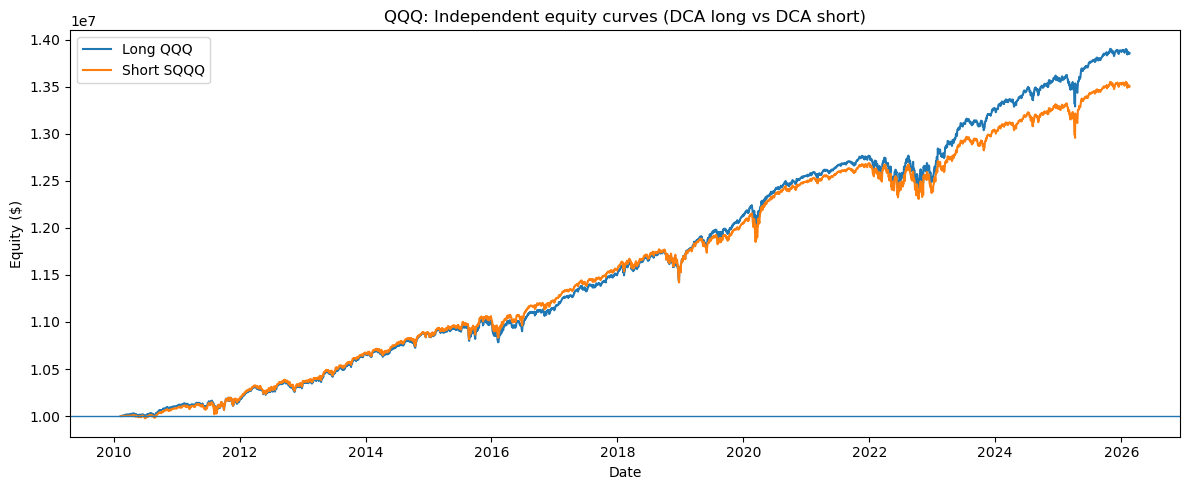

GLD      LONG  | CAGR 1.8% | Vol 9.0% | MaxDD -25.9% | Sharpe 0.25 | RebalDays 198 | Borrow $0
GLD      SHORT | CAGR 1.9% | Vol 8.7% | MaxDD -22.3% | Sharpe 0.26 | RebalDays 0 | Borrow $447,242


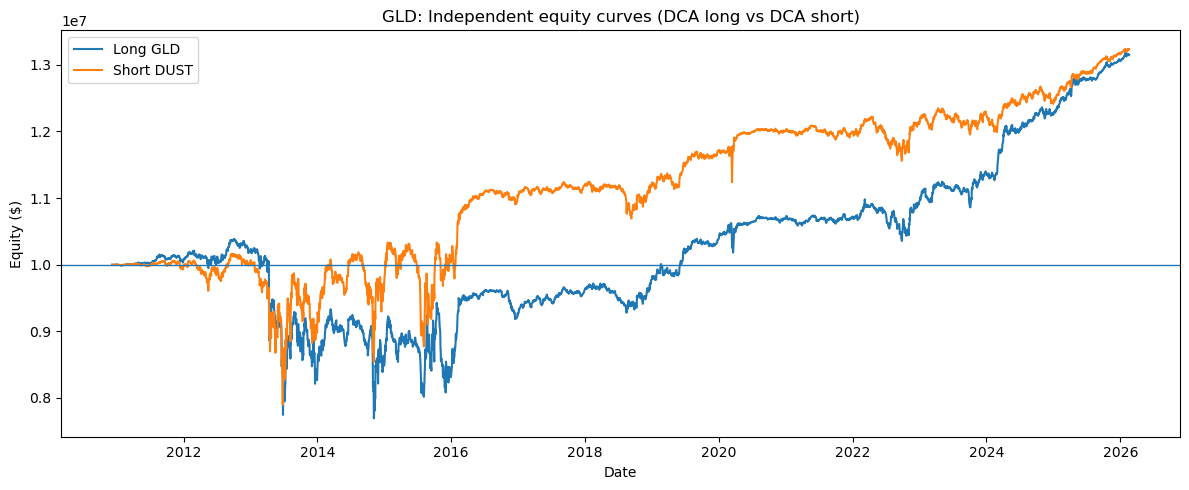

BIOTECH  LONG  | CAGR 2.0% | Vol 4.7% | MaxDD -10.3% | Sharpe 0.45 | RebalDays 148 | Borrow $0
BIOTECH  SHORT | CAGR 1.7% | Vol 4.7% | MaxDD -10.8% | Sharpe 0.39 | RebalDays 0 | Borrow $380,347


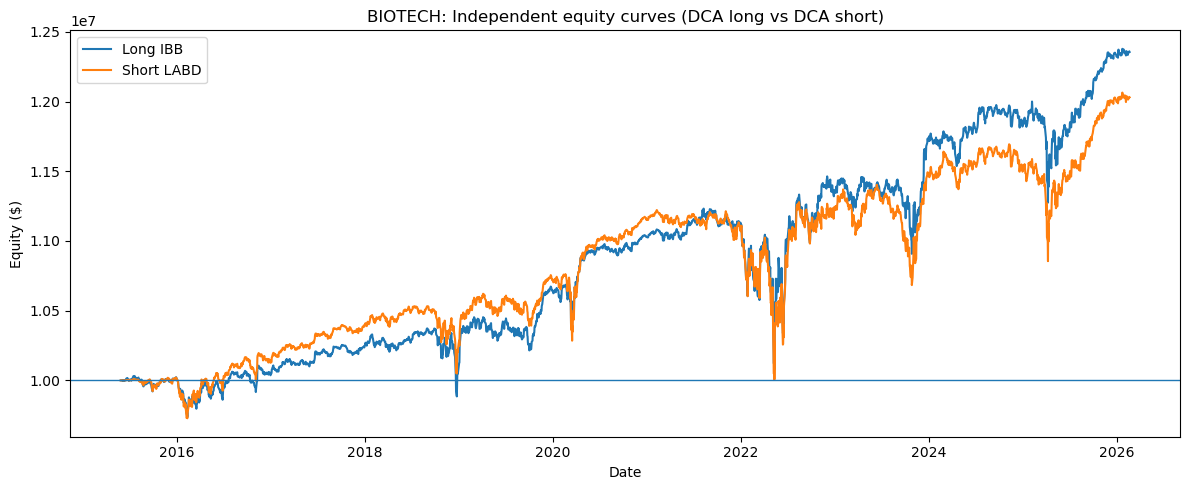

In [56]:
results = compare_long_vs_short_independent(
    px=px,
    borrow_annual_map=borrow_map,
    start_equity=10_000_000,
    daily_notional=1000.0,
    vol_window=60,
    band=0.25,
    borrow_day_count=360,
    plot=True,
    alpha=1.0,
)

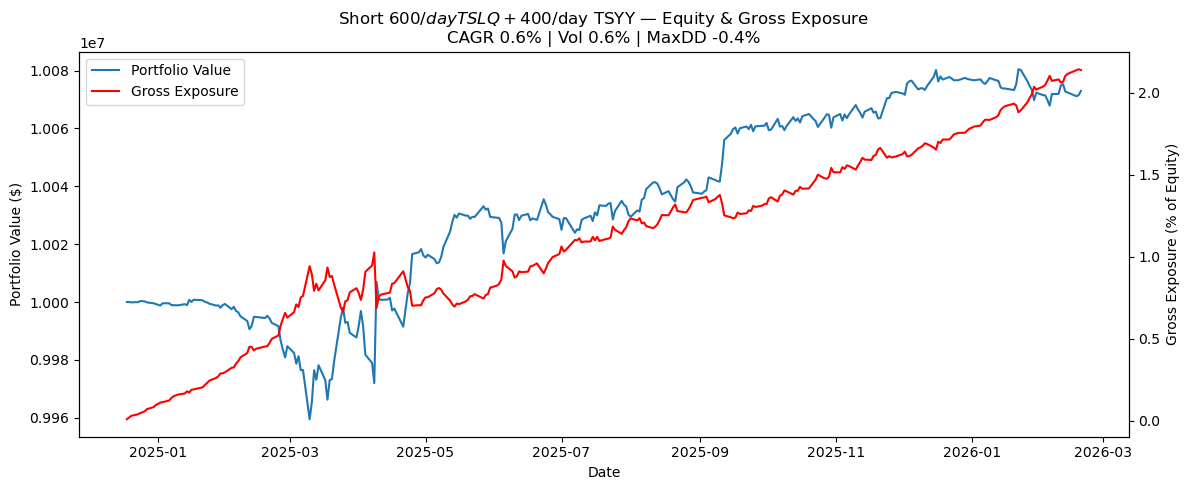

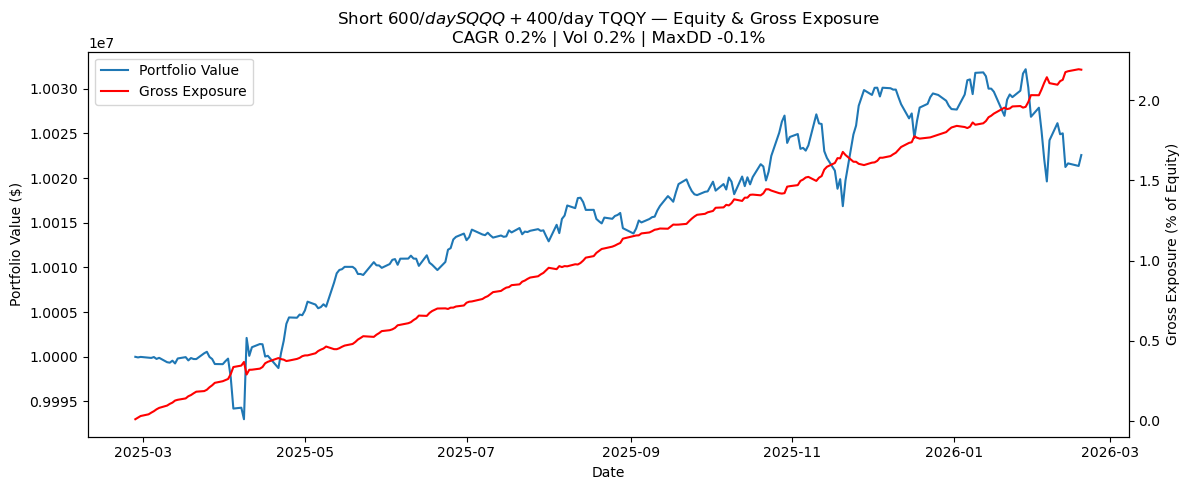

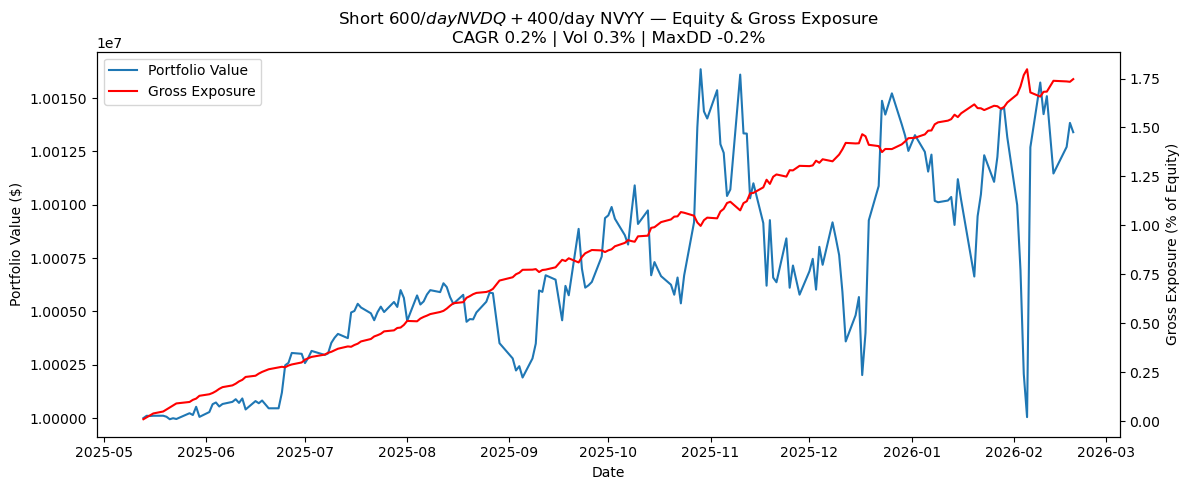

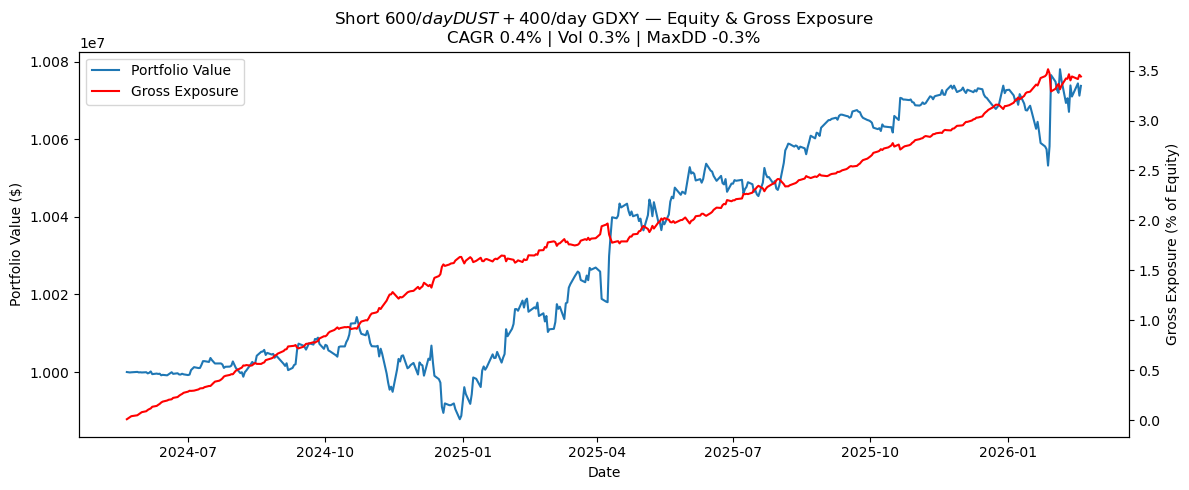

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

def _norm_sym(x: str) -> str:
    return str(x).upper().replace(".", "-")

def _borrow_daily(borrow_daily_map: dict[str, float], ticker: str, default_borrow_annual: float) -> float:
    t = _norm_sym(ticker)
    b = borrow_daily_map.get(t, np.nan)
    if np.isfinite(b):
        return float(b)
    return float(default_borrow_annual) / TRADING_DAYS


def perf_stats_from_returns(rets: pd.Series) -> dict:
    r = rets.dropna().astype(float)
    n = int(len(r))
    if n < 2:
        return {"TradingDays": n, "CAGR": np.nan, "AnnVol": np.nan, "MaxDD": np.nan}

    # equity curve (start at 1)
    wealth = (1.0 + r).cumprod()

    years = n / TRADING_DAYS
    cagr = float(wealth.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else np.nan
    ann_vol = float(r.std(ddof=1) * np.sqrt(TRADING_DAYS))

    peak = wealth.cummax()
    dd = wealth / peak - 1.0
    maxdd = float(dd.min())  # negative number

    return {"TradingDays": n, "CAGR": cagr, "AnnVol": ann_vol, "MaxDD": maxdd}


def backtest_daily_tranche_portfolio(
    *,
    tr_prices: pd.DataFrame,                      # columns like "TSLQ_TR"
    weights_daily_dollars: dict[str, float],      # {"TSLQ":600, "TSYY":400}
    borrow_daily_map: dict[str, float],
    backtest_start: str | None = None,
    portfolio_equity: float = 10_000_000.0,
    default_borrow_annual: float = 0.10,
) -> dict:
    """
    Daily ladder portfolio:
      - Each day, for each ticker, short $weights_daily_dollars[ticker] at close.
      - Shares accumulate. No rebalancing.
      - PnL from accumulated shares across all tickers.
      - Borrow charged daily on prior close MV per ticker.

    Returns:
      equity_curve, returns, gross_notional_pct_equity, per_ticker_shares
    """
    px = tr_prices.copy()
    px.index = pd.to_datetime(px.index).tz_localize(None).normalize()
    if backtest_start is not None:
        px = px.loc[px.index >= pd.Timestamp(backtest_start)]
    if px.empty:
        raise ValueError("Price dataframe empty after date filter.")

    # normalize tickers and ensure columns exist
    w = { _norm_sym(k): float(v) for k, v in weights_daily_dollars.items() }
    cols = { t: f"{t}_TR" for t in w.keys() }
    missing = [t for t,c in cols.items() if c not in px.columns]
    if missing:
        raise ValueError(f"Missing TR columns for: {missing}")

    # align on common dates across all tickers
    df = px[[cols[t] for t in w.keys()]].dropna().copy()
    if df.empty or len(df) < 50:
        raise ValueError("Not enough overlapping data among tickers.")

    idx = df.index
    equity = float(portfolio_equity)
    shares = {t: 0.0 for t in w.keys()}  # accumulated short shares per ticker (negative)

    rets  = pd.Series(index=idx, dtype=float)
    curve = pd.Series(index=idx, dtype=float)
    gross = pd.Series(index=idx, dtype=float)

    peak = equity
    prev = None

    for dt in idx:
        # add today's tranches at today's close
        for t in w.keys():
            p = float(df.at[dt, cols[t]])
            if np.isfinite(p) and p > 0:
                shares[t] += -w[t] / p

        if prev is None:
            curve.at[dt] = equity
            rets.at[dt]  = 0.0
            # gross at today's close
            g = 0.0
            for t in w.keys():
                p = float(df.at[dt, cols[t]])
                g += abs(shares[t]) * p
            gross.at[dt] = g / equity if equity > 0 else np.nan
            prev = dt
            continue

        # pnl from prev->dt across tickers
        pnl = 0.0
        gmv_prev = 0.0
        gmv_now  = 0.0

        for t in w.keys():
            p0 = float(df.at[prev, cols[t]])
            p1 = float(df.at[dt,   cols[t]])
            if not (np.isfinite(p0) and np.isfinite(p1) and p0 > 0):
                continue

            sh = shares[t]
            pnl += sh * (p1 - p0)

            # borrow on prior close MV
            bday = _borrow_daily(borrow_daily_map, t, default_borrow_annual)
            pnl -= abs(sh) * p0 * float(bday)

            gmv_prev += abs(sh) * p0
            gmv_now  += abs(sh) * p1

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        peak = max(peak, equity)

        curve.at[dt] = equity
        rets.at[dt]  = r
        gross.at[dt] = gmv_now / equity if equity > 0 else np.nan

        prev = dt

    out = {
        "returns": rets.dropna(),
        "equity_curve": curve.dropna(),
        "gross_notional_pct_equity": gross.dropna(),
        "shares": pd.DataFrame({t: pd.Series(shares[t], index=[idx[-1]]) for t in shares}).iloc[0].to_dict(),
    }
    return out

def plot_equity_and_gross(
    res: dict,
    *,
    title: str,
    figsize=(12,5),
):
    equity = res["equity_curve"].dropna()
    gross  = res["gross_notional_pct_equity"].dropna()
    rets   = res.get("returns", pd.Series(dtype=float)).dropna()

    common = equity.index.intersection(gross.index)
    equity = equity.loc[common]
    gross  = gross.loc[common]
    if not rets.empty:
        rets = rets.loc[rets.index.intersection(common)]

    st = perf_stats_from_returns(rets) if not rets.empty else {"CAGR": np.nan, "AnnVol": np.nan, "MaxDD": np.nan}

    cagr_s = f"{100*st['CAGR']:.1f}%" if np.isfinite(st["CAGR"]) else "n/a"
    vol_s  = f"{100*st['AnnVol']:.1f}%" if np.isfinite(st["AnnVol"]) else "n/a"
    mdd_s  = f"{100*st['MaxDD']:.1f}%" if np.isfinite(st["MaxDD"]) else "n/a"

    fig, ax1 = plt.subplots(figsize=figsize)

    ax1.plot(equity.index, equity.values, label="Portfolio Value")
    ax1.set_ylabel("Portfolio Value ($)")
    ax1.set_xlabel("Date")

    ax2 = ax1.twinx()
    ax2.plot(gross.index, 100.0 * gross.values, label="Gross Exposure", color="red")
    ax2.set_ylabel("Gross Exposure (% of Equity)")

    # single combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left", frameon=True)

    # Title + stats line
    ax1.set_title(f"{title}\nCAGR {cagr_s} | Vol {vol_s} | MaxDD {mdd_s}")

    plt.tight_layout()
    plt.show()


# Basket A: TSLA
tsla_weights = {"TSLQ": 600, "TSYY": 400}

# Basket B: QQQ
qqq_weights  = {"SQQQ": 600, "TQQY": 400}

nvda_weights  = {"NVDQ": 600, "NVYY": 400}

gld_weights  = {"DUST": 600, "GDXY": 400}

def ensure_tr_columns(prices_tr: pd.DataFrame, tickers: list[str], start="1900-01-01") -> pd.DataFrame:
    """
    Ensures {TICKER}_TR exists in prices_tr for each ticker.
    If missing, downloads from yfinance and merges.
    """
    tickers = [_norm_sym(t) for t in tickers]
    need = [t for t in tickers if f"{t}_TR" not in prices_tr.columns]

    if not need:
        return prices_tr

    add = build_prices_tr_from_yf(need, start=start)  # uses your function
    merged = prices_tr.join(add, how="outer").sort_index()
    return merged

need_all = list(tsla_weights.keys()) + list(qqq_weights.keys()) + list(nvda_weights.keys()) + list(gld_weights.keys())
prices = ensure_tr_columns(prices, need_all, start="1900-01-01")


# Run backtests (requires `prices` and `borrow_daily_map` already defined)
res_tsla = backtest_daily_tranche_portfolio(
    tr_prices=prices,
    weights_daily_dollars=tsla_weights,
    borrow_daily_map=borrow_daily_map,
    backtest_start=None,
    portfolio_equity=10_000_000.0,
    default_borrow_annual=default_override if "default_override" in globals() else 0.10,
)

res_qqq = backtest_daily_tranche_portfolio(
    tr_prices=prices,
    weights_daily_dollars=qqq_weights,
    borrow_daily_map=borrow_daily_map,
    backtest_start=None,
    portfolio_equity=10_000_000.0,
    default_borrow_annual=default_override if "default_override" in globals() else 0.10,
)

res_nvda = backtest_daily_tranche_portfolio(
    tr_prices=prices,
    weights_daily_dollars=nvda_weights,
    borrow_daily_map=borrow_daily_map,
    backtest_start=None,
    portfolio_equity=10_000_000.0,
    default_borrow_annual=default_override if "default_override" in globals() else 0.10,
)

res_gld = backtest_daily_tranche_portfolio(
    tr_prices=prices,
    weights_daily_dollars=gld_weights,
    borrow_daily_map=borrow_daily_map,
    backtest_start=None,
    portfolio_equity=10_000_000.0,
    default_borrow_annual=default_override if "default_override" in globals() else 0.10,
)

plot_equity_and_gross(res_tsla, title="Short $600/day TSLQ + $400/day TSYY — Equity & Gross Exposure")
plot_equity_and_gross(res_qqq,  title="Short $600/day SQQQ + $400/day TQQY — Equity & Gross Exposure")
plot_equity_and_gross(res_nvda,  title="Short $600/day NVDQ + $400/day NVYY — Equity & Gross Exposure")
plot_equity_and_gross(res_gld,  title="Short $600/day DUST + $400/day GDXY — Equity & Gross Exposure")

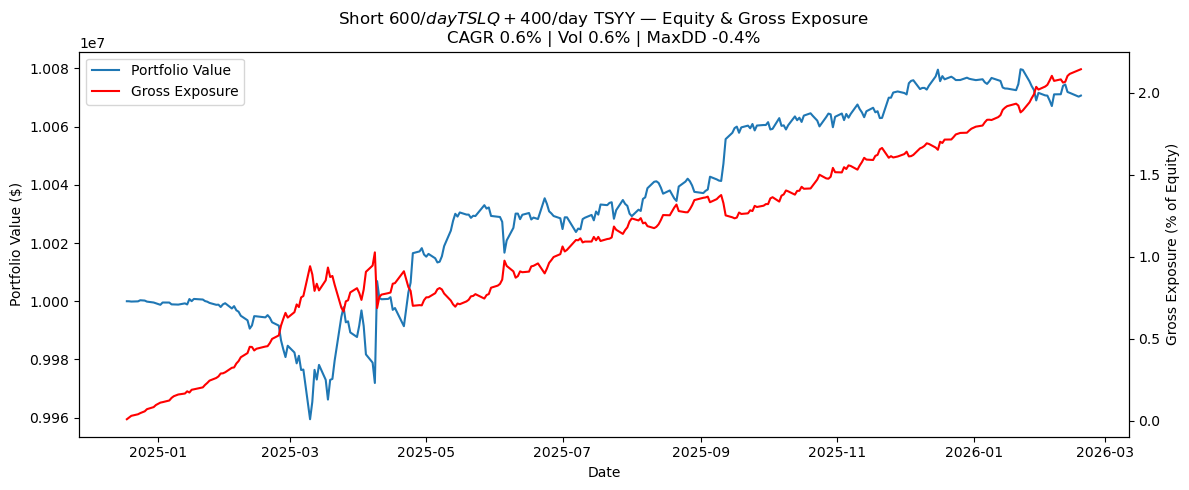

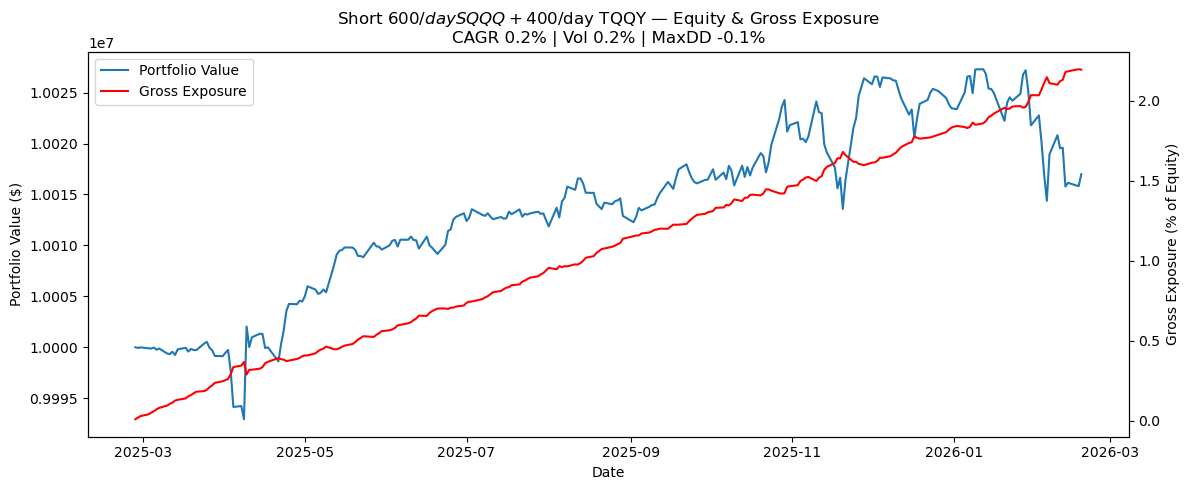

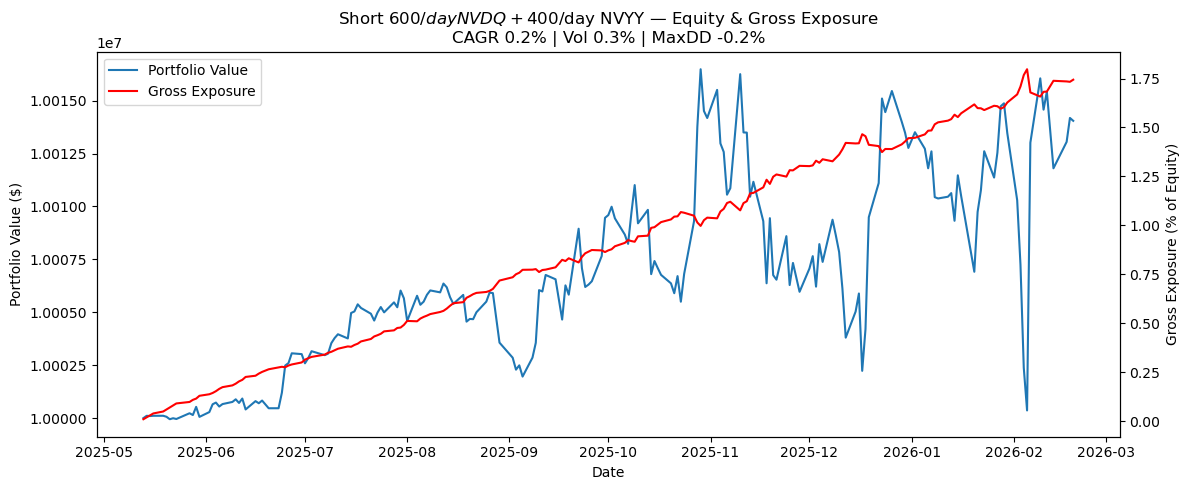

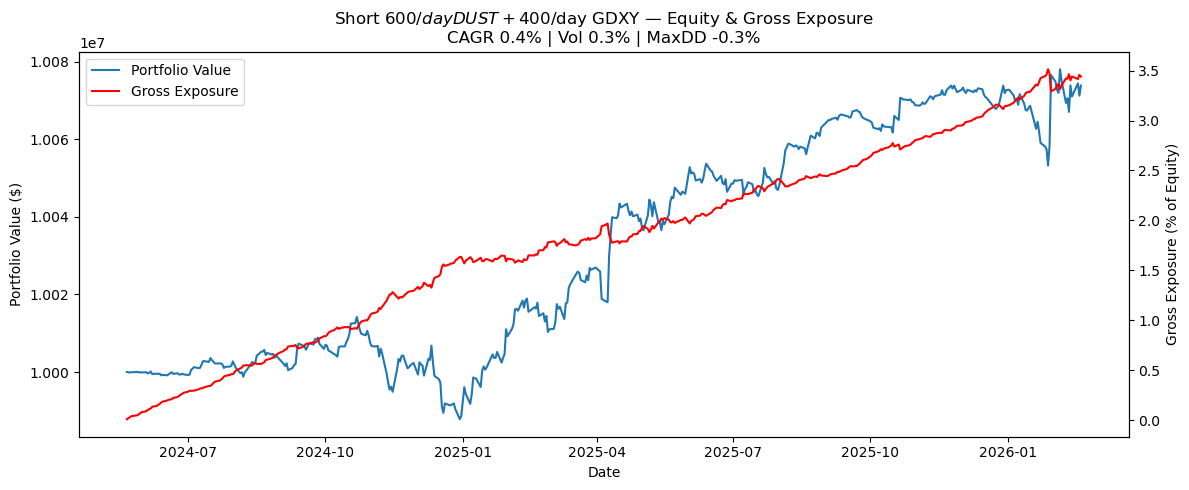

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

def _norm_sym(x: str) -> str:
    return str(x).upper().replace(".", "-")

def _borrow_daily(borrow_daily_map: dict[str, float], ticker: str, default_borrow_annual: float) -> float:
    t = _norm_sym(ticker)
    b = borrow_daily_map.get(t, np.nan)
    if np.isfinite(b):
        return float(b)
    return float(default_borrow_annual) / TRADING_DAYS


def perf_stats_from_returns(rets: pd.Series) -> dict:
    r = rets.dropna().astype(float)
    n = int(len(r))
    if n < 2:
        return {"TradingDays": n, "CAGR": np.nan, "AnnVol": np.nan, "MaxDD": np.nan}

    # equity curve (start at 1)
    wealth = (1.0 + r).cumprod()

    years = n / TRADING_DAYS
    cagr = float(wealth.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else np.nan
    ann_vol = float(r.std(ddof=1) * np.sqrt(TRADING_DAYS))

    peak = wealth.cummax()
    dd = wealth / peak - 1.0
    maxdd = float(dd.min())  # negative number

    return {"TradingDays": n, "CAGR": cagr, "AnnVol": ann_vol, "MaxDD": maxdd}


def backtest_daily_tranche_portfolio(
    *,
    tr_prices: pd.DataFrame,                      # columns like "TSLQ_TR"
    weights_daily_dollars: dict[str, float],      # {"TSLQ":600, "TSYY":400}
    borrow_daily_map: dict[str, float],
    backtest_start: str | None = None,
    portfolio_equity: float = 10_000_000.0,
    default_borrow_annual: float = 0.10,
) -> dict:
    """
    Daily ladder portfolio:
      - Each day, for each ticker, short $weights_daily_dollars[ticker] at close.
      - Shares accumulate. No rebalancing.
      - PnL from accumulated shares across all tickers.
      - Borrow charged daily on prior close MV per ticker.

    Returns:
      equity_curve, returns, gross_notional_pct_equity, per_ticker_shares
    """
    px = tr_prices.copy()
    px.index = pd.to_datetime(px.index).tz_localize(None).normalize()
    if backtest_start is not None:
        px = px.loc[px.index >= pd.Timestamp(backtest_start)]
    if px.empty:
        raise ValueError("Price dataframe empty after date filter.")

    # normalize tickers and ensure columns exist
    w = { _norm_sym(k): float(v) for k, v in weights_daily_dollars.items() }
    cols = { t: f"{t}_TR" for t in w.keys() }
    missing = [t for t,c in cols.items() if c not in px.columns]
    if missing:
        raise ValueError(f"Missing TR columns for: {missing}")

    # align on common dates across all tickers
    df = px[[cols[t] for t in w.keys()]].dropna().copy()
    if df.empty or len(df) < 50:
        raise ValueError("Not enough overlapping data among tickers.")

    idx = df.index
    equity = float(portfolio_equity)
    shares = {t: 0.0 for t in w.keys()}  # accumulated short shares per ticker (negative)

    rets  = pd.Series(index=idx, dtype=float)
    curve = pd.Series(index=idx, dtype=float)
    gross = pd.Series(index=idx, dtype=float)

    peak = equity
    prev = None

    for dt in idx:
        # add today's tranches at today's close
        for t in w.keys():
            p = float(df.at[dt, cols[t]])
            if np.isfinite(p) and p > 0:
                shares[t] += -w[t] / p

        if prev is None:
            curve.at[dt] = equity
            rets.at[dt]  = 0.0
            # gross at today's close
            g = 0.0
            for t in w.keys():
                p = float(df.at[dt, cols[t]])
                g += abs(shares[t]) * p
            gross.at[dt] = g / equity if equity > 0 else np.nan
            prev = dt
            continue

        # pnl from prev->dt across tickers
        pnl = 0.0
        gmv_prev = 0.0
        gmv_now  = 0.0

        for t in w.keys():
            p0 = float(df.at[prev, cols[t]])
            p1 = float(df.at[dt,   cols[t]])
            if not (np.isfinite(p0) and np.isfinite(p1) and p0 > 0):
                continue

            sh = shares[t]
            pnl += sh * (p1 - p0)

            # borrow on prior close MV
            bday = _borrow_daily(borrow_daily_map, t, default_borrow_annual)
            pnl -= abs(sh) * p0 * float(bday)

            gmv_prev += abs(sh) * p0
            gmv_now  += abs(sh) * p1

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        peak = max(peak, equity)

        curve.at[dt] = equity
        rets.at[dt]  = r
        gross.at[dt] = gmv_now / equity if equity > 0 else np.nan

        prev = dt

    out = {
        "returns": rets.dropna(),
        "equity_curve": curve.dropna(),
        "gross_notional_pct_equity": gross.dropna(),
        "shares": pd.DataFrame({t: pd.Series(shares[t], index=[idx[-1]]) for t in shares}).iloc[0].to_dict(),
    }
    return out

def plot_equity_and_gross(
    res: dict,
    *,
    title: str,
    figsize=(12,5),
):
    equity = res["equity_curve"].dropna()
    gross  = res["gross_notional_pct_equity"].dropna()
    rets   = res.get("returns", pd.Series(dtype=float)).dropna()

    common = equity.index.intersection(gross.index)
    equity = equity.loc[common]
    gross  = gross.loc[common]
    if not rets.empty:
        rets = rets.loc[rets.index.intersection(common)]

    st = perf_stats_from_returns(rets) if not rets.empty else {"CAGR": np.nan, "AnnVol": np.nan, "MaxDD": np.nan}

    cagr_s = f"{100*st['CAGR']:.1f}%" if np.isfinite(st["CAGR"]) else "n/a"
    vol_s  = f"{100*st['AnnVol']:.1f}%" if np.isfinite(st["AnnVol"]) else "n/a"
    mdd_s  = f"{100*st['MaxDD']:.1f}%" if np.isfinite(st["MaxDD"]) else "n/a"

    fig, ax1 = plt.subplots(figsize=figsize)

    ax1.plot(equity.index, equity.values, label="Portfolio Value")
    ax1.set_ylabel("Portfolio Value ($)")
    ax1.set_xlabel("Date")

    ax2 = ax1.twinx()
    ax2.plot(gross.index, 100.0 * gross.values, label="Gross Exposure", color="red")
    ax2.set_ylabel("Gross Exposure (% of Equity)")

    # single combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left", frameon=True)

    # Title + stats line
    ax1.set_title(f"{title}\nCAGR {cagr_s} | Vol {vol_s} | MaxDD {mdd_s}")

    plt.tight_layout()
    plt.show()


# Basket A: TSLA
tsla_weights = {"TSLQ": 600, "TSYY": 400}

# Basket B: QQQ
qqq_weights  = {"SQQQ": 600, "TQQY": 400}

nvda_weights  = {"NVDQ": 600, "NVYY": 400}

gld_weights  = {"DUST": 600, "GDXY": 400}

def ensure_tr_columns(prices_tr: pd.DataFrame, tickers: list[str], start="1900-01-01") -> pd.DataFrame:
    """
    Ensures {TICKER}_TR exists in prices_tr for each ticker.
    If missing, downloads from yfinance and merges.
    """
    tickers = [_norm_sym(t) for t in tickers]
    need = [t for t in tickers if f"{t}_TR" not in prices_tr.columns]

    if not need:
        return prices_tr

    add = build_prices_tr_from_yf(need, start=start)  # uses your function
    merged = prices_tr.join(add, how="outer").sort_index()
    return merged

need_all = list(tsla_weights.keys()) + list(qqq_weights.keys()) + list(nvda_weights.keys()) + list(gld_weights.keys())
prices = ensure_tr_columns(prices, need_all, start="1900-01-01")


# Run backtests (requires `prices` and `borrow_daily_map` already defined)
res_tsla = backtest_daily_tranche_portfolio(
    tr_prices=prices,
    weights_daily_dollars=tsla_weights,
    borrow_daily_map=borrow_daily_map,
    backtest_start=None,
    portfolio_equity=10_000_000.0,
    default_borrow_annual=default_override if "default_override" in globals() else 0.10,
)

res_qqq = backtest_daily_tranche_portfolio(
    tr_prices=prices,
    weights_daily_dollars=qqq_weights,
    borrow_daily_map=borrow_daily_map,
    backtest_start=None,
    portfolio_equity=10_000_000.0,
    default_borrow_annual=default_override if "default_override" in globals() else 0.10,
)

res_nvda = backtest_daily_tranche_portfolio(
    tr_prices=prices,
    weights_daily_dollars=nvda_weights,
    borrow_daily_map=borrow_daily_map,
    backtest_start=None,
    portfolio_equity=10_000_000.0,
    default_borrow_annual=default_override if "default_override" in globals() else 0.10,
)

res_gld = backtest_daily_tranche_portfolio(
    tr_prices=prices,
    weights_daily_dollars=gld_weights,
    borrow_daily_map=borrow_daily_map,
    backtest_start=None,
    portfolio_equity=10_000_000.0,
    default_borrow_annual=default_override if "default_override" in globals() else 0.10,
)

plot_equity_and_gross(res_tsla, title="Short $600/day TSLQ + $400/day TSYY — Equity & Gross Exposure")
plot_equity_and_gross(res_qqq,  title="Short $600/day SQQQ + $400/day TQQY — Equity & Gross Exposure")
plot_equity_and_gross(res_nvda,  title="Short $600/day NVDQ + $400/day NVYY — Equity & Gross Exposure")
plot_equity_and_gross(res_gld,  title="Short $600/day DUST + $400/day GDXY — Equity & Gross Exposure")

In [58]:
import numpy as np
import pandas as pd

# ============================================================
# CONFIG
# ============================================================
TRADING_DAYS = 252

# ============================================================
# Helpers
# ============================================================
def _norm_sym(x: str) -> str:
    return str(x).upper().replace(".", "-")

def _to_tr_col(ticker: str) -> str:
    return f"{_norm_sym(ticker)}_TR"

def _simple_to_log_annual(b_simple: float) -> float:
    """APR (simple) -> continuous annual."""
    b_simple = float(b_simple)
    if not np.isfinite(b_simple) or b_simple <= -1.0:
        return np.nan
    return float(np.log1p(b_simple))

def _log_to_simple_annual(x_log: float) -> float:
    """continuous annual -> simple annual."""
    if x_log is None or not np.isfinite(x_log):
        return np.nan
    return float(np.expm1(x_log))

def _prep_pair_df(prices_tr: pd.DataFrame, inv: str, bmk: str, start=None, end=None) -> pd.DataFrame:
    inv_col = _to_tr_col(inv)
    bmk_col = _to_tr_col(bmk)
    if inv_col not in prices_tr.columns:
        raise ValueError(f"Missing {inv_col}")
    if bmk_col not in prices_tr.columns:
        raise ValueError(f"Missing {bmk_col}")

    df = pd.concat([prices_tr[inv_col], prices_tr[bmk_col]], axis=1, join="inner").dropna()
    df.columns = ["INV_TR", "BMK_TR"]
    df.index = pd.to_datetime(df.index).tz_localize(None).normalize()
    df = df.sort_index()
    if start is not None:
        df = df.loc[df.index >= pd.Timestamp(start)]
    if end is not None:
        df = df.loc[df.index <= pd.Timestamp(end)]
    if len(df) < 50:
        raise ValueError("Not enough overlapping data.")
    return df

def _max_drawdown(wealth: np.ndarray) -> float:
    """
    wealth: positive array
    returns max drawdown as a fraction (e.g., 0.25 = -25% peak-to-trough)
    """
    w = np.asarray(wealth, dtype=float)
    if w.size == 0 or np.any(w <= 0) or not np.isfinite(w).all():
        return np.nan
    peak = np.maximum.accumulate(w)
    dd = 1.0 - (w / peak)
    return float(np.max(dd))

# ============================================================
# Stahl-style "decay yield" vs borrow (log-space, apples-to-apples)
# ============================================================
def stahl_decay_metrics_one(
    *,
    prices_tr: pd.DataFrame,
    inverse_etf: str,
    benchmark: str,
    leverage: float,
    borrow_annual_simple: float,
    start: str | None = None,
    end: str | None = None,
) -> dict:
    """
    Defines "true decay" as the average DAILY LOG underperformance of the ETF
    relative to a clean constant-leverage inverse comparator:

        decay_log_daily_t = [ -L * log(1+r_bmk_t) ] - [ log(1+r_inv_t) ]

    Annualized decay yield (continuous):
        DecayYield_Log_Ann = mean(decay_log_daily) * 252

    Compare to borrow in the SAME units:
        Borrow_Log_Ann = log(1 + borrow_simple)

    Net headroom:
        NetYield_Log_Ann = DecayYield_Log_Ann - Borrow_Log_Ann
        NetYield_Simple_Ann = exp(NetYield_Log_Ann) - 1

    Vol-adjusted:
        Vol_Log_Ann = std(decay_log_daily) * sqrt(252)
        IR_Log = NetYield_Log_Ann / Vol_Log_Ann

    Drawdown-adjusted:
        Use net daily log series (subtract borrow daily in log space),
        build wealth = exp(cumsum(net_log_daily)), compute MaxDD,
        Calmar = NetYield_Simple_Ann / MaxDD
    """
    df = _prep_pair_df(prices_tr, inverse_etf, benchmark, start, end)

    inv = df["INV_TR"].astype(float)
    bmk = df["BMK_TR"].astype(float)

    r_inv = inv.pct_change().fillna(0.0).to_numpy()
    r_bmk = bmk.pct_change().fillna(0.0).to_numpy()

    L = float(leverage)

    # daily log returns
    log_inv = np.log1p(r_inv)
    log_bmk = np.log1p(r_bmk)

    # "clean" constant-leverage inverse comparator log return
    log_const = -L * log_bmk

    # TRUE DECAY: comparator - ETF (positive = ETF underperforms = good to short)
    decay_log_daily = log_const - log_inv

    n = int(decay_log_daily.size)
    years = n / TRADING_DAYS

    decay_log_ann = float(np.mean(decay_log_daily) * TRADING_DAYS)
    decay_simple_ann = _log_to_simple_annual(decay_log_ann)

    borrow_simple = float(borrow_annual_simple)
    borrow_log_ann = _simple_to_log_annual(borrow_simple)
    borrow_log_daily = borrow_log_ann / TRADING_DAYS if np.isfinite(borrow_log_ann) else np.nan

    net_log_ann = float(decay_log_ann - borrow_log_ann) if np.isfinite(borrow_log_ann) else np.nan
    net_simple_ann = _log_to_simple_annual(net_log_ann)

    vol_log_ann = float(np.std(decay_log_daily, ddof=1) * np.sqrt(TRADING_DAYS)) if n > 1 else np.nan
    ir_log = float(net_log_ann / vol_log_ann) if (np.isfinite(net_log_ann) and np.isfinite(vol_log_ann) and vol_log_ann > 0) else np.nan

    # Drawdown on net series (DCA-style: treat net daily log yield as the "carry stream")
    if np.isfinite(borrow_log_daily):
        net_log_daily = decay_log_daily - borrow_log_daily
        wealth = np.exp(np.cumsum(net_log_daily))
        mdd = _max_drawdown(wealth)
    else:
        wealth = np.array([])
        mdd = np.nan

    calmar = float(net_simple_ann / mdd) if (np.isfinite(net_simple_ann) and np.isfinite(mdd) and mdd > 0) else np.nan

    # For convenience: linearized headroom (close when small)
    headroom_simple_approx = float(decay_simple_ann - borrow_simple) if (np.isfinite(decay_simple_ann) and np.isfinite(borrow_simple)) else np.nan

    return {
        "InverseETF": _norm_sym(inverse_etf),
        "Benchmark": _norm_sym(benchmark),
        "Leverage": L,
        "Start": str(df.index.min().date()),
        "End": str(df.index.max().date()),
        "TradingDays": n,
        "Years": float(years),

        # "True decay" yield
        "DecayYield_Log_Ann": decay_log_ann,              # continuous annual
        "DecayYield_Simple_Ann": decay_simple_ann,        # simple annual equivalent

        # Borrow in same units
        "Borrow_Simple_Ann": borrow_simple,
        "Borrow_Log_Ann": borrow_log_ann,

        # Net headroom / profitability
        "NetYield_Log_Ann": net_log_ann,
        "NetYield_Simple_Ann": net_simple_ann,
        "Headroom_Simple_Approx": headroom_simple_approx,

        # Risk adjustments
        "Vol_Log_Ann": vol_log_ann,
        "IR_Log": ir_log,                                 # vol-adjusted (information ratio style)
        "MaxDD_Net": mdd,                                  # drawdown of net daily log series
        "Calmar_Net": calmar,                              # drawdown-adjusted
    }

def stahl_rank_universe(
    *,
    universe: pd.DataFrame,     # columns: InverseETF, Benchmark, Leverage
    prices_tr: pd.DataFrame,
    borrow_annual_map: dict[str, float] | None = None,  # {"SQQQ":0.18,"default":0.10}
    start: str | None = None,
    end: str | None = None,
) -> pd.DataFrame:
    borrow_annual_map = borrow_annual_map or {}
    b_default = float(borrow_annual_map.get("default", 0.0))

    rows = []
    for _, r in universe.iterrows():
        inv = r["InverseETF"]
        bmk = r["Benchmark"]
        L   = float(r["Leverage"])
        inv_norm = _norm_sym(inv)
        bor = float(borrow_annual_map.get(inv_norm, b_default))

        try:
            rows.append(stahl_decay_metrics_one(
                prices_tr=prices_tr,
                inverse_etf=inv,
                benchmark=bmk,
                leverage=L,
                borrow_annual_simple=bor,
                start=start,
                end=end,
            ))
        except Exception:
            continue

    out = pd.DataFrame(rows)
    if out.empty:
        return out

    # Rankings (higher is better)
    out["Rank_Headroom"] = out["NetYield_Simple_Ann"].rank(ascending=False, method="min")
    out["Rank_VolAdj"]   = out["IR_Log"].rank(ascending=False, method="min")
    out["Rank_DDAdj"]    = out["Calmar_Net"].rank(ascending=False, method="min")

    # A combined score (optional): average rank across the 3 lenses
    out["Rank_Composite"] = (out["Rank_Headroom"] + out["Rank_VolAdj"] + out["Rank_DDAdj"]) / 3.0

    # Default sort: best “decay minus borrow”
    out = out.sort_values(
        ["NetYield_Simple_Ann", "IR_Log", "Calmar_Net"],
        ascending=[False, False, False],
    ).reset_index(drop=True)

    return out

In [59]:
import numpy as np
import pandas as pd

TRADING_DAYS = 252

# --- keep all your helper functions + stahl_decay_metrics_one exactly as-is ---
# (paste your _norm_sym, _to_tr_col, _prep_pair_df, _max_drawdown,
#  _simple_to_log_annual, _log_to_simple_annual, stahl_decay_metrics_one here)

def stahl_rank_universe_dd_adjusted_by_ladder_csv(
    *,
    universe: pd.DataFrame,            # columns: InverseETF, Benchmark, Leverage
    prices_tr: pd.DataFrame,
    ladder_csv_path: str,              # e.g. "inverse_etf_daily_tranche_short_stats.csv"
    borrow_annual_map: dict[str, float] | None = None,  # {"SQQQ":0.18,"default":0.10}
    start: str | None = None,
    end: str | None = None,
) -> pd.DataFrame:
    borrow_annual_map = borrow_annual_map or {}
    b_default = float(borrow_annual_map.get("default", 0.0))

    # --- load ladder MaxDD from your CSV ---
    ladder = pd.read_csv(ladder_csv_path)
    ladder["ticker"] = ladder["ticker"].map(_norm_sym)
    ladder["MaxDD_Ladder"] = ladder["MaxDD"].astype(float)
    ladder["MaxDD_Ladder_abs"] = ladder["MaxDD_Ladder"].abs()

    dd_map = dict(zip(ladder["ticker"], ladder["MaxDD_Ladder_abs"]))

    rows = []
    for _, r in universe.iterrows():
        inv = r["InverseETF"]
        bmk = r["Benchmark"]
        L   = float(r["Leverage"])

        inv_norm = _norm_sym(inv)
        bor = float(borrow_annual_map.get(inv_norm, b_default))

        try:
            d = stahl_decay_metrics_one(
                prices_tr=prices_tr,
                inverse_etf=inv_norm,
                benchmark=bmk,
                leverage=L,
                borrow_annual_simple=bor,
                start=start,
                end=end,
            )
        except Exception:
            continue

        # --- override DD inputs with ladder CSV ---
        mdd_ladder = float(dd_map.get(inv_norm, np.nan))
        d["MaxDD_Net"] = mdd_ladder  # <-- REPLACED with ladder maxdd abs

        # recompute Calmar_Net using ladder MaxDD
        net_y = float(d.get("NetYield_Simple_Ann", np.nan))
        d["Calmar_Net"] = (net_y / mdd_ladder) if (np.isfinite(net_y) and np.isfinite(mdd_ladder) and mdd_ladder > 0) else np.nan

        rows.append(d)

    out = pd.DataFrame(rows)
    if out.empty:
        return out

    # --- rankings ---
    out["Rank_Headroom"] = out["NetYield_Simple_Ann"].rank(ascending=False, method="min")
    out["Rank_DDAdj"]    = out["Calmar_Net"].rank(ascending=False, method="min")  # <-- now DD-adjusted via CSV

    # return exactly the columns you requested, sorted by net yield then dd-adjusted
    cols = [
        "InverseETF","Benchmark","Leverage","TradingDays",
        "DecayYield_Simple_Ann","Borrow_Simple_Ann","NetYield_Simple_Ann",
        "IR_Log","MaxDD_Net","Calmar_Net",
        "Rank_Headroom","Rank_DDAdj",
    ]
    out = out.sort_values(["NetYield_Simple_Ann","Rank_DDAdj"], ascending=[False, True]).reset_index(drop=True)
    return out[cols]


# =========================
# USAGE
# =========================
borrow_annual_map = globals().get("borrow_annual_map", {"default": 0.10})

ranked_dd_adj = stahl_rank_universe_dd_adjusted_by_ladder_csv(
    universe=universe[["InverseETF","Benchmark","Leverage"]].copy(),
    prices_tr=prices,
    ladder_csv_path="inverse_etf_daily_tranche_short_stats.csv",
    borrow_annual_map=borrow_annual_map,
    start="2006-01-01",
    end=None,
)

ranked_dd_adj.head(50).sort_values("Rank_DDAdj", ascending=True)

InverseETF Benchmark  Leverage  TradingDays  DecayYield_Simple_Ann  \
0        CORD      CRWV       2.0          100              16.211871   
2        CRCD      CRCL       2.0          100               7.548688   
1        MSTZ      MSTR       2.0          356              12.043200   
3        ETHD      ETHA       2.0          396               3.760722   
5        NVDQ      NVDA       2.0          584               0.982459   
7        NVDS      NVDA       1.5          903               0.904716   
6        TSLQ      TSLA       2.0          903               0.928025   
4        BTCZ      IBIT       2.0          405               1.015268   
10       SOXS      SOXX       3.0         4010               0.707435   
8        LABD       XBI       3.0         2699               0.884710   
12       SQQQ       QQQ       3.0         4029               0.244727   
9        DUST       GDX       3.0         3821               0.784273   
11        TZA       IWM       3.0         4337               0.394544   
13       SPXS       SPY       3.0         4337               0.191392   
14        TWM       IWM       2.0         4798               0.185399   
15       SPXU       SPY       3.0         4188               0.144178   
16        QID       QQQ       2.0         4931               0.125062   
17        TMV       TLT       3.0         4237               0.113336   
19        TBT       TLT       2.0         4463               0.055560   
18        SDS       SPY       2.0         4931               0.077704   
20        TBX       TLT       2.0         3740              -0.037394   
21       TSXD      SOXX       2.0           95              -0.092010   

    Borrow_Simple_Ann  NetYield_Simple_Ann    IR_Log  MaxDD_Net   Calmar_Net  \
0                 0.1            14.647155  6.449902   0.009972  1468.834526   
2                 0.1             6.771534  8.690542   0.017246   392.652163   
1                 0.1            10.857454  5.936842   0.103448   104.955275   
3                 0.1             3.327929  6.757671   0.032903   101.144712   
5                 0.1             0.802236  4.076883   0.013492    59.458426   
7                 0.1             0.731560  0.634412   0.013407    54.564531   
6                 0.1             0.752750  1.248777   0.025860    29.108122   
4                 0.1             0.832062  5.675542   0.040272    20.661211   
10                0.1             0.552214  3.479248   0.034480    16.015654   
8                 0.1             0.713373  5.303340   0.110724     6.442818   
12                0.1             0.131570  2.036875   0.030235     4.351576   
9                 0.1             0.622067  1.569229   0.224513     2.770742   
11                0.1             0.267767  3.357093   0.122082     2.193334   
13                0.1             0.083083  1.369351   0.063798     1.302291   
14                0.1             0.077635  1.396876   0.107965     0.719079   
15                0.1             0.040162  0.762184   0.064353     0.624093   
16                0.1             0.022784  0.450664   0.075451     0.301969   
17                0.1             0.012123  0.329914   1.329771     0.009117   
19                0.1            -0.040400 -0.907491   0.644807    -0.062654   
18                0.1            -0.020269 -0.503237   0.093726    -0.216259   
20                0.1            -0.124903 -0.541762   0.187267    -0.666978   
21                0.1            -0.174555 -0.589915   0.001539  -113.433628   

    Rank_Headroom  Rank_DDAdj  
0             1.0         1.0  
2             3.0         2.0  
1             2.0         3.0  
3             4.0         4.0  
5             6.0         5.0  
7             8.0         6.0  
6             7.0         7.0  
4             5.0         8.0  
10           11.0         9.0  
8             9.0        10.0  
12           13.0        11.0  
9            10.0        12.0  
11           12.0        13.0  
13           14.0        14.0  
14

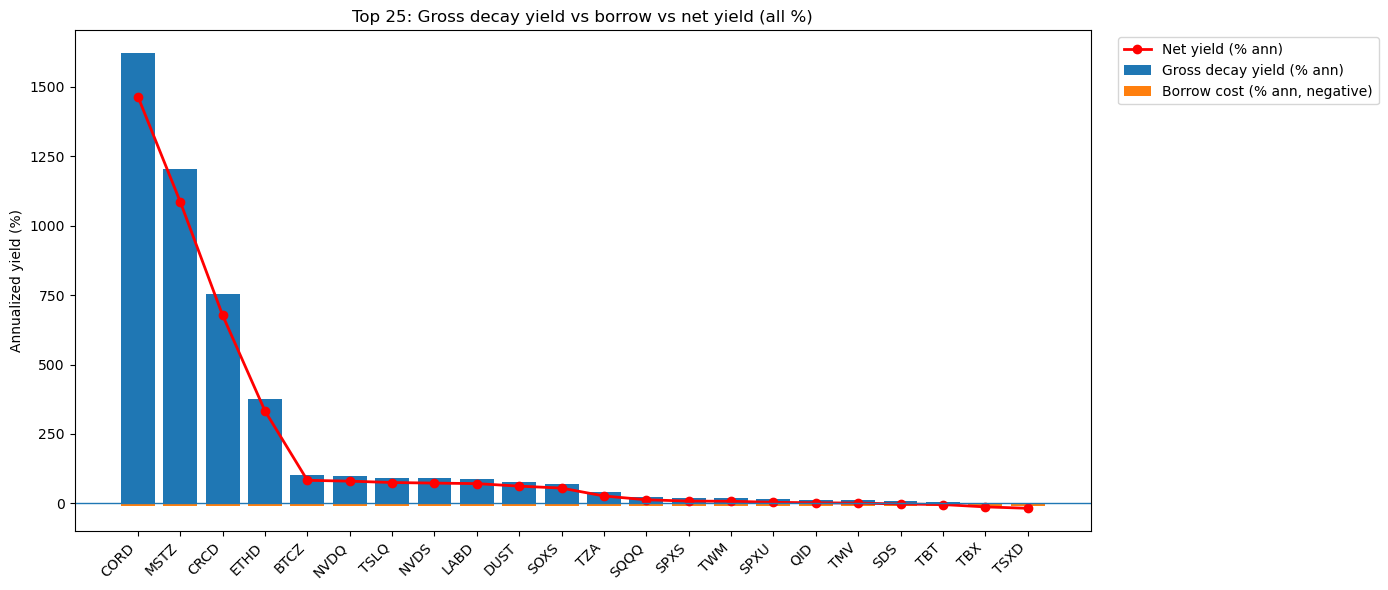

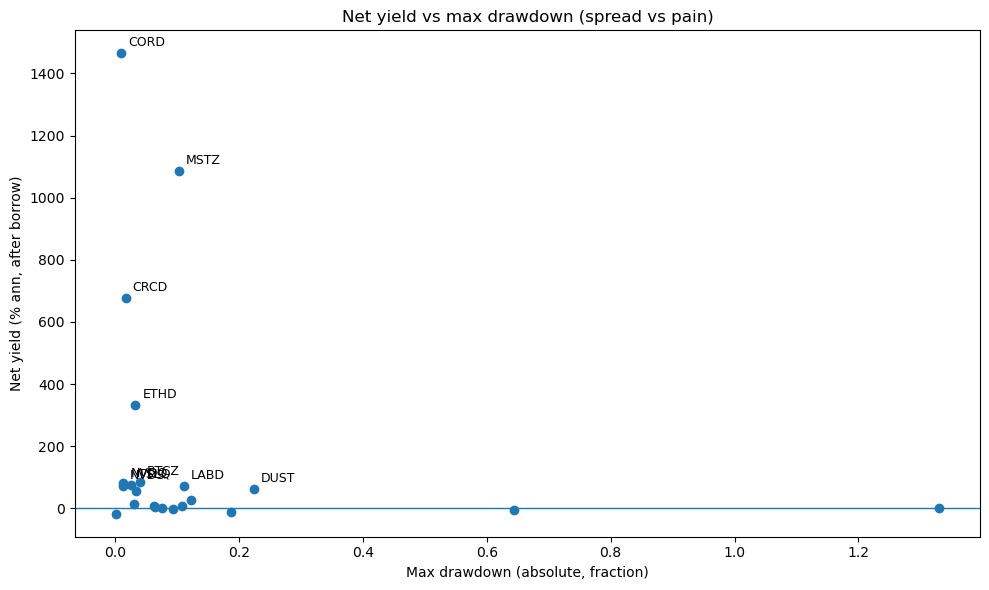

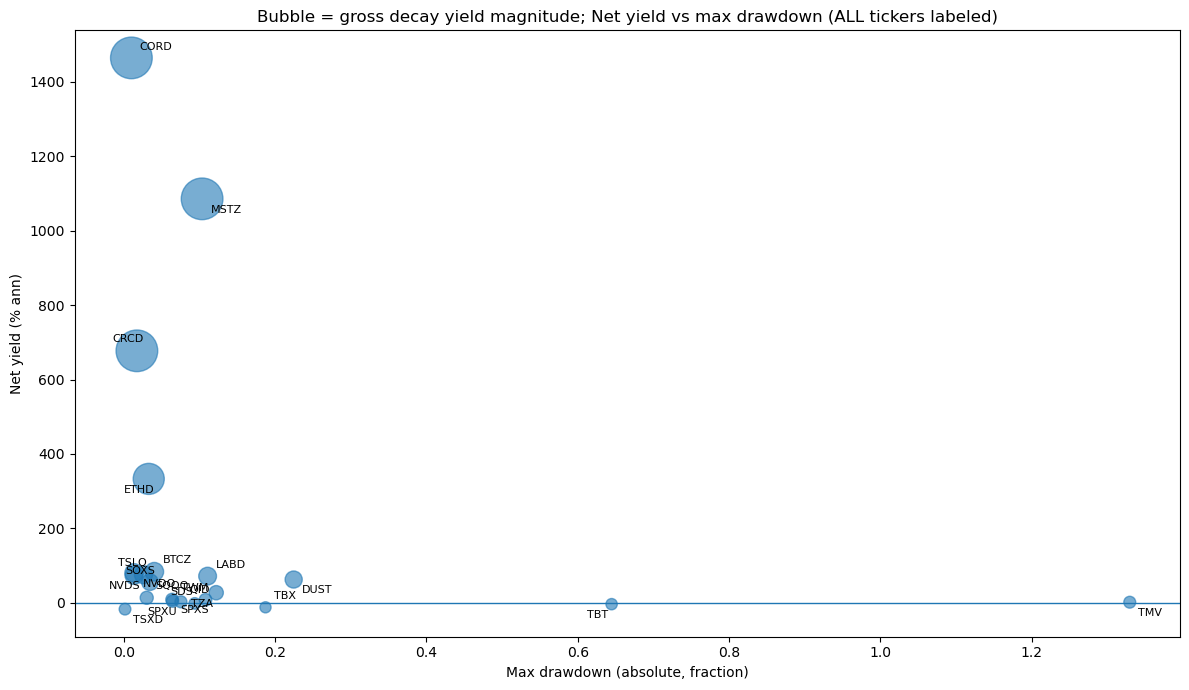

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================
# After you have `ranked`
# ==========================
df = ranked_dd_adj.copy()

# Make sure numeric
num_cols = [
    "DecayYield_Simple_Ann","Borrow_Simple_Ann","NetYield_Simple_Ann",
    "IR_Log","MaxDD_Net","Calmar_Net","TradingDays"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------
# Convert yields to %
# ---------
for c in ["DecayYield_Simple_Ann","Borrow_Simple_Ann","NetYield_Simple_Ann"]:
    if c in df.columns:
        df[c + "_pct"] = 100.0 * df[c]

df["MaxDD_abs"] = df["MaxDD_Net"].abs()

# Sort for readability (net spread)
df = df.sort_values("NetYield_Simple_Ann", ascending=False).reset_index(drop=True)

# --------------------------
# Plot 1: Gross vs Borrow vs Net (Top N)  [ALL IN %]
# --------------------------
TOPN = 25
d = df.head(TOPN).copy()

x = np.arange(len(d))
plt.figure(figsize=(14,6))

plt.bar(x, d["DecayYield_Simple_Ann_pct"].values, label="Gross decay yield (% ann)")
plt.bar(x, -d["Borrow_Simple_Ann_pct"].values, label="Borrow cost (% ann, negative)")
plt.plot(x, d["NetYield_Simple_Ann_pct"].values, marker="o", linewidth=2, label="Net yield (% ann)", color="red")

plt.axhline(0, linewidth=1)
plt.xticks(x, d["InverseETF"].values, rotation=45, ha="right")
plt.ylabel("Annualized yield (%)")
plt.title(f"Top {TOPN}: Gross decay yield vs borrow vs net yield (all %)")
plt.legend(loc="upper left", bbox_to_anchor=(1.02,1.0))
plt.tight_layout()
plt.show()

# --------------------------
# Plot 2: Net Yield vs Max Drawdown (all names)  [Y in %, X is DD fraction]
# --------------------------
plt.figure(figsize=(10,6))
plt.scatter(df["MaxDD_abs"], df["NetYield_Simple_Ann_pct"])

# label top 10 net yields
label_n = 10
for _, r in df.head(label_n).iterrows():
    plt.annotate(
        r["InverseETF"],
        (r["MaxDD_abs"], r["NetYield_Simple_Ann_pct"]),
        textcoords="offset points",
        xytext=(5,5),
        fontsize=9,
    )

plt.axhline(0, linewidth=1)
plt.xlabel("Max drawdown (absolute, fraction)")
plt.ylabel("Net yield (% ann, after borrow)")
plt.title("Net yield vs max drawdown (spread vs pain)")
plt.tight_layout()
plt.show()

# --------------------------
# Plot 3: Bubble chart (more readable) — label ALL tickers
# - y = net yield (%)
# - x = max drawdown (abs)
# - bubble size = gross decay yield magnitude (winsorized)
# --------------------------
gross_mag = np.abs(df["DecayYield_Simple_Ann"].values)
cap = np.nanpercentile(gross_mag, 90)  # tighter cap = less ridiculous bubbles
gross_mag = np.clip(gross_mag, 0, cap)

# rescale sizes into a tight readable range
smin, smax = 60, 900
if np.nanmax(gross_mag) > 0:
    sizes = smin + (smax - smin) * (gross_mag / np.nanmax(gross_mag))
else:
    sizes = np.full_like(gross_mag, smin, dtype=float)

plt.figure(figsize=(12,7))
plt.scatter(df["MaxDD_abs"], df["NetYield_Simple_Ann_pct"], s=sizes, alpha=0.6)

# label ALL tickers with alternating offsets to reduce overlap
offsets = [(6,6), (6,-10), (-18,6), (-18,-10)]
for i, r in df.iterrows():
    dx, dy = offsets[i % len(offsets)]
    plt.annotate(
        r["InverseETF"],
        (r["MaxDD_abs"], r["NetYield_Simple_Ann_pct"]),
        textcoords="offset points",
        xytext=(dx, dy),
        fontsize=8,
    )

plt.axhline(0, linewidth=1)
plt.xlabel("Max drawdown (absolute, fraction)")
plt.ylabel("Net yield (% ann)")
plt.title("Bubble = gross decay yield magnitude; Net yield vs max drawdown (ALL tickers labeled)")
plt.tight_layout()
plt.show()


In [61]:
# ============================================================
# PAIRWISE ANALYSIS (each ETF vs its underlying)
# - For EACH (ETF, Underlying) row:
#     * Long Underlying $ = equity (1.0x)
#     * Short ETF $       = equity / |Beta_used|
#     * Rebalance WEEKLY (fixed shares between rebalances)
#     * Charge borrow DAILY on prior-day short notional
# - DO NOT EXCLUDE any pairs
# - Save per-pair:
#     Return_total, CAGR, AnnVol, MaxDD, n_days, Beta_used, Borrow_annual
# - Plot bar chart sorted high -> low by CAGR
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05

def _safe_float(x):
    try:
        v = float(x)
        return v if np.isfinite(v) else np.nan
    except Exception:
        return np.nan

def choose_beta_used(row, beta_floor: float = 0.25) -> float:
    """
    Use Beta if finite and >= beta_floor in abs.
    Else fallback to Leverage (if present), else 1.0.
    """
    b = _safe_float(row.get("Beta", np.nan))
    if np.isfinite(b) and abs(b) >= beta_floor:
        return float(b)

    lev = _safe_float(row.get("Leverage", np.nan))
    if np.isfinite(lev) and lev > 0:
        return float(lev)

    return 1.0

def get_borrow_annual(etf: str) -> float:
    # Uses your existing borrow_map if present
    if "borrow_map" in globals() and borrow_map is not None:
        if etf in borrow_map:
            return float(borrow_map[etf])
        if "default" in borrow_map:
            return float(borrow_map["default"])
    return float(DEFAULT_BORROW_ANNUAL)

def perf_stats_from_daily_returns(ret: pd.Series):
    ret = ret.dropna()
    n = len(ret)
    if n == 0:
        return dict(CAGR=np.nan, AnnVol=np.nan, MaxDD=np.nan, TotalReturn=np.nan, TradingDays=0)

    curve = (1 + ret).cumprod()
    total = float(curve.iloc[-1] - 1.0)
    cagr = float(curve.iloc[-1] ** (TRADING_DAYS / n) - 1.0)
    vol = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    maxdd = float((curve / curve.cummax() - 1.0).min())
    return dict(CAGR=cagr, AnnVol=vol, MaxDD=maxdd, TotalReturn=total, TradingDays=n)

def simulate_pair_weekly_beta_hedged(
    tr_prices: pd.DataFrame,
    underlying: str,
    etf: str,
    beta_used: float,
    borrow_annual: float,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    initial_equity: float = 1.0,
) -> pd.Series:
    """
    Returns daily portfolio return series for ONE pair.
    """
    und = str(underlying).upper().replace(".", "-")
    e   = str(etf).upper().replace(".", "-")

    und_col = f"{und}_TR"
    etf_col = f"{e}_TR"

    if und_col not in tr_prices.columns or etf_col not in tr_prices.columns:
        return pd.Series(dtype=float)

    px = tr_prices[[und_col, etf_col]].copy()
    px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna(how="all")
    if px.empty:
        return pd.Series(dtype=float)

    # need overlapping history
    px = px.dropna(how="any")
    if len(px) < 5:
        return pd.Series(dtype=float)

    # rebalance calendar
    rebal_days = get_rebalance_days(px.index, freq)

    equity = float(initial_equity)
    sh_und = 0.0
    sh_etf = 0.0

    b_used = max(abs(float(beta_used)), beta_floor)
    bday = float(borrow_annual) / TRADING_DAYS

    ret = pd.Series(index=px.index, dtype=float)
    prev_t = None

    for t in px.index:
        # rebalance weekly: set notionals based on current equity
        if t in rebal_days or prev_t is None:
            pu = float(px.at[t, und_col])
            pe = float(px.at[t, etf_col])
            if not (np.isfinite(pu) and pu > 0 and np.isfinite(pe) and pe > 0):
                ret.at[t] = 0.0
                prev_t = t
                continue

            long_u_dol  = equity
            short_e_dol = equity / b_used

            sh_und = long_u_dol / pu
            sh_etf = -short_e_dol / pe  # negative shares = short

        if prev_t is None:
            ret.at[t] = 0.0
            prev_t = t
            continue

        # daily pnl
        pu0 = float(px.at[prev_t, und_col]); pu1 = float(px.at[t, und_col])
        pe0 = float(px.at[prev_t, etf_col]); pe1 = float(px.at[t, etf_col])

        pnl = 0.0
        if np.isfinite(pu0) and np.isfinite(pu1):
            pnl += sh_und * (pu1 - pu0)
        if np.isfinite(pe0) and np.isfinite(pe1):
            pnl += sh_etf * (pe1 - pe0)

        # borrow on prior-day short notional
        if np.isfinite(pe0):
            borrow_cost = abs(sh_etf) * pe0 * bday
        else:
            borrow_cost = 0.0

        pnl -= borrow_cost

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        ret.at[t] = r
        prev_t = t

    return ret.dropna()


def run_pairwise_analysis_and_plot(
    tr_prices: pd.DataFrame,
    pairs_df: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    output_csv: str = "pairwise_weekly_beta_hedged_results.csv",
):
    rows = []

    for _, row in pairs_df.iterrows():
        etf = str(row["ETF"]).upper().replace(".", "-")
        und = str(row["Underlying"]).upper().replace(".", "-")

        beta_used = choose_beta_used(row, beta_floor=beta_floor)
        borrow_ann = get_borrow_annual(etf)

        r = simulate_pair_weekly_beta_hedged(
            tr_prices=tr_prices,
            underlying=und,
            etf=etf,
            beta_used=beta_used,
            borrow_annual=borrow_ann,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            initial_equity=1.0,
        )

        stats = perf_stats_from_daily_returns(r)

        rows.append({
            "ETF": etf,
            "Underlying": und,
            "Beta_used": float(beta_used),
            "Borrow_annual": float(borrow_ann),
            "TradingDays": int(stats["TradingDays"]),
            "TotalReturn": float(stats["TotalReturn"]) if np.isfinite(stats["TotalReturn"]) else np.nan,
            "CAGR": float(stats["CAGR"]) if np.isfinite(stats["CAGR"]) else np.nan,
            "AnnVol": float(stats["AnnVol"]) if np.isfinite(stats["AnnVol"]) else np.nan,
            "MaxDD": float(stats["MaxDD"]) if np.isfinite(stats["MaxDD"]) else np.nan,
        })

    res = pd.DataFrame(rows)

    # Save
    res.to_csv(output_csv, index=False)
    print(f"Saved: {output_csv} | rows={len(res)}")

    # Sort by CAGR (highest -> lowest)
    plot_df = res.dropna(subset=["CAGR"]).sort_values("CAGR", ascending=False).reset_index(drop=True)

    # Bar chart
    plt.figure(figsize=(14, 6))
    x = np.arange(len(plot_df))
    plt.bar(x, plot_df["CAGR"].values)
    plt.xticks(x, [f"{a}/{b}" for a, b in zip(plot_df["ETF"], plot_df["Underlying"])],
               rotation=90, ha="center")
    plt.title(f"Pairwise Weekly Beta-Hedged Returns (sorted) | start={backtest_start}")
    plt.ylabel("CAGR")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

    return res


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# -----------------------------
# Extra stats (adds Sortino etc.)
# -----------------------------
def perf_stats_extended(ret: pd.Series, mar_annual: float = 0.0) -> dict:
    """
    ret: daily return series
    mar_annual: minimum acceptable return (annual). Convert to daily for Sortino downside.
    """
    ret = ret.dropna()
    n = len(ret)
    if n == 0:
        return dict(
            TradingDays=0, TotalReturn=np.nan, CAGR=np.nan, AnnVol=np.nan, MaxDD=np.nan,
            Sharpe=np.nan, Sortino=np.nan, Calmar=np.nan,
            BestDay=np.nan, WorstDay=np.nan, PctPos=np.nan
        )

    curve = (1.0 + ret).cumprod()
    total = float(curve.iloc[-1] - 1.0)
    cagr  = float(curve.iloc[-1] ** (TRADING_DAYS / n) - 1.0)
    vol   = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    dd    = curve / curve.cummax() - 1.0
    maxdd = float(dd.min())

    # Sharpe (assume rf=0 for now; you can plug daily rf if desired)
    mu_ann = float(ret.mean() * TRADING_DAYS)
    sharpe = float(mu_ann / vol) if vol > 0 else np.nan

    # Sortino
    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0
    downside = ret[ret < mar_daily] - mar_daily
    down_vol = float(np.sqrt((downside**2).mean()) * np.sqrt(TRADING_DAYS)) if len(downside) else 0.0
    sortino  = float(mu_ann / down_vol) if down_vol > 0 else np.nan

    calmar = float(cagr / abs(maxdd)) if maxdd < 0 else np.nan

    return dict(
        TradingDays=int(n),
        TotalReturn=total,
        CAGR=cagr,
        AnnVol=vol,
        MaxDD=maxdd,
        Sharpe=sharpe,
        Sortino=sortino,
        Calmar=calmar,
        BestDay=float(ret.max()),
        WorstDay=float(ret.min()),
        PctPos=float((ret > 0).mean()),
    )

# -----------------------------
# Plot one pair report
# -----------------------------
def plot_pair_report(
    *,
    tr_prices: pd.DataFrame,
    etf: str,
    underlying: str,
    beta_used: float,
    borrow_annual: float,
    backtest_start: str,
    freq: str,
    beta_floor: float,
    outpath: str | None = None,
    mar_annual: float = 0.0,
):
    und = str(underlying).upper().replace(".", "-")
    e   = str(etf).upper().replace(".", "-")
    und_col = f"{und}_TR"
    etf_col = f"{e}_TR"

    # Portfolio returns
    r = simulate_pair_weekly_beta_hedged(
        tr_prices=tr_prices,
        underlying=und,
        etf=e,
        beta_used=beta_used,
        borrow_annual=borrow_annual,
        backtest_start=backtest_start,
        freq=freq,
        beta_floor=beta_floor,
        initial_equity=1.0,
    )
    if r.empty:
        return None

    stats = perf_stats_extended(r, mar_annual=mar_annual)
    curve = (1 + r).cumprod()
    dd = curve / curve.cummax() - 1.0

    # Price panel (normalize to 100 at start)
    px = tr_prices[[und_col, etf_col]].copy()
    px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna()
    px = px.loc[px.index.isin(r.index)]  # align to portfolio dates
    if px.empty:
        return None
    px_norm = 100.0 * px / px.iloc[0]

    # Stats box
    stat_lines = [
        f"CAGR: {stats['CAGR']:.2%}",
        f"AnnVol: {stats['AnnVol']:.2%}",
        f"MaxDD: {stats['MaxDD']:.2%}",
        f"Sharpe: {stats['Sharpe']:.2f}",
        f"Sortino: {stats['Sortino']:.2f}",
        f"Calmar: {stats['Calmar']:.2f}",
        f"% Pos Days: {stats['PctPos']:.1%}",
        f"Best/Worst Day: {stats['BestDay']:.2%} / {stats['WorstDay']:.2%}",
        f"N days: {stats['TradingDays']}",
    ]
    return stats

# -----------------------------
# Generate reports for Top 25
# -----------------------------
def analyze_top25_pairs(
    *,
    tr_prices: pd.DataFrame,
    pairs_df: pd.DataFrame,
    pairwise_results: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    top_n: int = 75,
    outdir: str = "pair_reports_top25",
    mar_annual: float = 0.0,
):
    top = (
        pairwise_results.dropna(subset=["CAGR"])
        .sort_values("CAGR", ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    out_rows = []
    for i, row in top.iterrows():
        etf = row["ETF"]
        und = row["Underlying"]

        # Get the original pair row so we match your beta selection logic (optional),
        # but we already have Beta_used + Borrow_annual in results, so use those.
        beta_used = float(row["Beta_used"])
        borrow_ann = float(row["Borrow_annual"])

        fname = f"{i+1:02d}_{etf}_vs_{und}.png"
        outpath = os.path.join(outdir, fname)

        stats = plot_pair_report(
            tr_prices=tr_prices,
            etf=etf,
            underlying=und,
            beta_used=beta_used,
            borrow_annual=borrow_ann,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            outpath=outpath,
            mar_annual=mar_annual,
        )
        if stats is None:
            continue
        if beta_used < 1.5:
            out_rows.append({
                "Rank": i+1,
                "ETF": etf,
                "Underlying": und,
                "Beta_used": beta_used,
                "Borrow_annual": borrow_ann,
                **stats
            })

    summary = pd.DataFrame(out_rows).sort_values("Rank")

    # optional: format borrow as percent for readability
    summary["Borrow_annual"] = summary["Borrow_annual"].astype(float)

    display(
        summary[[
            "Rank","ETF","Underlying","Beta_used","Borrow_annual",
            "CAGR","AnnVol","MaxDD","Sharpe","Sortino","Calmar",
            "PctPos","BestDay","WorstDay","TradingDays"
        ]].head(50)
    )
    return summary


# RUN
top25_summary = analyze_top25_pairs(
    tr_prices=prices,
    pairs_df=screen_df,
    pairwise_results=pairwise_results,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    top_n=100,
    outdir="pair_reports_top25",
    mar_annual=0.0,   # set to 0.05 if you want Sortino vs +5% hurdle
)


NameError: name 'pairs_ok' is not defined

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05

# ============================================================
# YieldBOOST -> "Underlying Leveraged ETF" ticker mapping
# Notes:
# - For many GraniteShares YieldBOOST funds, the factsheets name the
#   "2x Long <STOCK> Daily ETF" but do NOT print the ticker.
# - Where GraniteShares has an obvious 2x-long ETF ticker (e.g., NVDL),
#   we map to that.
# - Where GraniteShares doesn’t have a clear in-family 2x-long ticker,
#   we map to the most common 2x product with listed options (often
#   Defiance / Tradr), but YOU SHOULD VERIFY these few.
# ============================================================
yieldboost_map = {
    # Single-stock (GraniteShares 2x-long family where known)
    "AMYY": "AMDL",   # 2x AMD (GraniteShares)
    "AZYY": "AMZZ",   # 2x AMZN (GraniteShares)
    "BBYY": "BABX",   # 2x BABA (GraniteShares)
    "FBYY": "FBL",    # 2x META (GraniteShares)
    "MAAY": "MRAL",   # 2x MARA (GraniteShares)
    "MTYY": "MSTP",   # 2x MSTR (GraniteShares)
    "NVYY": "NVDL",   # 2x NVDA (GraniteShares)
    "PLYY": "PTIR",   # 2x PLTR (GraniteShares)
    "SMYY": "SMCL",   # 2x SMCI (GraniteShares)
    "TSYY": "TSLR",   # 2x TSLA (GraniteShares)
    "IOYY": "IONL",   # 2x IONQ (GraniteShares)
    "COYY": "COIG",

    # These likely reference NON-GraniteShares 2x ETFs (verify)
    "HOYY": "HOOX",   # 2x HOOD (Defiance; verify vs HOOG/other)
    "HMYY": "HIMZ",   # 2x HIMS (Defiance; verify ticker)
    "QBY":  "QBTX",   # 2x QBTS (Tradr)
    "RGYY": "RGTU",   # 2x RGTI (Tradr; verify vs RGTX)
    "RTYY": "RIOX",   # 2x RIOT (Defiance; verify)

    # Index/crypto style (verify)
    "TQQY": "TQQQ",   # 3x QQQ (ProShares)
    "YSPY": "SSO",    # 2x SPY (ProShares Ultra S&P500)
    "XBTY": "BITU",   # 2x Bitcoin (ProShares Ultra Bitcoin) - verify vs other 2x BTC products
    "NUGY": "NUGT",   # 2x Gold Miners (Direxion) - proxy for "2x Long GDM Daily ETF"
    "SEMY": "SOXL",   # 3x Semis (Direxion) - proxy for "3x Long ICESEMI Daily ETF"
}

# ============================================================
# Borrow helper: uses borrow_map if you have it, else default
# (works for BOTH YieldBOOST tickers and the leveraged ETF tickers)
# ============================================================
def get_borrow_annual(symbol: str) -> float:
    sym = str(symbol).upper().replace(".", "-")
    if "borrow_map" in globals() and (globals().get("borrow_map") is not None):
        bm = globals()["borrow_map"]
        if sym in bm:
            return float(bm[sym])
        if "default" in bm:
            return float(bm["default"])
    return float(DEFAULT_BORROW_ANNUAL)

# ============================================================
# Perf stats (CAGR/Vol/MaxDD/Sortino)
# ============================================================
def perf_stats_extended(ret: pd.Series, mar_annual: float = 0.0) -> dict:
    ret = ret.dropna()
    n = len(ret)
    if n == 0:
        return dict(TradingDays=0, TotalReturn=np.nan, CAGR=np.nan, AnnVol=np.nan,
                    MaxDD=np.nan, Sharpe=np.nan, Sortino=np.nan, Calmar=np.nan)

    curve = (1.0 + ret).cumprod()
    total = float(curve.iloc[-1] - 1.0)
    cagr  = float(curve.iloc[-1] ** (TRADING_DAYS / n) - 1.0)
    vol   = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    dd    = curve / curve.cummax() - 1.0
    maxdd = float(dd.min())

    mu_ann = float(ret.mean() * TRADING_DAYS)
    sharpe = float(mu_ann / vol) if vol > 0 else np.nan

    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0
    downside = ret[ret < mar_daily] - mar_daily
    down_vol = float(np.sqrt((downside**2).mean()) * np.sqrt(TRADING_DAYS)) if len(downside) else 0.0
    sortino  = float(mu_ann / down_vol) if down_vol > 0 else np.nan

    calmar = float(cagr / abs(maxdd)) if maxdd < 0 else np.nan

    return dict(
        TradingDays=int(n),
        TotalReturn=total,
        CAGR=cagr,
        AnnVol=vol,
        MaxDD=maxdd,
        Sharpe=sharpe,
        Sortino=sortino,
        Calmar=calmar,
    )

# ============================================================
# Your existing simulator must already exist in the notebook:
#   simulate_pair_weekly_beta_hedged(...)
#
# We’ll use your existing “pair” definition:
#   Long Underlying $ = equity (1.0x)
#   Short ETF $       = equity / |Beta_used|
#
# For YieldBOOST, you likely want to hedge it with *the underlying stock*.
# So: etf = YieldBOOST ticker, underlying = the stock ticker.
# ============================================================

def summarize_yieldboost_pairs(
    *,
    tr_prices: pd.DataFrame,
    yieldboost_pairs_df: pd.DataFrame,   # must have columns: ETF, Underlying, Beta_used (or Beta)
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
) -> pd.DataFrame:
    out = []

    for _, row in yieldboost_pairs_df.iterrows():
        yb  = str(row["ETF"]).upper().replace(".", "-")
        und = str(row["Underlying"]).upper().replace(".", "-")

        beta_used = float(row.get("Beta_used", row.get("Beta", 1.0)))
        yb_borrow = get_borrow_annual(yb)

        # 2x/3x leveraged ETF that YieldBOOST references for its put-selling
        lev_etf = yieldboost_map.get(yb, None)
        lev_borrow = get_borrow_annual(lev_etf) if lev_etf else np.nan

        r = simulate_pair_weekly_beta_hedged(
            tr_prices=tr_prices,
            underlying=und,
            etf=yb,
            beta_used=beta_used,
            borrow_annual=yb_borrow,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            initial_equity=1.0,
        )

        stats = perf_stats_extended(r, mar_annual=mar_annual)

        out.append({
            "YieldBOOST": yb,
            "Underlying": und,
            "UnderlyingLeveredETF": lev_etf,
            "Beta_used": beta_used,
            "Borrow_YieldBOOST": yb_borrow,
            "Borrow_UnderlyingLeveredETF": lev_borrow,
            **stats
        })

    return pd.DataFrame(out)

def plot_each_pair(
    *,
    tr_prices: pd.DataFrame,
    summary: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
    top_n: int | None = None,
    sort_by: str = "Sortino",
):
    df = summary.copy()
    if sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    for _, row in df.iterrows():
        yb  = row["YieldBOOST"]
        und = row["Underlying"]
        beta_used = float(row["Beta_used"])
        yb_borrow = float(row["Borrow_YieldBOOST"])

        r = simulate_pair_weekly_beta_hedged(
            tr_prices=tr_prices,
            underlying=und,
            etf=yb,
            beta_used=beta_used,
            borrow_annual=yb_borrow,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            initial_equity=1.0,
        )
        if r.empty:
            print(f"Skip {yb}/{und}: no returns")
            continue

        stats = perf_stats_extended(r, mar_annual=mar_annual)
        curve = (1 + r).cumprod()
        dd = curve / curve.cummax() - 1.0

        # Price panel (normalize to 100)
        und_col = f"{und}_TR"
        yb_col  = f"{yb}_TR"
        px = tr_prices[[und_col, yb_col]].copy()
        px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna()
        px = px.loc[px.index.isin(r.index)]
        if px.empty:
            print(f"Skip {yb}/{und}: no aligned price history")
            continue
        px_norm = 100.0 * px / px.iloc[0]

        fig = plt.figure(figsize=(12, 8))
        gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.1, 1.2], hspace=0.25)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        ax3 = fig.add_subplot(gs[2], sharex=ax1)

        ax1.plot(curve.index, curve.values, linewidth=2.0)
        ax1.set_title(
            f"{yb} vs {und} | Rebal={freq} | Start={backtest_start}\n"
            f"CAGR={stats['CAGR']:.1%}  Vol={stats['AnnVol']:.1%}  MaxDD={stats['MaxDD']:.1%}  "
            f"Sharpe={stats['Sharpe']:.2f}  Sortino={stats['Sortino']:.2f}  "
            f"Borrow(YB)={row['Borrow_YieldBOOST']:.1%}  Borrow(Levered)={row['Borrow_UnderlyingLeveredETF'] if pd.notna(row['Borrow_UnderlyingLeveredETF']) else np.nan:.1%}"
        )
        ax1.set_ylabel("Equity")
        ax1.grid(True, axis="y", alpha=0.3)

        ax2.plot(dd.index, dd.values, linewidth=1.8)
        ax2.axhline(0, linewidth=1)
        ax2.set_ylabel("Drawdown")
        ax2.grid(True, axis="y", alpha=0.3)

        ax3.plot(px_norm.index, px_norm[und_col].values, linewidth=2.0, label=f"{und} (idx=100)")
        ax3.plot(px_norm.index, px_norm[yb_col].values, linewidth=2.0, label=f"{yb} (idx=100)")
        ax3.set_ylabel("TR Index")
        ax3.legend(loc="upper left")
        ax3.grid(True, axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()

# ============================================================
# RUN EXAMPLE
# Requirements:
# - tr_prices (your prices DataFrame) must contain columns like:
#     "SMYY_TR", "SMCI_TR", etc.
# - yieldboost_pairs_df should be your subset DataFrame containing the
#   YieldBOOST tickers you want to analyze, with at least:
#     ETF, Underlying, Beta_used (or Beta)
# ============================================================

# Example: build from your existing pairs_ok / pairwise_results
# (this assumes your "pairs_ok" already includes these YieldBOOST ETFs)
yieldboost_tickers = sorted([k for k in yieldboost_map.keys() if yieldboost_map[k] is not None] + ["YBST","YBTY"])
yieldboost_pairs_df = pairs_ok[pairs_ok["ETF"].str.upper().isin(yieldboost_tickers)].copy()

# If you already computed Beta_used elsewhere, keep it; otherwise you can set it:
if "Beta_used" not in yieldboost_pairs_df.columns and "Beta" in yieldboost_pairs_df.columns:
    yieldboost_pairs_df["Beta_used"] = yieldboost_pairs_df["Beta"].astype(float)*1

summary = summarize_yieldboost_pairs(
    tr_prices=prices,                 # <-- your TR price panel
    yieldboost_pairs_df=yieldboost_pairs_df,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    mar_annual=0.0,
)

display(
    summary.sort_values("Sortino", ascending=False)[
        ["YieldBOOST","Underlying","UnderlyingLeveredETF","CAGR","AnnVol","MaxDD","Sharpe","Sortino",
         "Borrow_YieldBOOST","Borrow_UnderlyingLeveredETF","TradingDays"]
    ].head(50)
)

# Plot each pair (sorted by Sortino). Use top_n if you want fewer charts.
plot_each_pair(
    tr_prices=prices,
    summary=summary,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    mar_annual=0.0,
    top_n=25,
    sort_by="Sortino",
)

# Optional: quick “LP-friendly” scatter: Sortino vs borrow costs
tmp = summary.dropna(subset=["Sortino"]).copy()
plt.figure(figsize=(8,5))
plt.scatter(tmp["Borrow_YieldBOOST"], tmp["Sortino"])
for _, r in tmp.iterrows():
    plt.text(r["Borrow_YieldBOOST"], r["Sortino"], r["YieldBOOST"], fontsize=8)
plt.xlabel("Borrow (YieldBOOST ticker, annual)")
plt.ylabel("Pair Sortino")
plt.title("YieldBOOST pairs: Sortino vs borrow cost")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'pairs_ok' is not defined

In [65]:
def run_pair_for_mix(
    *,
    tr_prices: pd.DataFrame,
    yb: str,
    inv: str,
    beta_yb: float,
    p_inv: float,
    beta_inv: float | None = None,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    initial_equity: float = 1_000_000.0,
    weekly_gross_add: float = 20_000.0,
    borrow_yb_annual: float | None = None,
    borrow_inv_annual: float | None = None,
) -> dict:
    """
    Runs the weekly-adds strategy for a single pair + mix.
    Mix is defined as the fraction of weekly gross add allocated to the inverse leg.
      p_inv=0 -> all YB
      p_inv=1 -> all INV
    Returns dict with:
      - r: daily returns
      - curve: equity curve
      - dd: drawdown
      - px_norm: normalized TR prices (idx=100)
      - meta: weights used, etc.
    """
    yb  = str(yb).upper().replace(".", "-")
    inv = str(inv).upper().replace(".", "-")
    p_inv = float(np.clip(p_inv, 0.0, 1.0))
    p_yb = 1.0 - p_inv

    yb_col  = f"{yb}_TR"
    inv_col = f"{inv}_TR"
    if yb_col not in tr_prices.columns or inv_col not in tr_prices.columns:
        return {"r": pd.Series(dtype=float)}

    px = tr_prices[[yb_col, inv_col]].copy()
    px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna()
    if px.empty:
        return {"r": pd.Series(dtype=float)}

    ret = px.pct_change().dropna()
    if ret.empty:
        return {"r": pd.Series(dtype=float)}
    ret.columns = ["yb", "inv"]

    if borrow_yb_annual is None:
        borrow_yb_annual = get_borrow_annual(yb)
    if borrow_inv_annual is None:
        borrow_inv_annual = get_borrow_annual(inv)

    b_yb_daily  = (1.0 + float(borrow_yb_annual)) ** (1.0 / TRADING_DAYS) - 1.0
    b_inv_daily = (1.0 + float(borrow_inv_annual)) ** (1.0 / TRADING_DAYS) - 1.0

    idx = ret.index
    if freq.upper().startswith("W"):
        rebalance_flag = idx.to_series().dt.to_period("W").ne(idx.to_series().shift(1).dt.to_period("W"))
    else:
        rebalance_flag = pd.Series(True, index=idx)

    equity = float(initial_equity)
    prev_equity = equity

    yb_notional_out = 0.0
    inv_notional_out = 0.0

    out_r = []
    for t in idx:
        if rebalance_flag.loc[t]:
            yb_notional_out  += weekly_gross_add * p_yb
            inv_notional_out += weekly_gross_add * p_inv

        pnl = (-yb_notional_out  * ret.at[t, "yb"]) + (-inv_notional_out * ret.at[t, "inv"])
        borrow = (yb_notional_out * b_yb_daily) + (inv_notional_out * b_inv_daily)
        pnl -= borrow

        equity = equity + pnl
        out_r.append((equity / prev_equity) - 1.0)
        prev_equity = equity

        if equity <= 0:
            break

    r = pd.Series(out_r, index=idx[:len(out_r)], name=f"{yb}__{inv}__p_inv={p_inv:.2f}")
    curve = (1.0 + r).cumprod() * initial_equity
    dd = curve / curve.cummax() - 1.0

    # normalized TR prices for plotting
    px_aligned = px.loc[px.index.isin(r.index)].copy()
    px_norm = 100.0 * px_aligned / px_aligned.iloc[0]

    return {
        "r": r,
        "curve": curve,
        "dd": dd,
        "px_norm": px_norm,
        "meta": {
            "yb": yb,
            "inv": inv,
            "p_yb": p_yb,
            "p_inv": p_inv,
            "weekly_gross_add": weekly_gross_add,
            "initial_equity": initial_equity,
            "borrow_yb": float(borrow_yb_annual),
            "borrow_inv": float(borrow_inv_annual),
        }
    }

def plot_pair_diagnostics(
    *,
    tr_prices: pd.DataFrame,
    yb: str,
    inv: str,
    beta_yb: float,
    p_inv: float,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    initial_equity: float = 1_000_000.0,
    weekly_gross_add: float = 20_000.0,
    mar_annual: float = 0.0,
):
    res = run_pair_for_mix(
        tr_prices=tr_prices,
        yb=yb,
        inv=inv,
        beta_yb=beta_yb,
        p_inv=p_inv,
        backtest_start=backtest_start,
        freq=freq,
        initial_equity=initial_equity,
        weekly_gross_add=weekly_gross_add,
    )
    r = res.get("r", pd.Series(dtype=float))
    if r.empty:
        print(f"No data for {yb}/{inv} starting {backtest_start}")
        return

    curve = res["curve"]
    dd = res["dd"]
    px_norm = res["px_norm"]
    meta = res["meta"]
    stats = perf_stats_extended(r, mar_annual=mar_annual)

    yb_col  = f"{meta['yb']}_TR"
    inv_col = f"{meta['inv']}_TR"

    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.1, 1.2], hspace=0.25)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)

    ax1.plot(curve.index, curve.values, linewidth=2.0)
    ax1.set_title(
        f"{meta['yb']} (short) + {meta['inv']} (short) | Weekly adds | p_inv={meta['p_inv']:.0%}\n"
        f"StartEq=${meta['initial_equity']:,.0f}  Add/week=${meta['weekly_gross_add']:,.0f}  Rebal={freq}  Start={backtest_start}\n"
        f"CAGR={stats['CAGR']:.1%}  Vol={stats['AnnVol']:.1%}  MaxDD={stats['MaxDD']:.1%}  "
        f"Sharpe={stats['Sharpe']:.2f}  Sortino={stats['Sortino']:.2f}  "
        f"Borrow(YB)={meta['borrow_yb']:.1%}  Borrow(INV)={meta['borrow_inv']:.1%}"
    )
    ax1.set_ylabel("Equity ($)")
    ax1.grid(True, axis="y", alpha=0.3)

    ax2.plot(dd.index, dd.values, linewidth=1.8)
    ax2.axhline(0, linewidth=1)
    ax2.set_ylabel("Drawdown")
    ax2.grid(True, axis="y", alpha=0.3)

    ax3.plot(px_norm.index, px_norm[yb_col].values, linewidth=2.0, label=f"{meta['yb']} TR (idx=100)")
    ax3.plot(px_norm.index, px_norm[inv_col].values, linewidth=2.0, label=f"{meta['inv']} TR (idx=100)")
    ax3.set_ylabel("TR Index")
    ax3.legend(loc="upper left")
    ax3.grid(True, axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

pair = ("TSYY", "TSLQ")

# Choose p_inv from your sweep table (for example the best Sortino mix)
tmp = sweep[(sweep["YieldBOOST"]==pair[0]) & (sweep["InverseETF"]==pair[1])].copy()
tmp = tmp.sort_values("Sortino", ascending=False)
best_p_inv = float(tmp.iloc[0]["p_inv"])
print("Best p_inv:", best_p_inv)

# beta_yb from your pairs df
beta_yb = float(yieldboost_pairs_df.loc[yieldboost_pairs_df["ETF"].str.upper()==pair[0], "Beta_used"].iloc[0])

plot_pair_diagnostics(
    tr_prices=prices,
    yb=pair[0],
    inv=pair[1],
    beta_yb=beta_yb,
    p_inv=best_p_inv,
    backtest_start="2023-01-01",
    freq="W",
    initial_equity=1_000_000.0,
    weekly_gross_add=20_000.0,
)



NameError: name 'sweep' is not defined

ETF Underlying UnderlyingLeveredETF      CAGR    AnnVol     MaxDD  \
7  NFLW       NFLX                 NFLX  0.175280  0.063245 -0.018184   
3  MSTW       MSTR                 MSTX  0.597267  0.146516 -0.054562   
4  MSFW       MSFT                 MSFU  0.140575  0.061583 -0.015113   
0  BABO       BABA                 BABX  0.125896  0.135667 -0.109346   
2  BABW       BABA                 BABX  0.075704  0.096165 -0.041572   
8  AMZW       AMZN                 AMZZ  0.017303  0.072247 -0.037029   
5  HOOW       HOOD                 HOOX  0.020974  0.141576 -0.125064   
6  PLTW       PLTR                 PTIR  0.015645  0.151629 -0.159221   
1  MARO       MARA                 MRAL -0.010880  0.225884 -0.157125   
9  MSOO       MSTR                 MSTX -0.074070  0.116189 -0.076720   

     Sharpe   Sortino  Borrow_ETF  Borrow_UnderlyingLeveredETF  TradingDays  \
7  2.585987  3.242336    0.014342                     0.000000          169   
3  3.272903  2.942464    0.051962                     0.507108          145   
4  2.167079  2.482358    0.000000                     0.057720          144   
0  0.941487  1.346290    0.066506                     0.000000          384   
2  0.807240  0.640004    0.050352                     0.000000           81   
8  0.273558  0.287567    0.042842                     0.017104          169   
5  0.217659  0.197515    0.000000                     0.277894          168   
6  0.178020  0.189450    0.000000                     0.000000          251   
1  0.063660  0.078639    0.004256                     0.553710          298   
9 -0.604068 -0.617962    0.050000                     0.507108          131   

   Beta_used  
7        1.0  
3        1.0  
4        1.0  
0        1.0  
2        1.0  
8        1.0  
5        1.0  
6        1.0  
1        1.0  
9        1.0

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


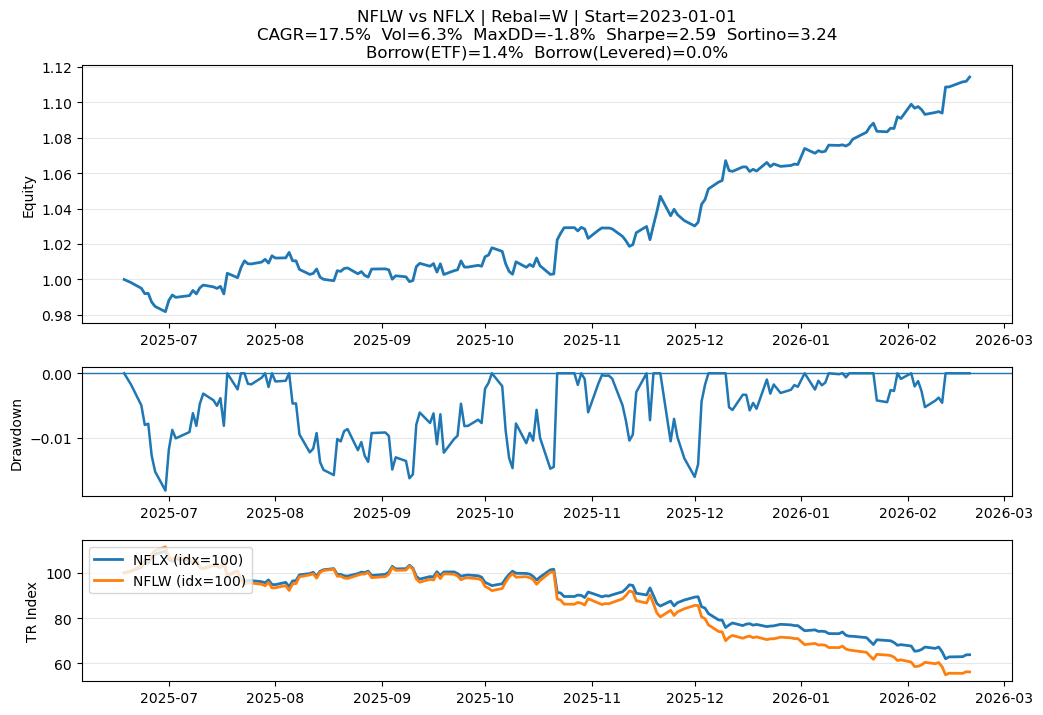

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


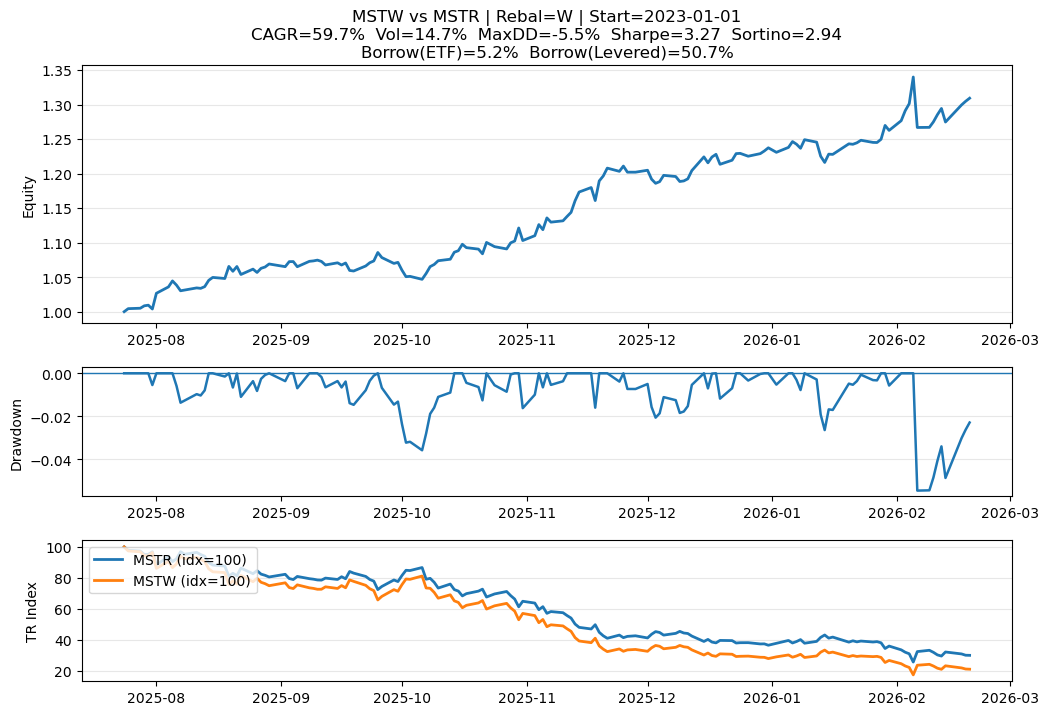

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


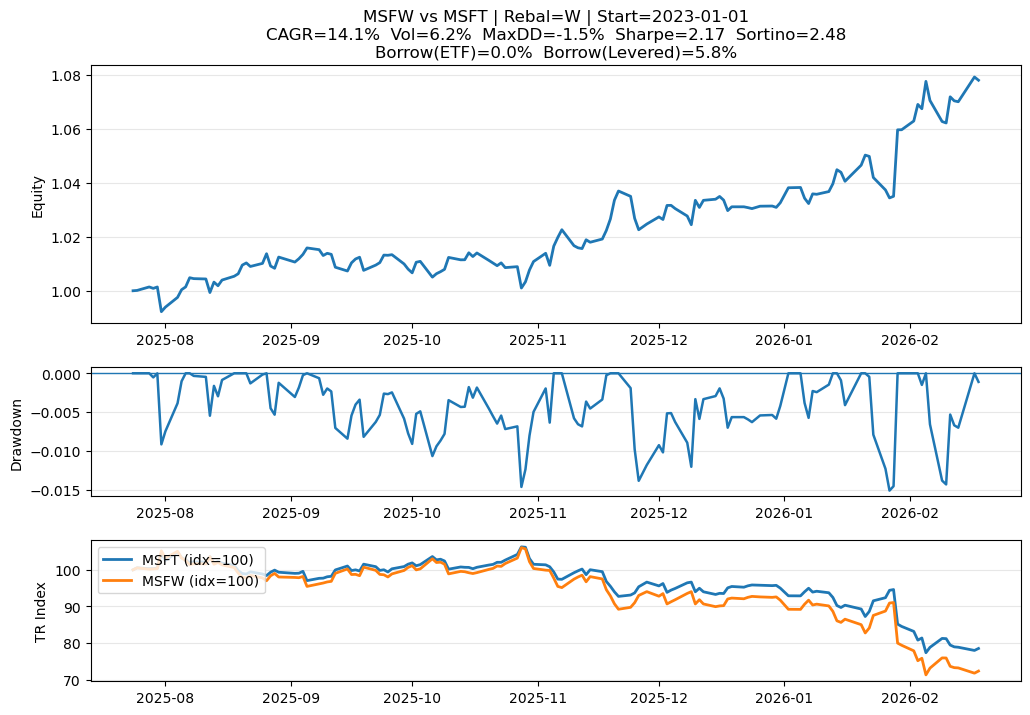

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


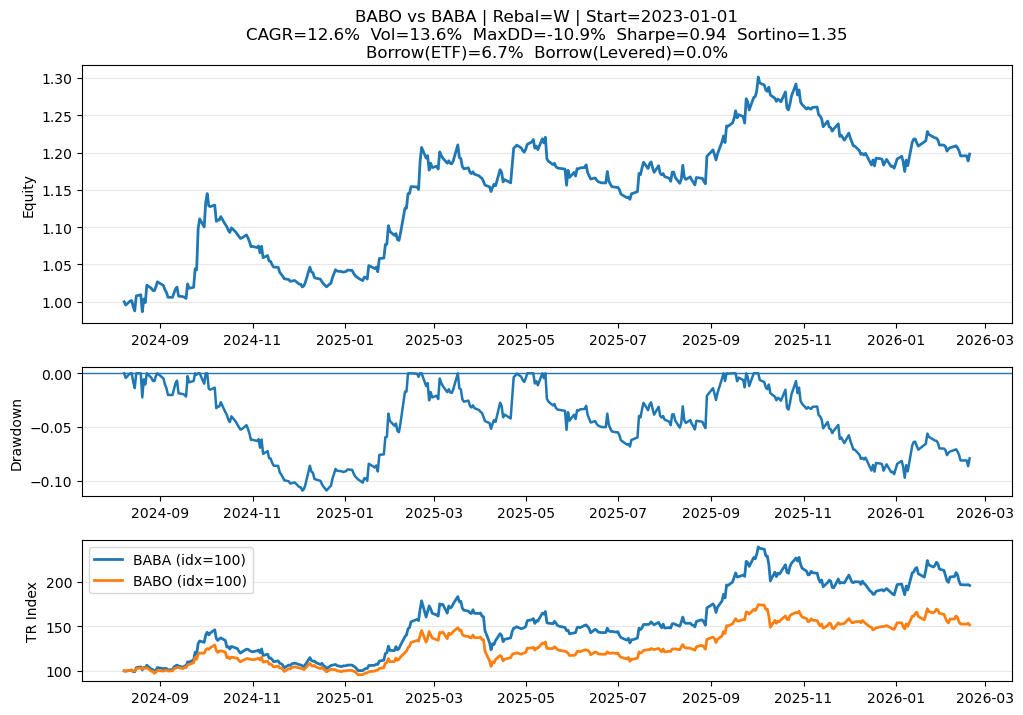

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


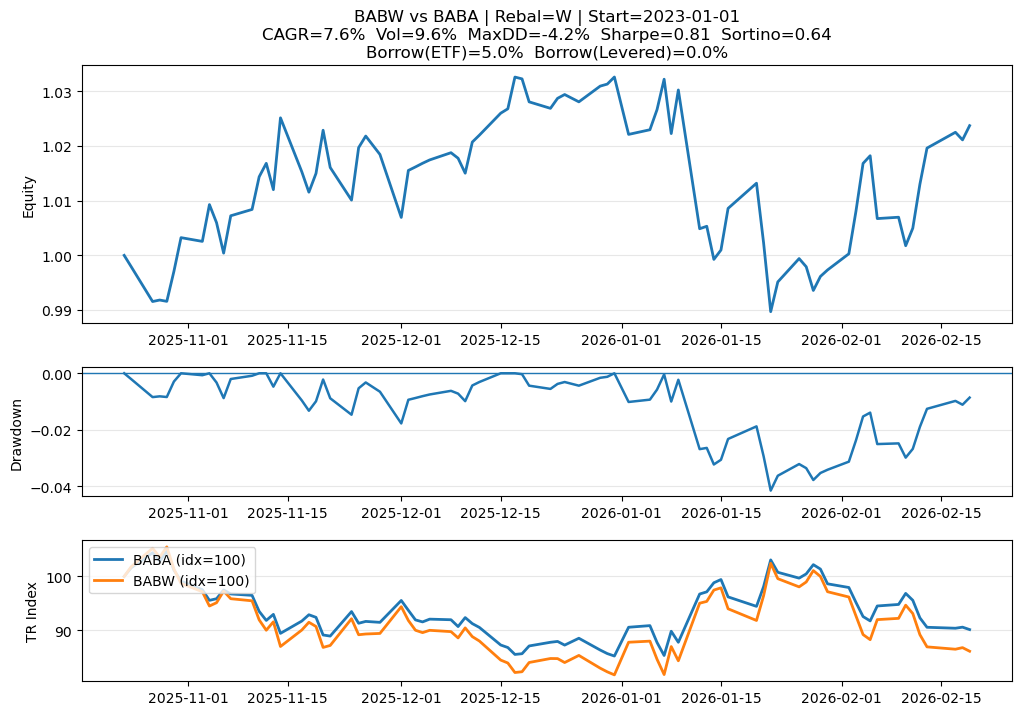

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


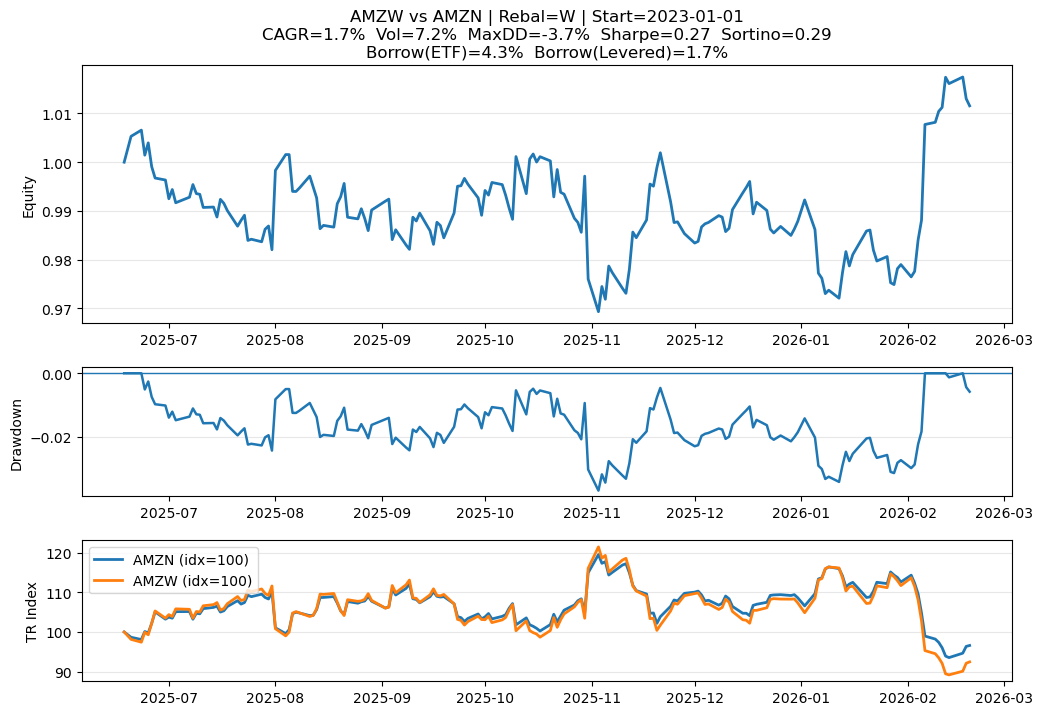

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


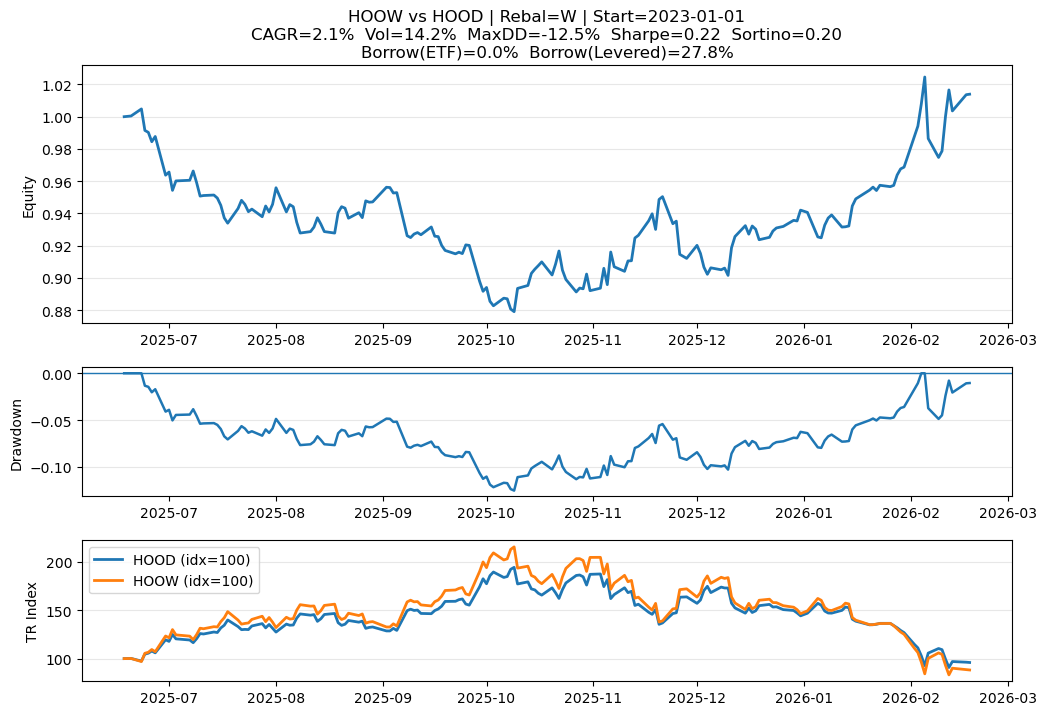

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


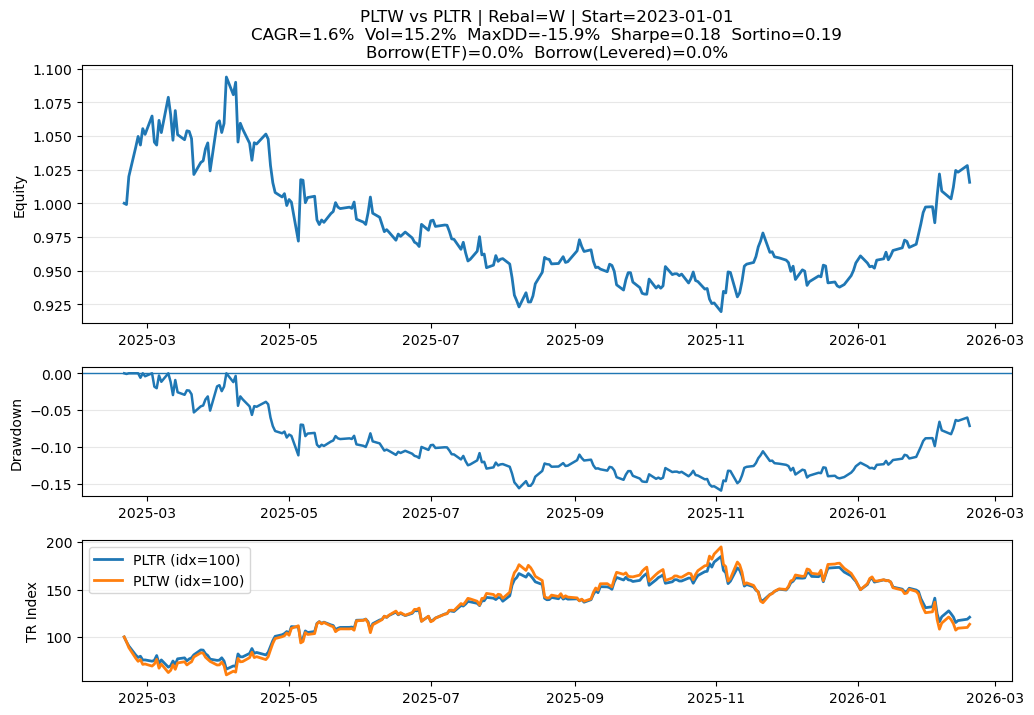

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


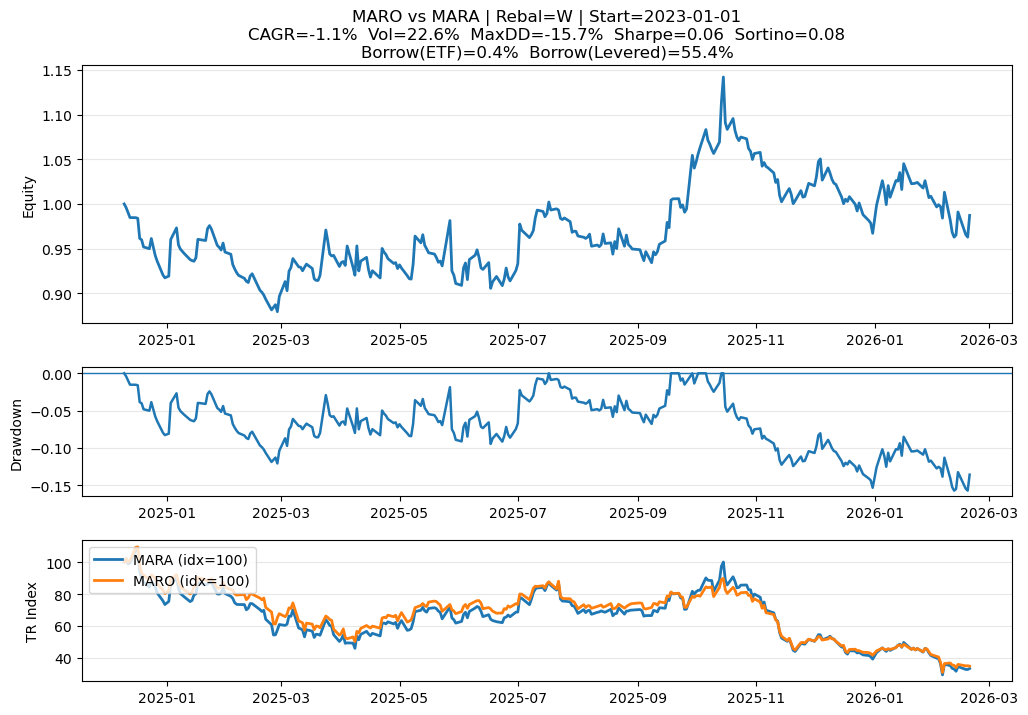

C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\4280942744.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


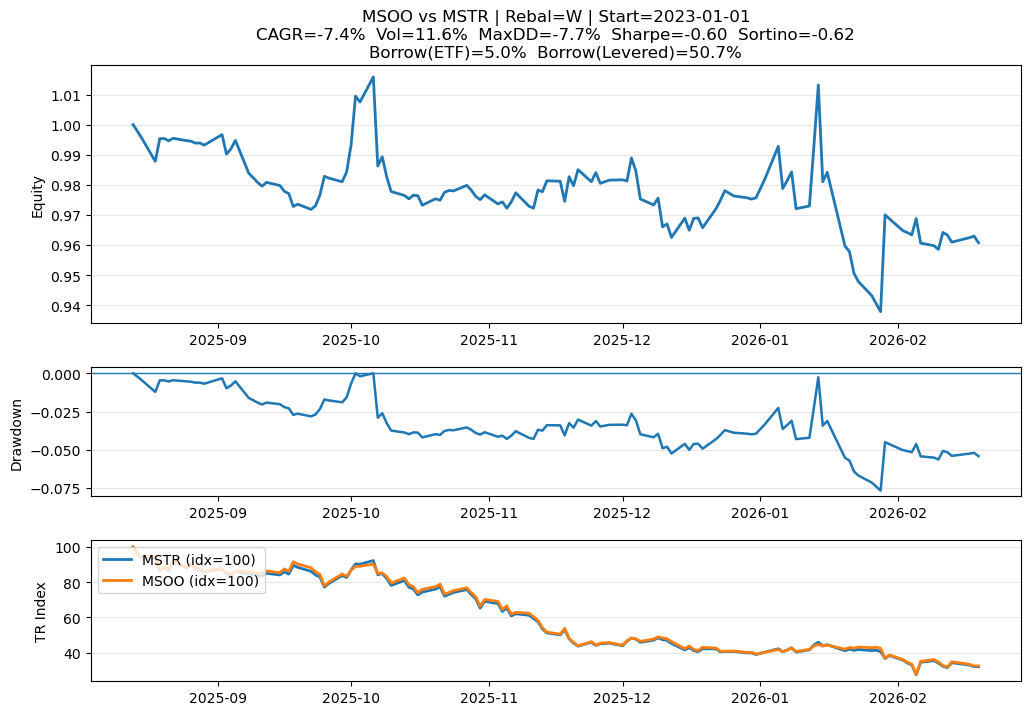

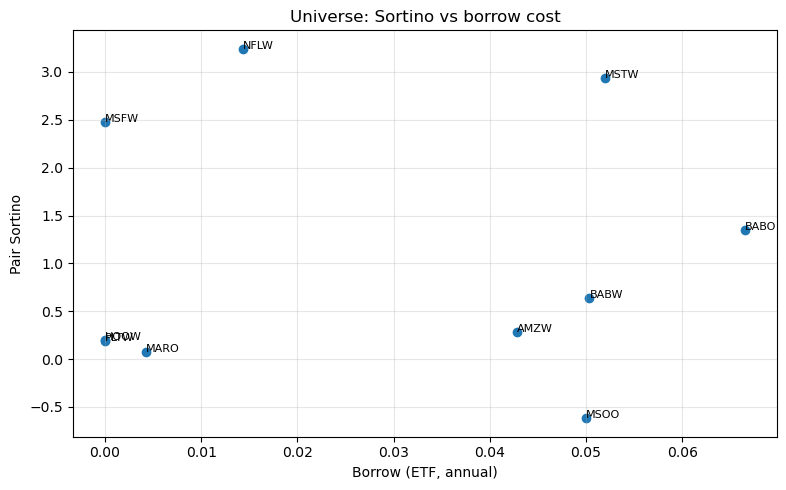

In [66]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05

# ============================================================
# 0) Helper: borrow
# ============================================================
def get_borrow_annual(symbol: str) -> float:
    sym = str(symbol).upper().replace(".", "-")
    if "borrow_map" in globals() and (globals().get("borrow_map") is not None):
        bm = globals()["borrow_map"]
        if sym in bm:
            return float(bm[sym])
        if "default" in bm:
            return float(bm["default"])
    return float(DEFAULT_BORROW_ANNUAL)

# ============================================================
# 1) Perf stats (CAGR/Vol/DD/Sortino)
# ============================================================
def perf_stats_extended(ret: pd.Series, mar_annual: float = 0.0) -> dict:
    ret = ret.dropna()
    n = len(ret)
    if n == 0:
        return dict(TradingDays=0, TotalReturn=np.nan, CAGR=np.nan, AnnVol=np.nan,
                    MaxDD=np.nan, Sharpe=np.nan, Sortino=np.nan, Calmar=np.nan)

    curve = (1.0 + ret).cumprod()
    total = float(curve.iloc[-1] - 1.0)
    cagr  = float(curve.iloc[-1] ** (TRADING_DAYS / n) - 1.0)
    vol   = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    dd    = curve / curve.cummax() - 1.0
    maxdd = float(dd.min())

    mu_ann = float(ret.mean() * TRADING_DAYS)
    sharpe = float(mu_ann / vol) if vol > 0 else np.nan

    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0
    downside = ret[ret < mar_daily] - mar_daily
    down_vol = float(np.sqrt((downside**2).mean()) * np.sqrt(TRADING_DAYS)) if len(downside) else 0.0
    sortino  = float(mu_ann / down_vol) if down_vol > 0 else np.nan

    calmar = float(cagr / abs(maxdd)) if maxdd < 0 else np.nan

    return dict(
        TradingDays=int(n),
        TotalReturn=total,
        CAGR=cagr,
        AnnVol=vol,
        MaxDD=maxdd,
        Sharpe=sharpe,
        Sortino=sortino,
        Calmar=calmar,
    )

# ============================================================
# 2) Universe mapping for the new tickers you listed
#    You MUST verify these if your dataset uses different tickers.
# ============================================================
# "UnderlyingLeveredETF" here is the leveraged product whose options these funds write
# (or the closest proxy you want to track borrow on).
stack_map = {
    "BABO": {"Underlying": "BABA", "UnderlyingLeveredETF": "BABX"},  # proxy: 2x BABA
    "BABW": {"Underlying": "BABA", "UnderlyingLeveredETF": "BABX"},
    "MARO": {"Underlying": "MARA", "UnderlyingLeveredETF": "MRAL"},  # proxy: 2x MARA
    "MSTW": {"Underlying": "MSTR", "UnderlyingLeveredETF": "MSTX"},  # proxy: 2x/levered MSTR
    "MSFW": {"Underlying": "MSFT", "UnderlyingLeveredETF": "MSFU"},  # proxy: 2x MSFT (verify)
    "HOOW": {"Underlying": "HOOD", "UnderlyingLeveredETF": "HOOX"},  # proxy: 2x HOOD
    "PLTW": {"Underlying": "PLTR", "UnderlyingLeveredETF": "PTIR"},  # proxy: 2x PLTR
    "NFLW": {"Underlying": "NFLX", "UnderlyingLeveredETF": "NFLX"},  # placeholder if no levered proxy in your universe
    "AMZW": {"Underlying": "AMZN", "UnderlyingLeveredETF": "AMZZ"},  # proxy: 2x AMZN
    "MSOO": {"Underlying": "MSTR", "UnderlyingLeveredETF": "MSTX"}
}

# ============================================================
# 3) Pull total-return column names
# ============================================================
def _tr_col(ticker: str) -> str:
    return f"{str(ticker).upper().replace('.', '-')}_TR"

def _has_cols(tr_prices: pd.DataFrame, cols: list[str]) -> bool:
    return all(c in tr_prices.columns for c in cols)

# ============================================================
# 4) Run one pair through your existing simulator
#    IMPORTANT: requires simulate_pair_weekly_beta_hedged(...) to already exist.
# ============================================================
def run_one_pair(
    *,
    tr_prices: pd.DataFrame,
    etf: str,
    underlying: str,
    beta_used: float,
    borrow_annual: float,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
):
    # sanity check for TR columns
    cols = [_tr_col(etf), _tr_col(underlying)]
    if not _has_cols(tr_prices, cols):
        return None, None

    r = simulate_pair_weekly_beta_hedged(
        tr_prices=tr_prices,
        underlying=underlying,
        etf=etf,
        beta_used=beta_used,
        borrow_annual=borrow_annual,
        backtest_start=backtest_start,
        freq=freq,
        beta_floor=beta_floor,
        initial_equity=1.0,
    )
    if r.empty:
        return None, None

    stats = perf_stats_extended(r, mar_annual=mar_annual)
    return r, stats

# ============================================================
# 5) Summary table for your new tickers
# ============================================================
def summarize_stack_universe(
    *,
    tr_prices: pd.DataFrame,
    tickers: list[str],
    beta_scalar: float = 1.0,          # e.g. 1.0, 1.2, 1.5
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
):
    rows = []

    for tkr in tickers:
        tkr = str(tkr).upper().replace(".", "-")
        if tkr not in stack_map:
            print(f"Skip {tkr}: not in stack_map")
            continue

        und = stack_map[tkr]["Underlying"]
        lev = stack_map[tkr]["UnderlyingLeveredETF"]

        # Use historical Beta from your pairs_ok (if present); else fallback to 1.0
        beta_used = np.nan
        if "pairs_ok" in globals():
            m = pairs_ok[(pairs_ok["ETF"].str.upper()==tkr) & (pairs_ok["Underlying"].str.upper()==und)]
            if len(m) > 0:
                if "Beta" in m.columns:
                    beta_used = float(m["Beta"].iloc[0])
                elif "Beta_used" in m.columns:
                    beta_used = float(m["Beta_used"].iloc[0])

        if not np.isfinite(beta_used):
            beta_used = 1.0

        beta_used *= float(beta_scalar)

        borrow_etf = get_borrow_annual(tkr)
        borrow_lev = get_borrow_annual(lev) if lev else np.nan

        r, stats = run_one_pair(
            tr_prices=tr_prices,
            etf=tkr,
            underlying=und,
            beta_used=beta_used,
            borrow_annual=borrow_etf,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            mar_annual=mar_annual,
        )
        if stats is None:
            print(f"Skip {tkr}/{und}: missing TR cols or no history")
            continue

        rows.append({
            "ETF": tkr,
            "Underlying": und,
            "UnderlyingLeveredETF": lev,
            "Beta_used": beta_used,
            "Borrow_ETF": borrow_etf,
            "Borrow_UnderlyingLeveredETF": borrow_lev,
            **stats
        })

    return pd.DataFrame(rows)

# ============================================================
# 6) Plot each pair (equity, drawdown, normalized prices)
# ============================================================
def plot_pairs_from_summary(
    *,
    tr_prices: pd.DataFrame,
    summary: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
    sort_by: str = "Sortino",
):
    df = summary.copy()
    if sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=False)

    for _, row in df.iterrows():
        etf = row["ETF"]
        und = row["Underlying"]
        beta_used = float(row["Beta_used"])
        borrow_etf = float(row["Borrow_ETF"])

        r, stats = run_one_pair(
            tr_prices=tr_prices,
            etf=etf,
            underlying=und,
            beta_used=beta_used,
            borrow_annual=borrow_etf,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            mar_annual=mar_annual,
        )
        if stats is None:
            continue

        curve = (1 + r).cumprod()
        dd = curve / curve.cummax() - 1.0

        # price panel
        etf_col = _tr_col(etf)
        und_col = _tr_col(und)
        px = tr_prices[[und_col, etf_col]].dropna()
        px = px.loc[px.index >= pd.Timestamp(backtest_start)]
        px = px.loc[px.index.isin(r.index)]
        if px.empty:
            continue
        px_norm = 100.0 * px / px.iloc[0]

        fig = plt.figure(figsize=(12, 8))
        gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.1, 1.2], hspace=0.25)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        ax3 = fig.add_subplot(gs[2], sharex=ax1)

        ax1.plot(curve.index, curve.values, linewidth=2.0)
        ax1.set_title(
            f"{etf} vs {und} | Rebal={freq} | Start={backtest_start}\n"
            f"CAGR={stats['CAGR']:.1%}  Vol={stats['AnnVol']:.1%}  MaxDD={stats['MaxDD']:.1%}  "
            f"Sharpe={stats['Sharpe']:.2f}  Sortino={stats['Sortino']:.2f}\n"
            f"Borrow(ETF)={row['Borrow_ETF']:.1%}  Borrow(Levered)={row['Borrow_UnderlyingLeveredETF'] if pd.notna(row['Borrow_UnderlyingLeveredETF']) else np.nan:.1%}"
        )
        ax1.set_ylabel("Equity")
        ax1.grid(True, axis="y", alpha=0.3)

        ax2.plot(dd.index, dd.values, linewidth=1.8)
        ax2.axhline(0, linewidth=1)
        ax2.set_ylabel("Drawdown")
        ax2.grid(True, axis="y", alpha=0.3)

        ax3.plot(px_norm.index, px_norm[und_col], linewidth=2.0, label=f"{und} (idx=100)")
        ax3.plot(px_norm.index, px_norm[etf_col], linewidth=2.0, label=f"{etf} (idx=100)")
        ax3.set_ylabel("TR Index")
        ax3.legend(loc="upper left")
        ax3.grid(True, axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()

# ============================================================
# RUN: same analysis for your tickers
# ============================================================
tickers = ["BABO", "MARO", "BABW", "MSTW", "MSFW", "HOOW", "PLTW", "NFLW", "AMZW", "MSOO"]

# Choose beta scalar like you did before (1.0, 1.2, 1.5)
BETA_SCALAR = 1.0

summary2 = summarize_stack_universe(
    tr_prices=prices,           # your TR price wide DF
    tickers=tickers,
    beta_scalar=BETA_SCALAR,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    mar_annual=0.0,
)

display(
    summary2.sort_values("Sortino", ascending=False)[
        ["ETF","Underlying","UnderlyingLeveredETF","CAGR","AnnVol","MaxDD","Sharpe","Sortino",
         "Borrow_ETF","Borrow_UnderlyingLeveredETF","TradingDays","Beta_used"]
    ]
)

plot_pairs_from_summary(
    tr_prices=prices,
    summary=summary2,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    mar_annual=0.0,
    sort_by="Sortino",
)

# Optional scatter: Sortino vs borrow costs (ETF borrow on x-axis)
tmp = summary2.dropna(subset=["Sortino"]).copy()
plt.figure(figsize=(8,5))
plt.scatter(tmp["Borrow_ETF"], tmp["Sortino"])
for _, r in tmp.iterrows():
    plt.text(r["Borrow_ETF"], r["Sortino"], r["ETF"], fontsize=8)
plt.xlabel("Borrow (ETF, annual)")
plt.ylabel("Pair Sortino")
plt.title("Universe: Sortino vs borrow cost")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\3702241777.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  g = s.groupby(pd.Grouper(freq="M"))
C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\3702241777.py:46: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  g = s.groupby(pd.Grouper(freq="Q"))



===== Target Gross (single universe) = 4x equity =====
 TargetGross Rebal_freq     CAGR      Vol     MaxDD  TradingDays  NetLong_xEq_mean  Debit_xEq_mean  MarginInterest_total  BorrowCost_total  Pairs_Pairs_mean  Pairs_Pairs_min  Pairs_Pairs_max
         4.0          W 0.277828 0.058313 -0.031222          782          1.305615        0.305969              0.045993          0.264820         26.947570             11.0             68.0
         4.0          M 0.184402 0.069951 -0.040678          766          1.306397        0.306759              0.038949          0.228783         26.643603             11.0             68.0
         4.0          Q 0.138918 0.099035 -0.113908          724          1.307747        0.308130              0.034020          0.204530         26.133978             11.0             68.0


C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\3702241777.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  g = s.groupby(pd.Grouper(freq="M"))
C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\3702241777.py:46: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  g = s.groupby(pd.Grouper(freq="Q"))



===== Target Gross (single universe) = 6x equity =====
 TargetGross Rebal_freq     CAGR      Vol     MaxDD  TradingDays  NetLong_xEq_mean  Debit_xEq_mean  MarginInterest_total  BorrowCost_total  Pairs_Pairs_mean  Pairs_Pairs_min  Pairs_Pairs_max
         6.0          W 0.420034 0.087351 -0.047294          782          1.956100        0.956100              0.175808          0.486628         26.947570             11.0             68.0
         6.0          M 0.267109 0.104898 -0.062344          766          1.954049        0.954049              0.137146          0.388015         26.643603             11.0             68.0
         6.0          Q 0.194338 0.150295 -0.171365          724          1.947108        0.947108              0.113309          0.330524         26.133978             11.0             68.0


C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\3702241777.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  g = s.groupby(pd.Grouper(freq="M"))
C:\Users\werdn\AppData\Local\Temp\ipykernel_8584\3702241777.py:46: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  g = s.groupby(pd.Grouper(freq="Q"))



===== Target Gross (single universe) = 8x equity =====
 TargetGross Rebal_freq     CAGR      Vol     MaxDD  TradingDays  NetLong_xEq_mean  Debit_xEq_mean  MarginInterest_total  BorrowCost_total  Pairs_Pairs_mean  Pairs_Pairs_min  Pairs_Pairs_max
         8.0          W 0.576334 0.116317 -0.063222          782          2.605072        1.605072              0.363109          0.798009         26.947570             11.0             68.0
         8.0          M 0.354095 0.139843 -0.083631          766          2.598245        1.598245              0.260651          0.585467         26.643603             11.0             68.0
         8.0          Q 0.250759 0.203174 -0.227875          724          2.577886        1.577886              0.204414          0.474161         26.133978             11.0             68.0

===== Best combo by gross =====
 TargetGross Best_freq  Best_CAGR  Best_Vol  Best_MaxDD  NetLong_xEq_mean  Debit_xEq_mean  MarginInterest_total  BorrowCost_total  TradingDays
    

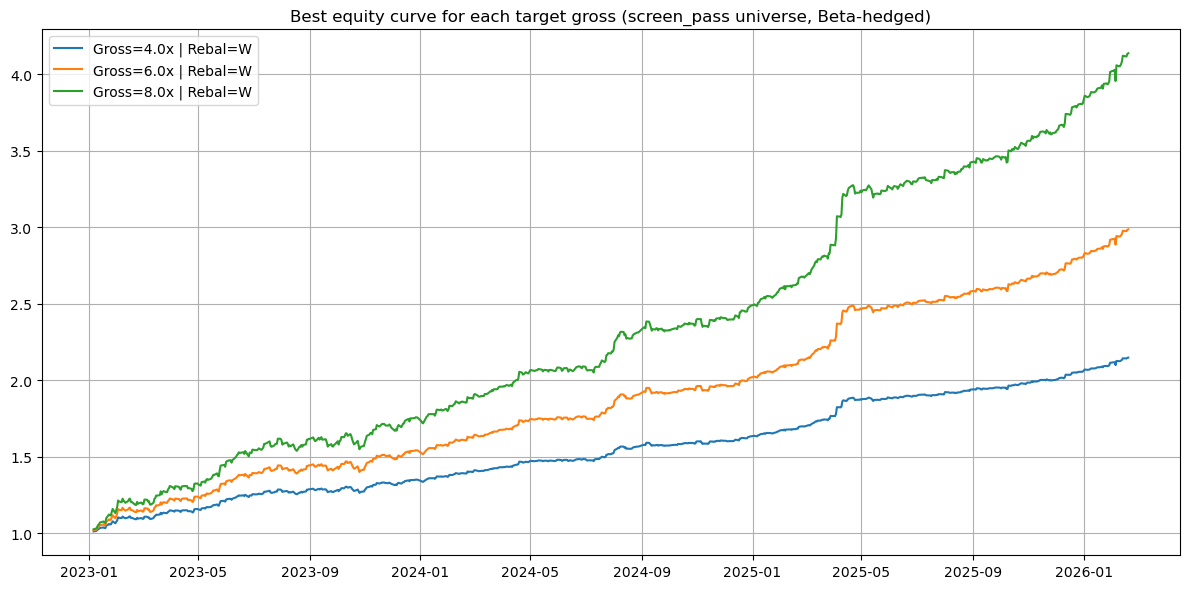

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05  # 5% annual default borrow if missing

# Margin financing assumptions (IBKR-style daily accrual on debit)
MARGIN_ANNUAL   = 0.04428   # 4.428% blended
MARGIN_DAYCOUNT = 360       # Actual/360 daily accrual convention


# ============================================================
# Helpers
# ============================================================
def _norm_sym(x: str) -> str:
    return str(x).upper().replace(".", "-").strip()

def _to_naive_utc_index(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    idx = pd.to_datetime(idx)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    return idx

def get_rebalance_days(idx: pd.DatetimeIndex, freq: str) -> set[pd.Timestamp]:
    """
    Return the set of timestamps in idx that are rebalance dates.
    Supports: "W", "M", "Q", "NEVER" (case-insensitive).
    """
    f = str(freq).upper().strip()
    idx = _to_naive_utc_index(pd.DatetimeIndex(idx))

    if f == "NEVER":
        return set()

    # We pick the last available date in each period (week/month/quarter)
    s = pd.Series(1, index=idx)
    if f == "W":
        g = s.groupby(pd.Grouper(freq="W-FRI"))
    elif f == "M":
        g = s.groupby(pd.Grouper(freq="M"))
    elif f == "Q":
        g = s.groupby(pd.Grouper(freq="Q"))
    else:
        raise ValueError(f"Unsupported freq: {freq}")

    rebal = set()
    for _, grp in g:
        if len(grp.index) > 0:
            rebal.add(grp.index[-1])
    return rebal

def build_pair_start_dates(px: pd.DataFrame, pairs: list[tuple[str, str]]) -> dict[tuple[str, str], pd.Timestamp | None]:
    """
    For each (Underlying, ETF) pair, find first date where both columns have valid prices.
    """
    out: dict[tuple[str, str], pd.Timestamp | None] = {}
    for und, etf in pairs:
        und_col = f"{_norm_sym(und)}_TR"
        etf_col = f"{_norm_sym(etf)}_TR"
        if und_col not in px.columns or etf_col not in px.columns:
            out[(_norm_sym(und), _norm_sym(etf))] = None
            continue

        df = px[[und_col, etf_col]].dropna(how="any")
        out[(_norm_sym(und), _norm_sym(etf))] = (df.index[0] if not df.empty else None)
    return out

def perf_stats(ret: pd.Series, label: str = "") -> dict:
    """
    Basic perf stats on daily returns series.
    """
    r = ret.replace([np.inf, -np.inf], np.nan).dropna()
    if r.empty:
        return {"Label": label, "TradingDays": 0, "CAGR": np.nan, "Vol": np.nan, "MaxDD": np.nan}

    eq = (1.0 + r).cumprod()
    # CAGR
    days = (eq.index[-1] - eq.index[0]).days
    years = days / 365.25 if days > 0 else np.nan
    cagr = (float(eq.iloc[-1]) ** (1.0 / years) - 1.0) if (np.isfinite(years) and years > 0) else np.nan

    # Vol
    vol = float(r.std(ddof=0) * np.sqrt(TRADING_DAYS)) if len(r) > 1 else np.nan

    # MaxDD
    dd = eq / eq.cummax() - 1.0
    maxdd = float(dd.min()) if not dd.empty else np.nan

    return {
        "Label": label,
        "TradingDays": int(len(r)),
        "CAGR": float(cagr) if np.isfinite(cagr) else np.nan,
        "Vol": vol,
        "MaxDD": maxdd,
    }

def summarize_pair_count(pair_count: pd.Series, min_pairs: int = 1, prefix: str = "") -> dict:
    pc = pair_count.replace([np.inf, -np.inf], np.nan).dropna()
    if pc.empty:
        return {f"{prefix}Pairs_mean": np.nan, f"{prefix}Pairs_min": np.nan, f"{prefix}Pairs_max": np.nan}
    return {
        f"{prefix}Pairs_mean": float(pc.mean()),
        f"{prefix}Pairs_min": float(pc.min()),
        f"{prefix}Pairs_max": float(pc.max()),
        f"{prefix}Pairs_ge_{min_pairs}": float((pc >= min_pairs).mean()),
    }

def make_borrow_daily_map_from_screen(
    screen_pass: pd.DataFrame,
    *,
    etf_col: str = "ETF",
    borrow_net_annual_col: str = "borrow_net_annual",
    default_borrow_annual: float = DEFAULT_BORROW_ANNUAL,
    trading_days: int = TRADING_DAYS,
    clamp_min_annual: float = 0.0,
    clamp_max_annual: float | None = None,
) -> dict[str, float]:
    """
    Build daily borrow map for ETFs using screen_pass['borrow_net_annual'] when available.
    Falls back to default annual.
    Output: {ETF: borrow_daily_decimal}
    """
    out: dict[str, float] = {}

    if screen_pass is None or screen_pass.empty:
        return out

    if etf_col not in screen_pass.columns:
        raise ValueError(f"screen_pass missing '{etf_col}' column")

    for _, row in screen_pass.iterrows():
        etf = _norm_sym(row[etf_col])
        ann = row.get(borrow_net_annual_col, np.nan)
        if not np.isfinite(ann):
            ann = float(default_borrow_annual)

        ann = float(ann)
        if clamp_max_annual is not None:
            ann = min(ann, float(clamp_max_annual))
        ann = max(ann, float(clamp_min_annual))

        out[etf] = ann / float(trading_days)

    return out

def build_pairs_and_beta_map_from_screen(
    screen_pass: pd.DataFrame,
    *,
    etf_col: str = "ETF",
    underlying_col: str = "Underlying",
    beta_col: str = "Beta",
    min_abs_beta: float = 0.50,
) -> tuple[list[tuple[str, str]], dict[tuple[str, str], float]]:
    """
    Simplification requested:
      - Use screen_pass instead of cc/lev dfs
      - Use Beta column as the 'effective leverage' for hedging
      - For each row: pair = (Underlying, ETF)
      - Hedge ratio uses 1/abs(Beta) (see simulation function below)
    Returns:
      pairs: list[(UNDERLYING, ETF)]
      beta_map: {(UNDERLYING, ETF): Beta}
    """
    required = {etf_col, underlying_col, beta_col}
    missing = required - set(screen_pass.columns)
    if missing:
        raise ValueError(f"screen_pass missing columns: {sorted(missing)}")

    pairs: list[tuple[str, str]] = []
    beta_map: dict[tuple[str, str], float] = {}

    for _, row in screen_pass.iterrows():
        etf = _norm_sym(row[etf_col])
        und = _norm_sym(row[underlying_col])
        beta = row.get(beta_col, np.nan)

        if not isinstance(etf, str) or not etf:
            continue
        if not isinstance(und, str) or not und:
            continue
        if not np.isfinite(beta):
            continue

        beta = float(beta)
        if abs(beta) < float(min_abs_beta):
            continue

        key = (und, etf)
        pairs.append(key)
        beta_map[key] = beta

    # de-dupe while preserving order
    seen = set()
    pairs2 = []
    for p in pairs:
        if p not in seen:
            seen.add(p)
            pairs2.append(p)

    return pairs2, beta_map


# ============================================================
# UPDATED BACKTEST: per-pair hedge ratio derived from Beta
# ============================================================
def simulate_sleeve_fixed_shares_rebalanced_to_gross_using_beta(
    tr_prices: pd.DataFrame,
    pairs: list[tuple[str, str]],
    beta_map: dict[tuple[str, str], float],
    borrow_daily_map: dict[str, float],
    *,
    freq: str = "M",
    start_when_first_pair_active: bool = True,
    target_gross_mult: float = 4.0,
    initial_equity: float = 1.0,
    default_borrow_daily: float = DEFAULT_BORROW_ANNUAL / TRADING_DAYS,
    lock_universe_if_never: bool = True,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
    # optional guardrails:
    clamp_beta_min_abs: float = 0.50,
    clamp_beta_max_abs: float | None = None,
):
    """
    One-sleeve simulation:
      - Universe = (Underlying, ETF) pairs from screen_pass
      - IMPORTANT: Beta is used as leverage for hedging purposes:
          short_ratio(pair) = 1 / abs(beta(pair))
        i.e., long $1 underlying, short $1/|beta| of the ETF
      - Rebalance on schedule to hit target gross (per sleeve) = target_gross_mult * equity
      - Charges:
          * Borrow on short ETF notional
          * Margin interest on debit = max(0, net_long - equity)

    TR columns expected: {TICKER}_TR for both underlying and ETF.
    """

    px = tr_prices.copy()
    px.index = _to_naive_utc_index(px.index)

    idx = px.index
    rebal_days = get_rebalance_days(idx, freq)
    pair_start = build_pair_start_dates(px, pairs)

    equity = float(initial_equity)
    shares_under = pd.Series(dtype=float)
    shares_etf   = pd.Series(dtype=float)
    port_ret = pd.Series(index=idx, dtype=float)
    pair_count = pd.Series(index=idx, dtype=int)

    diag = pd.DataFrame(index=idx, columns=[
        "Equity",
        "LongNotional_prev",
        "ShortNotional_prev",
        "NetLong_prev",
        "Debit_prev",
        "MarginInterest",
        "BorrowCost",
    ], dtype=float)

    first_active_day = None
    locked_pairs = None
    margin_daily = float(margin_annual) / float(margin_daycount)

    def eligible_pairs_on(t: pd.Timestamp) -> list[tuple[str, str]]:
        elig = []
        for (und, etf), d0 in pair_start.items():
            if d0 is None or d0 > t:
                continue
            elig.append((und, etf))
        return elig

    def _beta_abs_for_pair(pair: tuple[str, str]) -> float:
        b = beta_map.get(pair, np.nan)
        if not np.isfinite(b):
            return np.nan
        b = abs(float(b))
        if b < float(clamp_beta_min_abs):
            return np.nan
        if clamp_beta_max_abs is not None and b > float(clamp_beta_max_abs):
            b = float(clamp_beta_max_abs)
        return b

    def rebalance_to_target_gross(t: pd.Timestamp, active_pairs: list[tuple[str, str]]):
        nonlocal shares_under, shares_etf
        n = len(active_pairs)
        if n == 0:
            shares_under = pd.Series(dtype=float)
            shares_etf   = pd.Series(dtype=float)
            return

        gross_target = float(target_gross_mult) * float(equity)
        gross_per_pair = gross_target / n

        su, se = {}, {}

        for und, etf in active_pairs:
            und = _norm_sym(und)
            etf = _norm_sym(etf)

            und_col = f"{und}_TR"
            etf_col = f"{etf}_TR"
            if und_col not in px.columns or etf_col not in px.columns:
                continue

            pu = float(px.at[t, und_col])
            pe = float(px.at[t, etf_col])
            if not (np.isfinite(pu) and pu > 0 and np.isfinite(pe) and pe > 0):
                continue

            beta_abs = _beta_abs_for_pair((und, etf))
            if not np.isfinite(beta_abs) or beta_abs <= 0:
                continue

            # Beta-as-leverage hedge ratio:
            # long $1 underlying, short $1/beta dollars of ETF
            short_ratio = 1.0 / beta_abs

            # Allocate gross across long+short dollars:
            # gross = long + short = a + a*short_ratio = a*(1+short_ratio)
            a = gross_per_pair / (1.0 + short_ratio)

            long_u_dol  = a
            short_e_dol = a * short_ratio

            su[und] = su.get(und, 0.0) + (long_u_dol / pu)
            se[etf] = se.get(etf, 0.0) - (short_e_dol / pe)

        shares_under = pd.Series(su, dtype=float)
        shares_etf   = pd.Series(se, dtype=float)

    prev_t = None

    for t in idx:
        # rebalance logic
        if str(freq).upper() == "NEVER" and lock_universe_if_never:
            if locked_pairs is None:
                elig = eligible_pairs_on(t)
                if len(elig) > 0:
                    locked_pairs = elig
                    rebalance_to_target_gross(t, locked_pairs)
                    if first_active_day is None:
                        first_active_day = t
            pair_count.at[t] = 0 if locked_pairs is None else len(locked_pairs)
        else:
            if t in rebal_days:
                active_pairs = eligible_pairs_on(t)
                pair_count.at[t] = len(active_pairs)
                if first_active_day is None and len(active_pairs) > 0:
                    first_active_day = t
                rebalance_to_target_gross(t, active_pairs)
            else:
                pair_count.at[t] = 0 if prev_t is None else int(pair_count.at[prev_t])

        diag.at[t, "Equity"] = equity

        if shares_under.empty and shares_etf.empty:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        if prev_t is None:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        pnl = 0.0

        # PnL: underlyings
        for und, sh in shares_under.items():
            col = f"{_norm_sym(und)}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

        # PnL: ETFs + borrow
        borrow_cost = 0.0
        for etf, sh in shares_etf.items():
            col = f"{_norm_sym(etf)}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

            b = float(borrow_daily_map.get(_norm_sym(etf), default_borrow_daily))
            if np.isfinite(p0):
                borrow_cost += abs(float(sh)) * p0 * b

        # Notionals (prev day) + margin interest
        long_notional_prev = 0.0
        for und, sh in shares_under.items():
            col = f"{_norm_sym(und)}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            if np.isfinite(p0):
                long_notional_prev += float(sh) * p0

        short_notional_prev = 0.0
        for etf, sh in shares_etf.items():
            col = f"{_norm_sym(etf)}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            if np.isfinite(p0):
                short_notional_prev += abs(float(sh)) * p0

        net_long_prev = long_notional_prev - short_notional_prev
        debit_prev = max(0.0, net_long_prev - equity)
        margin_interest = debit_prev * margin_daily

        diag.at[t, "LongNotional_prev"]  = long_notional_prev
        diag.at[t, "ShortNotional_prev"] = short_notional_prev
        diag.at[t, "NetLong_prev"]       = net_long_prev
        diag.at[t, "Debit_prev"]         = debit_prev
        diag.at[t, "MarginInterest"]     = margin_interest
        diag.at[t, "BorrowCost"]         = borrow_cost

        pnl -= (borrow_cost + margin_interest)

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        port_ret.at[t] = r
        prev_t = t

    if start_when_first_pair_active and first_active_day is not None:
        port_ret = port_ret.loc[first_active_day:]
        pair_count = pair_count.loc[first_active_day:]
        diag = diag.loc[first_active_day:]

    return port_ret.dropna(), pair_count, diag


# ============================================================
# UPDATED GRID TEST: single screen_pass universe (no cc/lev split)
# ============================================================
def run_grid_test_screen_pass(
    prices: pd.DataFrame,
    screen_pass: pd.DataFrame,
    *,
    freqs=("W", "M"),
    gross_levels=(4, 6, 8),
    backtest_start="2023-01-01",
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
    min_abs_beta: float = 0.50,
):
    """
    Runs a grid across (freq x gross_levels) using:
      - pairs from screen_pass: (Underlying, ETF)
      - beta_map from screen_pass['Beta'] (used as leverage)
      - borrow from screen_pass['borrow_net_annual'] when available
    """
    start_dt = pd.Timestamp(backtest_start)
    prices_bt = prices.loc[prices.index >= start_dt].copy()
    if prices_bt.empty:
        raise ValueError("No price data after backtest_start.")

    # build pairs + beta map
    pairs, beta_map = build_pairs_and_beta_map_from_screen(
        screen_pass,
        beta_col="Beta",
        min_abs_beta=float(min_abs_beta),
    )
    if len(pairs) == 0:
        raise ValueError("screen_pass produced 0 usable (Underlying, ETF) pairs.")

    # borrow daily map from screen (fallback default)
    borrow_daily_map = make_borrow_daily_map_from_screen(
        screen_pass,
        etf_col="ETF",
        borrow_net_annual_col="borrow_net_annual",
        default_borrow_annual=DEFAULT_BORROW_ANNUAL,
        trading_days=TRADING_DAYS,
    )

    all_results = []
    best_curves = {}
    best_rows = []

    for g in gross_levels:
        rows = []
        curves = {}

        for f in freqs:
            label = f"Gross={float(g)}x | Rebal={f}"

            port_ret, pair_count, diag = simulate_sleeve_fixed_shares_rebalanced_to_gross_using_beta(
                prices_bt,
                pairs=pairs,
                beta_map=beta_map,
                borrow_daily_map=borrow_daily_map,
                freq=f,
                target_gross_mult=float(g),
                initial_equity=1.0,
                margin_annual=float(margin_annual),
                margin_daycount=int(margin_daycount),
            )

            # financing diagnostics (per $1 initial equity)
            net_long_mult_mean = float((diag["NetLong_prev"] / diag["Equity"]).dropna().mean())
            debit_mult_mean    = float((diag["Debit_prev"]   / diag["Equity"]).dropna().mean())
            total_margin_interest = float(diag["MarginInterest"].dropna().sum())
            total_borrow_cost     = float(diag["BorrowCost"].dropna().sum())

            s = perf_stats(port_ret, label)
            pc_stats = summarize_pair_count(pair_count, min_pairs=20, prefix="Pairs_")

            rows.append({
                "TargetGross": float(g),
                "Rebal_freq": str(f),

                **s,
                **pc_stats,

                "NetLong_xEq_mean": net_long_mult_mean,
                "Debit_xEq_mean": debit_mult_mean,
                "MarginInterest_total": total_margin_interest,  # total paid (per $1)
                "BorrowCost_total": total_borrow_cost,          # total paid (per $1)
            })

            curves[label] = (1.0 + port_ret).cumprod()

        res_df = pd.DataFrame(rows).sort_values("CAGR", ascending=False).reset_index(drop=True)
        all_results.append(res_df)

        print(f"\n===== Target Gross (single universe) = {g}x equity =====")
        cols = [
            "TargetGross", "Rebal_freq",
            "CAGR", "Vol", "MaxDD", "TradingDays",
            "NetLong_xEq_mean", "Debit_xEq_mean",
            "MarginInterest_total", "BorrowCost_total",
            "Pairs_Pairs_mean", "Pairs_Pairs_min", "Pairs_Pairs_max",
        ]
        # Only print cols that exist (defensive)
        cols = [c for c in cols if c in res_df.columns]
        print(res_df[cols].to_string(index=False))

        best = res_df.iloc[0].to_dict()
        best_rows.append({
            "TargetGross": float(g),
            "Best_freq": best["Rebal_freq"],
            "Best_CAGR": best["CAGR"],
            "Best_Vol": best["Vol"],
            "Best_MaxDD": best["MaxDD"],
            "NetLong_xEq_mean": best["NetLong_xEq_mean"],
            "Debit_xEq_mean": best["Debit_xEq_mean"],
            "MarginInterest_total": best["MarginInterest_total"],
            "BorrowCost_total": best["BorrowCost_total"],
            "TradingDays": best["TradingDays"],
        })

        best_label = f"Gross={float(g)}x | Rebal={best['Rebal_freq']}"
        best_curves[g] = (best_label, curves[best_label])

    best_df = pd.DataFrame(best_rows).sort_values("TargetGross").reset_index(drop=True)
    print("\n===== Best combo by gross =====")
    print(best_df.to_string(index=False))

    plt.figure(figsize=(12, 6))
    for g, (lbl, curve) in best_curves.items():
        plt.plot(curve.index, curve.values, label=lbl)
    plt.title("Best equity curve for each target gross (screen_pass universe, Beta-hedged)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_results, best_df


# ============================================================
# MAIN (YOU RUN THIS)
# ============================================================

all_results, best_df = run_grid_test_screen_pass(
    prices=prices,                # TR prices with {TICKER}_TR cols (must include ETFs + Underlyings)
    screen_pass=screen_pass,
    freqs=("W","M","Q"),
    gross_levels=(4, 6, 8),
    backtest_start="2023-01-01",
    margin_annual=0.04428,
    margin_daycount=360,
    min_abs_beta=1.50,
)



=== Backtest Summary (Aligned daily returns) ===
                    Series      Start        End TargetGross Rebal_freq AnnReturn AnnVol  MaxDD Sharpe Sortino NetLong_xEq_mean Debit_xEq_mean MarginInterest_total BorrowCost_total
Diamond Creek ETF Arb Fund 2023-01-06 2026-02-19        6.00          W     42.3%   8.7%  -4.7%   4.08    8.19             1.96           0.96                17.6%            48.7%
                       SPY 2023-01-06 2026-02-18                            22.6%  15.2% -18.8%   1.42    2.13                                                                      


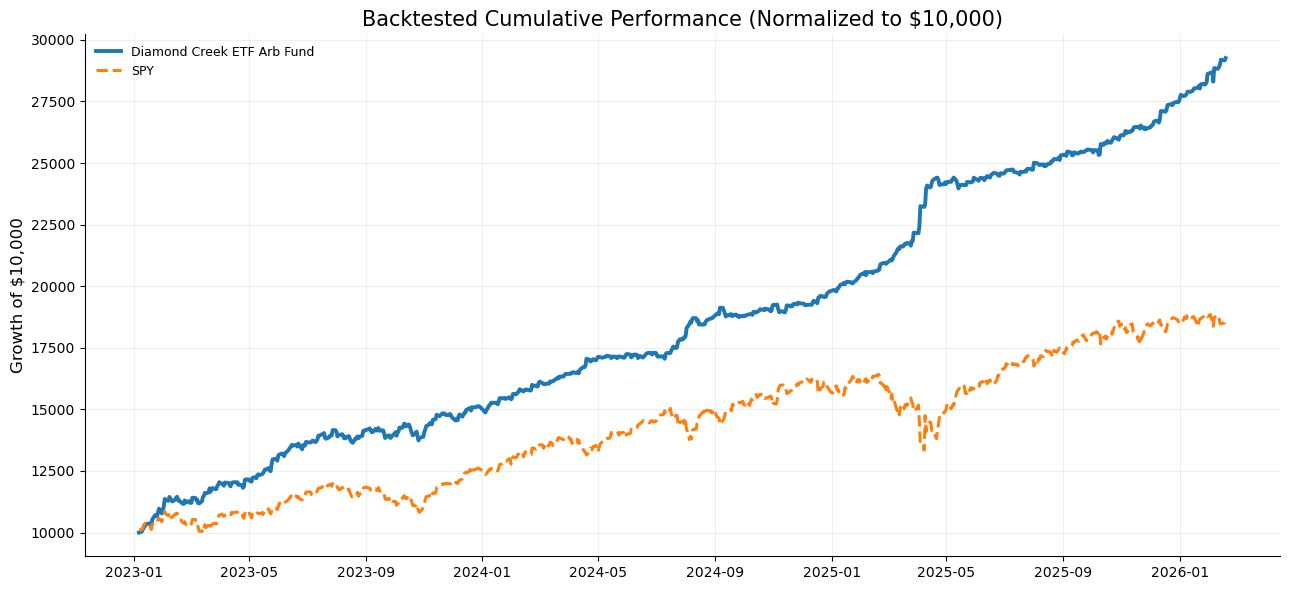

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# -----------------------------
# Perf helpers
# -----------------------------
def max_drawdown_from_curve(curve: pd.Series) -> float:
    dd = curve / curve.cummax() - 1.0
    return float(dd.min())

def sharpe_ratio(ret: pd.Series, rf_annual: float = 0.00) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    rf_daily = (1.0 + rf_annual) ** (1.0 / TRADING_DAYS) - 1.0
    ex = ret - rf_daily
    vol = ex.std(ddof=0)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(ex.mean() / vol * np.sqrt(TRADING_DAYS))

def sortino_ratio(ret: pd.Series, rf_annual: float = 0.00, mar_annual: float | None = None) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan

    mar_annual = rf_annual if mar_annual is None else mar_annual
    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0

    downside = (ret - mar_daily).clip(upper=0.0)
    downside_dev = np.sqrt((downside ** 2).mean())
    if downside_dev == 0 or np.isnan(downside_dev):
        return np.nan

    excess_mean_daily = (ret - mar_daily).mean()
    return float(excess_mean_daily / downside_dev * np.sqrt(TRADING_DAYS))

def perf_from_returns(ret: pd.Series, label: str, rf_annual: float = 0.00) -> dict:
    ret = ret.dropna()
    if ret.empty:
        return {
            "Series": label, "Start": None, "End": None,
            "AnnReturn": np.nan, "AnnVol": np.nan, "MaxDD": np.nan,
            "Sharpe": np.nan, "Sortino": np.nan
        }

    curve = (1.0 + ret).cumprod()
    T = len(ret)

    ann_return = float(curve.iloc[-1] ** (TRADING_DAYS / T) - 1.0)
    ann_vol = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    mdd = max_drawdown_from_curve(curve)

    sh = sharpe_ratio(ret, rf_annual=rf_annual)
    so = sortino_ratio(ret, rf_annual=rf_annual)

    return {
        "Series": label,
        "Start": ret.index.min().date(),
        "End": ret.index.max().date(),
        "AnnReturn": ann_return,
        "AnnVol": ann_vol,
        "MaxDD": mdd,
        "Sharpe": sh,
        "Sortino": so,
    }

# -----------------------------
# Pick best row for a given gross from the NEW grid output
# all_results is the return of run_grid_test_screen_pass (list of res_dfs)
# Each res_df has columns like: TargetGross, Rebal_freq, CAGR, ...
# -----------------------------
def best_row_for_gross(all_results, target_gross: float, tol: float = 1e-9) -> pd.Series:
    rows = []
    for res_df in all_results:
        if res_df is None or res_df.empty:
            continue
        if "TargetGross" not in res_df.columns:
            continue
        df = res_df.copy()
        tg = pd.to_numeric(df["TargetGross"], errors="coerce")
        df = df.assign(_tg=tg).dropna(subset=["_tg", "CAGR"])
        m = np.isclose(df["_tg"].values, float(target_gross), atol=tol, rtol=0)
        if m.any():
            rows.append(df.loc[m].sort_values("CAGR", ascending=False).iloc[0])

    if rows:
        return pd.DataFrame(rows).sort_values("CAGR", ascending=False).iloc[0]

    # fallback: closest gross
    big = []
    for res_df in all_results:
        if res_df is None or res_df.empty or "TargetGross" not in res_df.columns:
            continue
        df = res_df.copy()
        df["_tg"] = pd.to_numeric(df["TargetGross"], errors="coerce")
        df = df.dropna(subset=["_tg", "CAGR"])
        big.append(df)
    if not big:
        raise ValueError("all_results has no usable TargetGross/CAGR rows.")

    big = pd.concat(big, ignore_index=True)
    big["dist"] = (big["_tg"] - float(target_gross)).abs()
    best = big.sort_values(["dist", "CAGR"], ascending=[True, False]).iloc[0]
    print(f"WARNING: TargetGross={target_gross} not found in grid; using closest gross={best['_tg']}.")
    return best

# -----------------------------
# Run one configuration using the NEW single-universe simulator
# Requires the functions you pasted earlier:
#   - build_pairs_and_beta_map_from_screen
#   - make_borrow_daily_map_from_screen
#   - simulate_sleeve_fixed_shares_rebalanced_to_gross_using_beta
# -----------------------------
def run_one_config_screen_pass(
    *,
    prices_bt: pd.DataFrame,
    screen_pass: pd.DataFrame,
    all_results,
    target_gross: float,
    label: str,
    rf_annual: float = 0.00,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
    min_abs_beta: float = 0.50,
):
    # choose best rebalance freq for this gross from the grid
    best = best_row_for_gross(all_results, target_gross=float(target_gross))
    best_freq = str(best.get("Rebal_freq", "M"))

    # universe + beta map
    pairs, beta_map = build_pairs_and_beta_map_from_screen(
        screen_pass,
        beta_col="Beta",
        min_abs_beta=float(min_abs_beta),
    )
    if len(pairs) == 0:
        raise ValueError("screen_pass produced 0 usable (Underlying, ETF) pairs.")

    # borrow map (daily)
    borrow_daily_map = make_borrow_daily_map_from_screen(
        screen_pass,
        etf_col="ETF",
        borrow_net_annual_col="borrow_net_annual",
        default_borrow_annual=DEFAULT_BORROW_ANNUAL,
        trading_days=TRADING_DAYS,
    )

    # run sim
    port_ret, pair_count, diag = simulate_sleeve_fixed_shares_rebalanced_to_gross_using_beta(
        prices_bt,
        pairs=pairs,
        beta_map=beta_map,
        borrow_daily_map=borrow_daily_map,
        freq=best_freq,
        target_gross_mult=float(target_gross),
        initial_equity=1.0,
        margin_annual=float(margin_annual),
        margin_daycount=int(margin_daycount),
        clamp_beta_min_abs=float(min_abs_beta),
    )

    # $10k curve
    curve = (1.0 + port_ret.dropna()).cumprod()
    curve_10k = 10_000.0 * (curve / curve.iloc[0])

    # stats
    stats = perf_from_returns(port_ret, label, rf_annual=rf_annual)
    stats["TargetGross"] = float(target_gross)
    stats["Rebal_freq"] = best_freq

    # financing diagnostics (per $1 initial equity)
    if diag is not None and not diag.empty and "Equity" in diag.columns:
        stats["NetLong_xEq_mean"] = float((diag["NetLong_prev"] / diag["Equity"]).dropna().mean())
        stats["Debit_xEq_mean"] = float((diag["Debit_prev"] / diag["Equity"]).dropna().mean())
        stats["MarginInterest_total"] = float(diag["MarginInterest"].dropna().sum())
        stats["BorrowCost_total"] = float(diag["BorrowCost"].dropna().sum())
    else:
        stats["NetLong_xEq_mean"] = np.nan
        stats["Debit_xEq_mean"] = np.nan
        stats["MarginInterest_total"] = np.nan
        stats["BorrowCost_total"] = np.nan

    return port_ret, curve_10k, stats, diag

# ============================================================
# MAIN (NEW)
# Assumes you already ran:
#   all_results, best_df = run_grid_test_screen_pass(...)
# and you have:
#   prices (TR prices with {TICKER}_TR cols) and screen_pass
# and a get_total_return_series("SPY") helper
# ============================================================
START = pd.Timestamp("2023-01-01")
RF_ANNUAL = 0.00  # set to 0.04 if you want

prices_bt = prices.loc[prices.index >= START].copy()

def _to_naive_utc_index_any(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    idx = pd.to_datetime(idx)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    return idx

def _normalize_to_date_index(s: pd.Series) -> pd.Series:
    s = s.copy()
    s.index = pd.to_datetime(s.index).tz_localize(None).normalize()
    return s

# --- Normalize SPY to date index ---
spy_px = get_total_return_series("SPY")
spy_px = _normalize_to_date_index(spy_px)
spy_px = spy_px.loc[START:].dropna()
spy_ret = spy_px.pct_change().dropna()
spy_curve = (1.0 + spy_ret).cumprod()
spy_curve_10k = 10_000.0 * (spy_curve / spy_curve.iloc[0])


# Desired configurations: (gross, label)
configs = [
    (6.0, "Diamond Creek ETF Arb Fund"),
]

results = []
curves = {}
diag_store = {}

for gross, label in configs:
    port_ret, curve_10k, stats, diag = run_one_config_screen_pass(
        prices_bt=prices_bt,
        screen_pass=screen_pass,
        all_results=all_results,         # <-- from run_grid_test_screen_pass
        target_gross=float(gross),
        label=label,
        rf_annual=RF_ANNUAL,
        margin_annual=MARGIN_ANNUAL,
        margin_daycount=MARGIN_DAYCOUNT,
        min_abs_beta=1.50,
    )
    results.append(stats)
    curves[label] = curve_10k
    diag_store[label] = diag

# --- Normalize strategy curves to date index ---
curves = {k: _normalize_to_date_index(v) for k, v in curves.items()}

# Align SPY + strategy to common index
common_idx = spy_ret.index
for s in curves.values():
    common_idx = common_idx.intersection(s.index)

spy_ret_aligned = spy_ret.loc[common_idx]
spy_stats = perf_from_returns(spy_ret_aligned, "SPY", rf_annual=RF_ANNUAL)
spy_stats["TargetGross"] = np.nan
spy_stats["Rebal_freq"] = ""
spy_stats["NetLong_xEq_mean"] = np.nan
spy_stats["Debit_xEq_mean"] = np.nan
spy_stats["MarginInterest_total"] = np.nan
spy_stats["BorrowCost_total"] = np.nan
results.append(spy_stats)

# -----------------------------
# Summary table
# -----------------------------
stats_df = pd.DataFrame(results)

cols = [
    "Series", "Start", "End",
    "TargetGross", "Rebal_freq",
    "AnnReturn", "AnnVol", "MaxDD", "Sharpe", "Sortino",
    "NetLong_xEq_mean", "Debit_xEq_mean", "MarginInterest_total", "BorrowCost_total",
]
stats_df = stats_df[cols]

fmt = stats_df.copy()
for c in ["AnnReturn", "AnnVol", "MaxDD"]:
    fmt[c] = (fmt[c] * 100).map(lambda x: f"{x:,.1f}%" if pd.notna(x) else "")
for c in ["Sharpe", "Sortino"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
for c in ["TargetGross", "NetLong_xEq_mean", "Debit_xEq_mean"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
for c in ["MarginInterest_total", "BorrowCost_total"]:
    fmt[c] = (fmt[c] * 100).map(lambda x: f"{x:,.1f}%" if pd.notna(x) else "")

print("\n=== Backtest Summary (Aligned daily returns) ===")
print(fmt.to_string(index=False))

# -----------------------------
# Plot all curves normalized to $10,000
# -----------------------------
plt.figure(figsize=(13, 6))

for label, c10k in curves.items():
    c10k_aligned = c10k.loc[common_idx]
    plt.plot(c10k_aligned.index, c10k_aligned.values, linewidth=2.8, label=label)

spy_curve_10k_aligned = spy_curve_10k.loc[common_idx]
plt.plot(
    spy_curve_10k_aligned.index,
    spy_curve_10k_aligned.values,
    linewidth=2.2,
    linestyle="--",
    label="SPY",
)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.20)

plt.title("Backtested Cumulative Performance (Normalized to $10,000)", fontsize=15)
plt.ylabel("Growth of $10,000", fontsize=12)
plt.legend(frameon=False, fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()


DEBUG: common aligned days = 780

=== Backtest Summary (Gross vs Net-to-LPs) ===
                                         Series      Start        End TargetGross Rebal_freq AnnReturn AnnVol  MaxDD Sharpe Sortino
Diamond Creek ETF Arb Fund (Gross of Fund Fees) 2023-01-09 2026-02-19        6.00          W     24.2%   8.0%  -4.8%   2.73    5.11
        Diamond Creek ETF Arb Fund (Net to LPs) 2023-01-09 2026-02-19        6.00          W     18.7%   8.3%  -5.3%   2.10    3.62
                                            SPY 2023-01-09 2026-02-18                            21.8%  15.2% -18.8%   1.37    2.06


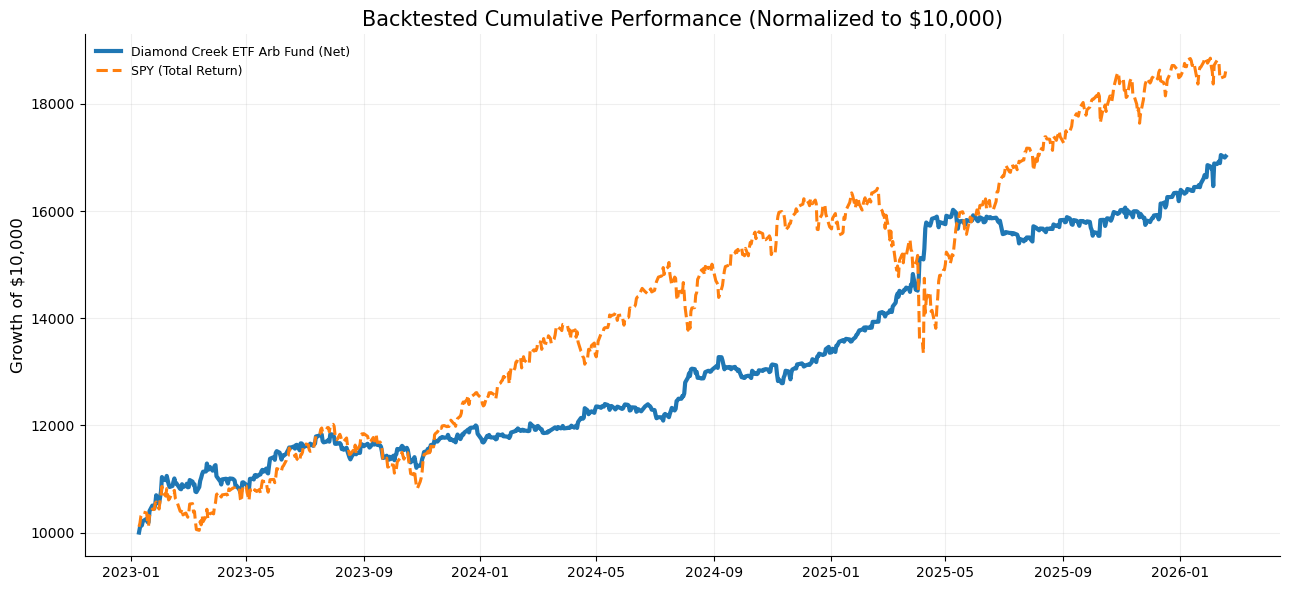

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# ============================================================
# FUND FEE TERMS (LP-LEVEL)
# ============================================================
MGMT_FEE_ANNUAL = 0.02
INCENTIVE_FEE   = 0.20
HURDLE_ANNUAL   = 0.10
CRYSTALLIZE_FREQ = "Q"  # quarterly

HURDLE_Q   = (1.0 + HURDLE_ANNUAL) ** (1.0 / 4.0) - 1.0
MGMT_FEE_Q = MGMT_FEE_ANNUAL / 4.0

# ============================================================
# Index helpers (IMPORTANT)
# ============================================================
def _to_naive_utc_index_any(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    idx = pd.to_datetime(idx)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    return idx

def _normalize_index_to_date(s: pd.Series) -> pd.Series:
    s = s.copy()
    s.index = _to_naive_utc_index_any(pd.DatetimeIndex(s.index)).normalize()
    return s

def _normalize_df_index_to_date(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = _to_naive_utc_index_any(pd.DatetimeIndex(df.index)).normalize()
    return df


# ============================================================
# Perf helpers
# ============================================================
def max_drawdown_from_curve(curve: pd.Series) -> float:
    dd = curve / curve.cummax() - 1.0
    return float(dd.min())

def sharpe_ratio(ret: pd.Series, rf_annual: float = 0.00) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    rf_daily = (1.0 + rf_annual) ** (1.0 / TRADING_DAYS) - 1.0
    ex = ret - rf_daily
    vol = ex.std(ddof=0)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(ex.mean() / vol * np.sqrt(TRADING_DAYS))

def sortino_ratio(ret: pd.Series, rf_annual: float = 0.00, mar_annual: float | None = None) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    mar_annual = rf_annual if mar_annual is None else mar_annual
    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0
    downside = (ret - mar_daily).clip(upper=0.0)
    downside_dev = np.sqrt((downside ** 2).mean())
    if downside_dev == 0 or np.isnan(downside_dev):
        return np.nan
    excess_mean_daily = (ret - mar_daily).mean()
    return float(excess_mean_daily / downside_dev * np.sqrt(TRADING_DAYS))

def perf_from_returns(ret: pd.Series, label: str, rf_annual: float = 0.00) -> dict:
    ret = ret.dropna()
    if ret.empty:
        return {
            "Series": label, "Start": None, "End": None,
            "AnnReturn": np.nan, "AnnVol": np.nan, "MaxDD": np.nan,
            "Sharpe": np.nan, "Sortino": np.nan
        }
    curve = (1.0 + ret).cumprod()
    T = len(ret)
    ann_return = float(curve.iloc[-1] ** (TRADING_DAYS / T) - 1.0)
    ann_vol = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    mdd = max_drawdown_from_curve(curve)
    sh = sharpe_ratio(ret, rf_annual=rf_annual)
    so = sortino_ratio(ret, rf_annual=rf_annual)
    return {
        "Series": label,
        "Start": ret.index.min().date(),
        "End": ret.index.max().date(),
        "AnnReturn": ann_return,
        "AnnVol": ann_vol,
        "MaxDD": mdd,
        "Sharpe": sh,
        "Sortino": so,
    }


# ============================================================
# LP fee wrapper (quarterly mgmt + quarterly incentive, HWM + hurdle)
# ============================================================
def apply_lp_fees_quarterly(
    gross_daily_ret: pd.Series,
    mgmt_fee_q: float = MGMT_FEE_Q,
    incentive_fee: float = INCENTIVE_FEE,
    hurdle_q: float = HURDLE_Q,
    crystallize_freq: str = "Q",
) -> tuple[pd.Series, pd.DataFrame]:
    r = gross_daily_ret.replace([np.inf, -np.inf], np.nan).dropna().copy()
    if r.empty:
        return r, pd.DataFrame()

    r = _normalize_index_to_date(r)
    idx = pd.DatetimeIndex(r.index)

    nav = 1.0
    hwm = 1.0
    nav_series = pd.Series(index=idx, dtype=float)

    fee_rows = []

    periods = idx.to_period(crystallize_freq)
    q_ends = (
        pd.Series(idx, index=idx)
        .groupby(periods)
        .max()
        .sort_values()
        .to_list()
    )
    q_ends = set(pd.to_datetime(q_ends))

    q_start_nav = nav

    for t in idx:
        nav *= (1.0 + float(r.loc[t]))
        nav_series.loc[t] = nav

        if t in q_ends:
            nav_pre_fees = nav

            # Mgmt fee on NAV
            mgmt_fee_amt = mgmt_fee_q * nav_pre_fees
            nav_after_mgmt = nav_pre_fees - mgmt_fee_amt

            # Hurdle for the quarter (pref return)
            hurdle_nav = q_start_nav * (1.0 + hurdle_q)

            perf_fee_amt = 0.0
            if nav_after_mgmt > hwm and nav_after_mgmt > hurdle_nav:
                profit_over_hurdle = nav_after_mgmt - hurdle_nav
                perf_fee_amt = incentive_fee * profit_over_hurdle
                nav_after_perf = nav_after_mgmt - perf_fee_amt
                nav = nav_after_perf
                hwm = max(hwm, nav_after_perf)
            else:
                nav = nav_after_mgmt
                hwm = max(hwm, nav_after_mgmt)

            q_ret_gross = (nav_pre_fees / q_start_nav) - 1.0
            q_ret_net   = (nav / q_start_nav) - 1.0

            fee_rows.append({
                "QuarterEnd": t,
                "StartNAV": q_start_nav,
                "EndNAV_preFees": nav_pre_fees,
                "MgmtFee_amt": mgmt_fee_amt,
                "EndNAV_postMgmt": nav_after_mgmt,
                "HurdleNAV": hurdle_nav,
                "PerfFee_amt": perf_fee_amt,
                "EndNAV_postFees": nav,
                "HWM_postFees": hwm,
                "QuarterGrossRet": q_ret_gross,
                "QuarterNetRet": q_ret_net,
            })

            q_start_nav = nav
            nav_series.loc[t] = nav

    nav_series = nav_series.dropna()
    net_daily_ret = nav_series.pct_change().dropna()
    net_daily_ret.name = "LP_NetRet"

    fee_diag = pd.DataFrame(fee_rows)
    if not fee_diag.empty:
        fee_diag["QuarterEnd"] = pd.to_datetime(fee_diag["QuarterEnd"])

    return net_daily_ret, fee_diag


# ============================================================
# Pick best row for a given gross from NEW grid output
# (res_dfs contain: TargetGross, Rebal_freq, CAGR, ...)
# ============================================================
def best_row_for_gross(all_results, target_gross: float, tol: float = 1e-9) -> pd.Series:
    rows = []
    for res_df in all_results:
        if res_df is None or res_df.empty:
            continue
        if "TargetGross" not in res_df.columns:
            continue
        df = res_df.copy()
        df["_tg"] = pd.to_numeric(df["TargetGross"], errors="coerce")
        df = df.dropna(subset=["_tg", "CAGR"])
        m = np.isclose(df["_tg"].values, float(target_gross), atol=tol, rtol=0)
        if m.any():
            rows.append(df.loc[m].sort_values("CAGR", ascending=False).iloc[0])
    if rows:
        return pd.DataFrame(rows).sort_values("CAGR", ascending=False).iloc[0]

    big = []
    for res_df in all_results:
        if res_df is None or res_df.empty or "TargetGross" not in res_df.columns:
            continue
        df = res_df.copy()
        df["_tg"] = pd.to_numeric(df["TargetGross"], errors="coerce")
        df = df.dropna(subset=["_tg", "CAGR"])
        big.append(df)
    if not big:
        raise ValueError("all_results has no usable TargetGross/CAGR rows.")

    big = pd.concat(big, ignore_index=True)
    big["dist"] = (big["_tg"] - float(target_gross)).abs()
    best = big.sort_values(["dist", "CAGR"], ascending=[True, False]).iloc[0]
    print(f"WARNING: TargetGross={target_gross} not found in grid; using closest gross={best['_tg']}.")
    return best


# ============================================================
# RUN ONE CONFIG (screen_df universe) + apply LP fees
# Requires earlier functions you already have:
#   - build_pairs_and_beta_map_from_screen
#   - make_borrow_daily_map_from_screen
#   - simulate_sleeve_fixed_shares_rebalanced_to_gross_using_beta
# plus constants: DEFAULT_BORROW_ANNUAL, MARGIN_ANNUAL, MARGIN_DAYCOUNT
# ============================================================
def run_one_config_screen_df_with_fees(
    *,
    prices_bt: pd.DataFrame,
    screen_df: pd.DataFrame,
    all_results,
    target_gross: float,
    label: str,
    rf_annual: float = 0.00,
    min_abs_beta: float = 0.50,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    best = best_row_for_gross(all_results, target_gross=float(target_gross))
    best_freq = str(best.get("Rebal_freq", "M"))

    pairs, beta_map = build_pairs_and_beta_map_from_screen(
        screen_df,
        beta_col="Beta",
        min_abs_beta=float(min_abs_beta),
    )
    if len(pairs) == 0:
        raise ValueError("screen_df produced 0 usable (Underlying, ETF) pairs.")

    borrow_daily_map = make_borrow_daily_map_from_screen(
        screen_df,
        etf_col="ETF",
        borrow_net_annual_col="borrow_net_annual",
        default_borrow_annual=DEFAULT_BORROW_ANNUAL,
        trading_days=TRADING_DAYS,
    )

    # Gross strategy returns (already net of borrow/margin/trading inside simulator)
    ret_gross, pair_count, diag = simulate_sleeve_fixed_shares_rebalanced_to_gross_using_beta(
        prices_bt,
        pairs=pairs,
        beta_map=beta_map,
        borrow_daily_map=borrow_daily_map,
        freq=best_freq,
        target_gross_mult=float(target_gross),
        initial_equity=1.0,
        margin_annual=float(margin_annual),
        margin_daycount=int(margin_daycount),
        clamp_beta_min_abs=float(min_abs_beta),
    )

    # normalize index to date for robust alignment
    ret_gross = _normalize_index_to_date(ret_gross)

    # Apply LP fees quarterly
    ret_net, fee_diag = apply_lp_fees_quarterly(
        ret_gross,
        mgmt_fee_q=MGMT_FEE_Q,
        incentive_fee=INCENTIVE_FEE,
        hurdle_q=HURDLE_Q,
        crystallize_freq=CRYSTALLIZE_FREQ,
    )

    # Align net/gross (in case fee events remove the first day)
    common = ret_gross.index.intersection(ret_net.index)
    ret_gross = ret_gross.loc[common]
    ret_net   = ret_net.loc[common]

    curve_gross_10k = 10_000.0 * ((1.0 + ret_gross).cumprod() / (1.0 + ret_gross).cumprod().iloc[0])
    curve_net_10k   = 10_000.0 * ((1.0 + ret_net).cumprod()   / (1.0 + ret_net).cumprod().iloc[0])

    stats_gross = perf_from_returns(ret_gross, f"{label} (Gross of Fund Fees)", rf_annual=rf_annual)
    stats_net   = perf_from_returns(ret_net,   f"{label} (Net to LPs)",         rf_annual=rf_annual)

    for st in (stats_gross, stats_net):
        st["TargetGross"] = float(target_gross)
        st["Rebal_freq"]  = best_freq

    return {
        "ret_gross": ret_gross,
        "ret_net": ret_net,
        "curve_gross_10k": curve_gross_10k,
        "curve_net_10k": curve_net_10k,
        "stats_gross": stats_gross,
        "stats_net": stats_net,
        "fee_diag": fee_diag,
        "diag": diag,
    }


# ============================================================
# MAIN
# Assumes you already have:
#   all_results, best_df = run_grid_test_screen_pass(...)
# and variables:
#   prices (TR prices with {TICKER}_TR cols), screen_df (or screen_pass), get_total_return_series
# ============================================================
START = pd.Timestamp("2023-01-01")
RF_ANNUAL = 0.00

prices_bt = _normalize_df_index_to_date(prices)
prices_bt = prices_bt.loc[prices_bt.index >= START].copy()

# SPY total return series
spy_px = get_total_return_series("SPY").copy()
spy_px = _normalize_index_to_date(spy_px)
spy_px = spy_px.loc[START:].dropna()
spy_ret = spy_px.pct_change().dropna()
spy_curve_10k = 10_000.0 * ((1.0 + spy_ret).cumprod() / (1.0 + spy_ret).cumprod().iloc[0])

configs = [
    (6.0, "Diamond Creek ETF Arb Fund"),
]

results = []
curves = {}

for gross, label in configs:
    out = run_one_config_screen_df_with_fees(
        prices_bt=prices_bt,
        screen_df=screen_df,         # <-- USES screen_df
        all_results=all_results,
        target_gross=float(gross),
        label=label,
        rf_annual=RF_ANNUAL,
        min_abs_beta=1.50,
        margin_annual=MARGIN_ANNUAL,
        margin_daycount=MARGIN_DAYCOUNT,
    )

    results.append(out["stats_gross"])
    results.append(out["stats_net"])

    # Plot net (and optionally gross)
    # curves[f"{label} (Gross)"] = _normalize_index_to_date(out["curve_gross_10k"])
    curves[f"{label} (Net)"]   = _normalize_index_to_date(out["curve_net_10k"])

# Align SPY with all curves
common_idx = spy_ret.index
for s in curves.values():
    common_idx = common_idx.intersection(s.index)

print("DEBUG: common aligned days =", len(common_idx))
if len(common_idx) == 0:
    raise RuntimeError("No overlap between SPY and strategy curves after normalization.")

spy_ret_aligned = spy_ret.loc[common_idx]
spy_stats = perf_from_returns(spy_ret_aligned, "SPY", rf_annual=RF_ANNUAL)
spy_stats["TargetGross"] = np.nan
spy_stats["Rebal_freq"] = ""
results.append(spy_stats)

# Summary table
stats_df = pd.DataFrame(results)
cols = [
    "Series", "Start", "End",
    "TargetGross", "Rebal_freq",
    "AnnReturn", "AnnVol", "MaxDD", "Sharpe", "Sortino",
]
stats_df = stats_df[cols]

fmt = stats_df.copy()
for c in ["AnnReturn", "AnnVol", "MaxDD"]:
    fmt[c] = (fmt[c] * 100).map(lambda x: f"{x:,.1f}%" if pd.notna(x) else "")
for c in ["Sharpe", "Sortino"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
for c in ["TargetGross"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")

print("\n=== Backtest Summary (Gross vs Net-to-LPs) ===")
print(fmt.to_string(index=False))

# Plot
plt.figure(figsize=(13, 6))

for label, c10k in curves.items():
    plt.plot(c10k.loc[common_idx].index, c10k.loc[common_idx].values, linewidth=3, label=label)

plt.plot(
    spy_curve_10k.loc[common_idx].index,
    spy_curve_10k.loc[common_idx].values,
    linewidth=2.2,
    linestyle="--",
    label="SPY (Total Return)",
)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.20)

plt.title("Backtested Cumulative Performance (Normalized to $10,000)", fontsize=15)
plt.ylabel("Growth of $10,000", fontsize=12)
plt.legend(frameon=False, fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# ============================================================
# Quarterly returns table (same as before)
# ============================================================

def quarterly_return_table(daily_ret: pd.Series) -> pd.DataFrame:
    r = daily_ret.dropna().copy()
    r.index = pd.to_datetime(r.index)
    r = r.sort_index()

    q_ret = (1.0 + r).resample("Q").prod() - 1.0

    rows = []
    for y in sorted(q_ret.index.year.unique()):
        qy = q_ret[q_ret.index.year == y]
        out = {"Year": y, "Q1": np.nan, "Q2": np.nan, "Q3": np.nan, "Q4": np.nan, "FY / YTD": np.nan}

        for ts, val in qy.items():
            q = pd.Timestamp(ts).quarter
            out[f"Q{q}"] = float(val)

        out["FY / YTD"] = float((1.0 + qy).prod() - 1.0) if len(qy) > 0 else np.nan
        rows.append(out)

    df = pd.DataFrame(rows).set_index("Year")
    return df.loc[df.notna().any(axis=1)]

def format_pct_table(df: pd.DataFrame) -> pd.DataFrame:
    def fmt(x):
        if pd.isna(x):
            return ""
        return f"({abs(x)*100:.1f}%)" if x < 0 else f"{x*100:.1f}%"
    return df.applymap(fmt)


# ============================================================
# FIXED fee model (prevents "fee spill" into next year)
#
# Mechanics:
# 1) Build NAV from gross daily returns
# 2) Apply management fee daily to NAV
# 3) At each calendar YEAR-END date that exists in the series:
#    - compute that year's return (after mgmt)
#    - incentive fee = 20% * max(year_return - 10%, 0)
#    - apply the fee ON THE YEAR-END DATE by scaling NAV from that date forward
#
# Key fix vs your version:
# - The performance fee is realized on the LAST DATE OF THE YEAR in your data,
#   not on the first day of the following year (which was making 2026 look too low).
#
# Optional:
# - crystallize_final_partial_year=False by default (so you don't take a partial-year
#   incentive fee at the end of the backtest).
# ============================================================

def gross_to_net_daily_returns(
    gross_daily_ret: pd.Series,
    mgmt_fee_annual: float = 0.02,
    perf_fee: float = 0.20,
    hurdle_annual: float = 0.10,
    trading_days: int = 252,
    crystallize_final_partial_year: bool = False,
) -> pd.Series:
    r = gross_daily_ret.dropna().copy()
    r.index = pd.to_datetime(r.index)
    r = r.sort_index()

    # 1) Gross NAV
    nav_gross = (1.0 + r).cumprod()

    # 2) Apply management fee daily (simple daily accrual on NAV)
    mgmt_fee_daily = mgmt_fee_annual / trading_days
    mgmt_multiplier = (1.0 - mgmt_fee_daily) ** np.arange(len(nav_gross))
    nav_after_mgmt = nav_gross * mgmt_multiplier
    nav_after_mgmt = nav_after_mgmt.astype(float)

    # 3) Apply incentive fees at year-end dates (scale NAV from year-end forward)
    nav_net = nav_after_mgmt.copy()

    years = sorted(nav_net.index.year.unique())
    for i, y in enumerate(years):
        year_mask = nav_net.index.year == y
        year_idx = nav_net.index[year_mask]
        if len(year_idx) < 2:
            continue

        year_start = year_idx[0]
        year_end = year_idx[-1]

        # If it's the final year and we don't want partial-year crystallization, skip.
        is_final_year = (y == years[-1])
        if is_final_year and (not crystallize_final_partial_year):
            continue

        year_ret = (nav_net.loc[year_end] / nav_net.loc[year_start]) - 1.0
        perf_base = max(year_ret - hurdle_annual, 0.0)
        perf_charge = perf_fee * perf_base  # fraction of year-start NAV

        if perf_charge > 0:
            # Apply the fee ON the year-end date (affects year-end daily return, not next year)
            scale = (1.0 - perf_charge)
            nav_net.loc[year_end:] = nav_net.loc[year_end:] * scale

    # Convert NAV back to daily returns
    net_daily_ret = nav_net.pct_change().dropna()
    return net_daily_ret


# ============================================================
# Build BOTH tables (gross + net)
# Assumes you already have: port_ret (gross daily returns)
# ============================================================

q_table_gross = quarterly_return_table(port_ret)
q_table_gross_fmt = format_pct_table(q_table_gross)

port_ret_net = gross_to_net_daily_returns(
    port_ret,
    mgmt_fee_annual=0.02,
    perf_fee=0.20,
    hurdle_annual=0.10,
    trading_days=252,
    crystallize_final_partial_year=False,  # IMPORTANT: avoids extra fee drag in 2026 YTD
)

q_table_net = quarterly_return_table(port_ret_net)
q_table_net_fmt = format_pct_table(q_table_net)

print("\n=== Quarterly Net Performance (GROSS of fees) ===")
print(q_table_gross_fmt.to_string())

print("\n=== Quarterly Net Performance (NET to LPs, 2/20 w/ 10% hurdle) ===")
print(q_table_net_fmt.to_string())



=== Quarterly Net Performance (GROSS of fees) ===
         Q1     Q2    Q3    Q4 FY / YTD
Year                                   
2023  12.2%  15.2%  1.8%  8.4%    42.7%
2024   7.3%   5.0%  6.0%  5.1%    25.4%
2025   6.5%   9.0%  3.8%  5.3%    26.8%
2026   4.7%                        4.7%

=== Quarterly Net Performance (NET to LPs, 2/20 w/ 10% hurdle) ===
         Q1     Q2    Q3    Q4 FY / YTD
Year                                   
2023  10.5%  14.6%  1.3%  1.7%    30.6%
2024   6.8%   4.4%  5.4%  1.5%    19.3%
2025   6.0%   8.4%  3.2%  1.8%    20.8%
2026   4.5%                        4.5%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression

TRADING_DAYS = 252
BENCH_1 = ["SPY"]
BENCH_4 = ["SPY", "AGG", "HYG", "DBC"]

# ----------------------------
# Helpers: index normalization
# ----------------------------
def _to_date_index(s: pd.Series) -> pd.Series:
    s = s.copy()
    idx = pd.to_datetime(s.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    idx = idx.normalize()
    s.index = idx
    s = s[~s.index.duplicated(keep="last")]
    return s

def load_adjclose_returns(ticker: str, start: str) -> pd.Series:
    df = yf.download(
        ticker, start=start,
        auto_adjust=False, progress=False, threads=False, timeout=30
    )
    if df is None or df.empty:
        return pd.Series(dtype=float, name=ticker)

    col = "Adj Close" if "Adj Close" in df.columns else "Close"
    px = df[col]
    if isinstance(px, pd.DataFrame):
        px = px.iloc[:, 0]
    px = px.dropna().astype(float)
    px.index = pd.to_datetime(px.index).tz_localize(None)

    ret = px.pct_change().dropna()
    ret.name = ticker
    return _to_date_index(ret)

# ----------------------------
# Regression (sklearn)
# ----------------------------
def regress_r2(port_ret: pd.Series, bench: list[str], min_obs: int = 50):
    y = port_ret.replace([np.inf, -np.inf], np.nan).dropna()
    if y.empty:
        raise ValueError("port_ret is empty after dropping NaN/inf.")
    y.name = "PORT"
    y = _to_date_index(y)

    start = str(y.index.min().date())
    X = pd.concat([load_adjclose_returns(t, start=start) for t in bench], axis=1)

    df = pd.concat([y, X], axis=1).dropna()
    if len(df) < min_obs:
        raise ValueError(f"Not enough overlapping observations after alignment: {len(df)}")

    yv = df["PORT"].to_numpy()
    Xv = df[bench].to_numpy()

    lr = LinearRegression(fit_intercept=True)
    lr.fit(Xv, yv)

    r2 = float(lr.score(Xv, yv))
    alpha_daily = float(lr.intercept_)
    betas = pd.Series(lr.coef_, index=bench)

    return {
        "n_obs": int(len(df)),
        "r2": r2,
        "alpha_daily": alpha_daily,
        "alpha_ann": float((1.0 + alpha_daily) ** TRADING_DAYS - 1.0),
        "betas": betas,
    }

# ----------------------------
# Robust "best row for gross" (handles 4 vs 4.0 vs "4x"; falls back to closest)
# ----------------------------
def _coerce_targetgross_to_numeric(s: pd.Series) -> pd.Series:
    if s.dtype == object:
        out = (
            s.astype(str)
             .str.replace("x", "", regex=False)
             .str.strip()
        )
        return pd.to_numeric(out, errors="coerce")
    return pd.to_numeric(s, errors="coerce")

def best_row_for_gross(all_results, target_gross: float, tol: float = 1e-8) -> pd.Series:
    rows = []
    for df in all_results:
        if "TargetGross" not in df.columns:
            continue
        d = df.copy()
        d["_tg"] = _coerce_targetgross_to_numeric(d["TargetGross"])
        d = d.dropna(subset=["_tg", "CAGR"])
        rows.append(d)

    if not rows:
        raise ValueError("all_results has no usable TargetGross/CAGR rows.")

    res_all = pd.concat(rows, ignore_index=True)

    m = np.isclose(res_all["_tg"].to_numpy(), float(target_gross), atol=tol, rtol=0)
    if m.any():
        best = res_all.loc[m].sort_values("CAGR", ascending=False).iloc[0]
        return best

    # fallback: closest gross available
    res_all["dist"] = (res_all["_tg"] - float(target_gross)).abs()
    closest = float(res_all.sort_values(["dist", "CAGR"], ascending=[True, False]).iloc[0]["_tg"])
    best = res_all.loc[res_all["_tg"] == closest].sort_values("CAGR", ascending=False).iloc[0]

    return best

# ----------------------------
# Run a config -> port_ret
# UPDATED for new simulate_hybrid_fixed_shares() return signature (adds diag_cc, diag_lev)
# AND passes margin params through
# ----------------------------
def run_portfolio_returns_for_config(
    prices_bt: pd.DataFrame,
    cc_pairs,
    lev_pairs,
    all_results,
    target_gross: float,
    sleeve_mix: float,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    best = best_row_for_gross(all_results, target_gross=target_gross)
    best_cc = str(best["CC_freq"])
    best_lev = str(best["Lev_freq"])

    borrow_daily_map = make_borrow_daily_map(
        sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    )

    # NEW: simulate_hybrid_fixed_shares returns 7 values now
    port_ret, ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev = simulate_hybrid_fixed_shares(
        prices_bt,
        borrow_daily_map,
        cc_pairs, lev_pairs,
        cc_freq=best_cc,
        lev_freq=best_lev,
        target_gross_mult_sleeve=float(target_gross),
        sleeve_mix=float(sleeve_mix),
        margin_annual=float(margin_annual),
        margin_daycount=int(margin_daycount),
    )

    meta = {
        "TargetGross": float(target_gross),
        "sleeve_mix": float(sleeve_mix),
        "CC_freq": best_cc,
        "Lev_freq": best_lev,
        "grid_CAGR": float(best["CAGR"]),
    }
    return port_ret, meta, diag_cc, diag_lev

# ============================================================
# Run the configs + regressions
# ============================================================
START = pd.Timestamp("2023-01-01")
prices_bt = prices.loc[prices.index >= START].copy()

configs = [
    #(4.0, 0.50, "4.0x gross | 50/50 (CC/Lev)"),
    #(2.5, 0.20, "2.5x gross | 20/80 (CC/Lev)"),
    (4.0, 0.00, "4.0x gross | 0/100 (CC/Lev)"),
]

rows = []

for gross, mix, label in configs:
    port_ret, meta, diag_cc, diag_lev = run_portfolio_returns_for_config(
        prices_bt=prices_bt,
        cc_pairs=cc_pairs,
        lev_pairs=lev_pairs,
        all_results=all_results,
        target_gross=gross,
        sleeve_mix=mix,
        margin_annual=MARGIN_ANNUAL,
        margin_daycount=MARGIN_DAYCOUNT,
    )

    out1 = regress_r2(port_ret, BENCH_1)
    out4 = regress_r2(port_ret, BENCH_4)

    # Optional: include financing diagnostics in the output table (per $1 initial equity)
    # (for mix=0, leveraged sleeve diag is the relevant one)
    diag_use = diag_lev if float(mix) <= 0.0 else diag_cc if float(mix) >= 1.0 else None
    if diag_use is not None and "Equity" in diag_use.columns:
        net_long_mult_mean = float((diag_use["NetLong_prev"] / diag_use["Equity"]).dropna().mean())
        debit_mult_mean = float((diag_use["Debit_prev"] / diag_use["Equity"]).dropna().mean())
        total_margin_interest = float(diag_use["MarginInterest"].dropna().sum())
        total_borrow_cost = float(diag_use["BorrowCost"].dropna().sum())
    else:
        net_long_mult_mean = np.nan
        debit_mult_mean = np.nan
        total_margin_interest = np.nan
        total_borrow_cost = np.nan

    row = {
        "Config": label,
        "TargetGross": meta["TargetGross"],
        "CC_weight": meta["sleeve_mix"],
        "Lev_weight": 1.0 - meta["sleeve_mix"],
        "CC_freq": meta["CC_freq"],
        "Lev_freq": meta["Lev_freq"],
        "n_obs": out1["n_obs"],

        # SPY only
        "R2_SPY": out1["r2"],
        "beta_SPY": float(out1["betas"].loc["SPY"]),
        "alpha_ann_SPY": out1["alpha_ann"],

        # NEW optional:
        "NetLong_xEq_mean": net_long_mult_mean,
        "Debit_xEq_mean": debit_mult_mean,
        "MarginInterest_total": total_margin_interest,
        "BorrowCost_total": total_borrow_cost,
    }
    rows.append(row)

out_df = pd.DataFrame(rows)

# Pretty print
pretty = out_df.copy()
for c in ["R2_SPY"]:
    pretty[c] = pretty[c].map(lambda x: f"{x:.3f}")
for c in ["beta_SPY"]:
    pretty[c] = pretty[c].map(lambda x: f"{x:.3f}")
for c in ["alpha_ann_SPY"]:
    pretty[c] = pretty[c].map(lambda x: f"{x*100:+.2f}%")

for c in ["NetLong_xEq_mean", "Debit_xEq_mean"]:
    pretty[c] = pretty[c].map(lambda x: f"{x:.2f}" if pd.notna(x) else "")
for c in ["MarginInterest_total", "BorrowCost_total"]:
    pretty[c] = pretty[c].map(lambda x: f"{x*100:.1f}%" if pd.notna(x) else "")

print("\n=== R² / Beta Summary ===")
print(pretty[[
    "Config", "TargetGross", "CC_weight", "Lev_weight", "CC_freq", "Lev_freq",
    "n_obs",
    "R2_SPY", "beta_SPY", "alpha_ann_SPY",
    "NetLong_xEq_mean", "Debit_xEq_mean", "MarginInterest_total", "BorrowCost_total",
]].to_string(index=False))



=== R² / Beta Summary ===
                     Config  TargetGross  CC_weight  Lev_weight CC_freq Lev_freq  n_obs R2_SPY beta_SPY alpha_ann_SPY NetLong_xEq_mean Debit_xEq_mean MarginInterest_total BorrowCost_total
4.0x gross | 0/100 (CC/Lev)          4.0        0.0         1.0       M        W    756  0.136    0.206       +28.12%             1.33           0.33                 5.7%            26.8%


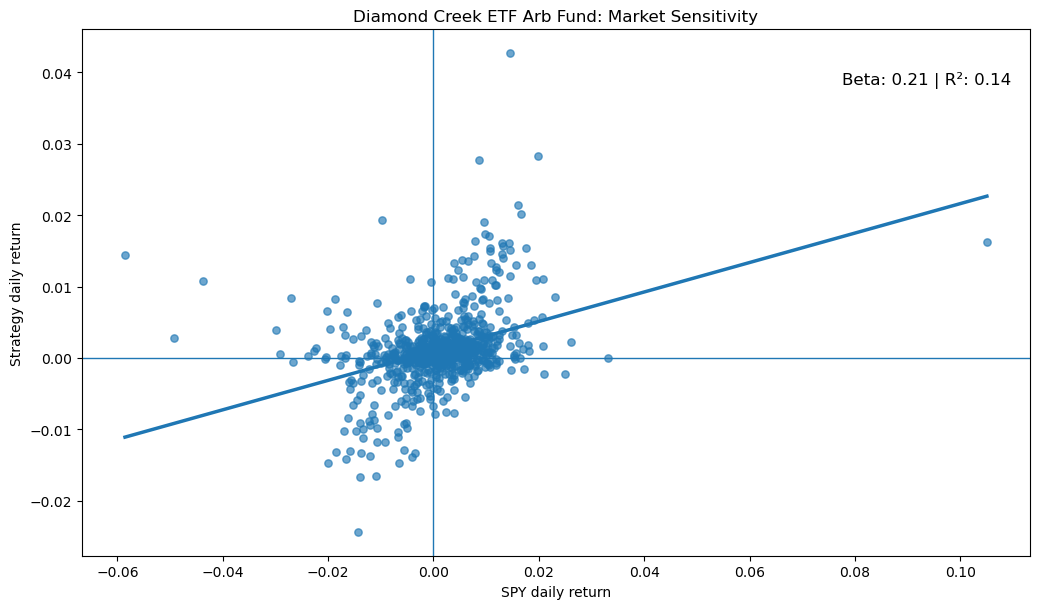

{'beta': 0.2063277395275817, 'r2': 0.1361817998913677, 'n_obs': 756}


In [99]:
# ============================================
# Scatter: Strategy daily returns vs SPY daily returns
# + regression line
# + show Beta and R^2 on chart
# (matches the style of your example image)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

TRADING_DAYS = 252

def plot_spy_scatter_with_beta_r2(port_ret: pd.Series, start: str | None = None, title: str = "Diamond Creek ETF Arb Fund: Market Sensitivity"):
    """
    port_ret: daily strategy returns (pd.Series indexed by date)
    start: optional YYYY-MM-DD to trim the plot/regression window
    """
    # --- load SPY daily returns aligned to port_ret dates (uses your helper)
    y = port_ret.replace([np.inf, -np.inf], np.nan).dropna()
    if start is not None:
        y = y.loc[pd.Timestamp(start):]
    y = _to_date_index(y)

    spy = load_adjclose_returns("SPY", start=str(y.index.min().date()))
    spy = _to_date_index(spy)

    df = pd.concat([spy.rename("SPY"), y.rename("STRAT")], axis=1).dropna()
    if len(df) < 50:
        raise ValueError(f"Not enough overlapping observations: {len(df)}")

    X = df[["SPY"]].to_numpy()
    Y = df["STRAT"].to_numpy()

    lr = LinearRegression(fit_intercept=True)
    lr.fit(X, Y)

    beta = float(lr.coef_[0])
    r2 = float(lr.score(X, Y))

    # --- line for plotting
    x_line = np.linspace(df["SPY"].min(), df["SPY"].max(), 200).reshape(-1, 1)
    y_line = lr.predict(x_line)

    # --- plot (style matches screenshot: points, fit line, crosshairs)
    plt.figure(figsize=(10.5, 6.2))
    plt.scatter(df["SPY"], df["STRAT"], alpha=0.65, s=28)
    plt.plot(x_line.flatten(), y_line, linewidth=2.5)

    plt.axhline(0, linewidth=1)
    plt.axvline(0, linewidth=1)

    plt.title(title)
    plt.xlabel("SPY daily return")
    plt.ylabel("Strategy daily return")

    # place text in upper-right like your image
    plt.text(
        0.98, 0.92,
        f"Beta: {beta:.2f} | R²: {r2:.2f}",
        transform=plt.gca().transAxes,
        ha="right", va="top",
        fontsize=12
    )

    plt.tight_layout()
    plt.show()

    return {"beta": beta, "r2": r2, "n_obs": len(df)}

# ============================================
# Example usage (plug in your port_ret from the loop)
# ============================================
#port_ret, meta, diag_cc, diag_lev = run_portfolio_returns_for_config(...)
stats = plot_spy_scatter_with_beta_r2(port_ret, start="2023-01-01",
                                     title="Diamond Creek ETF Arb Fund: Market Sensitivity")
print(stats)


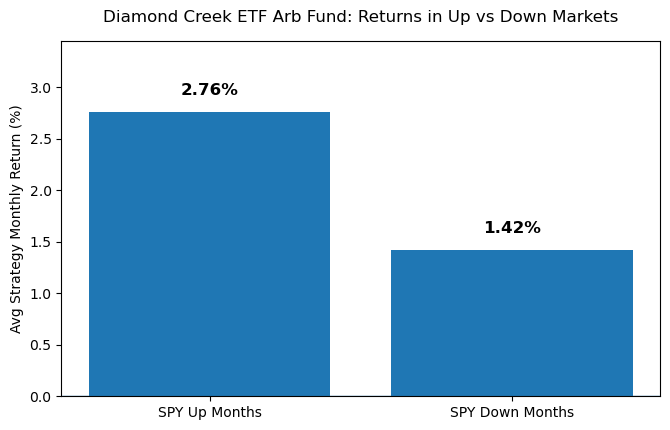

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_up_down_markets(
    port_ret: pd.Series,
    spy_ret: pd.Series,
    title: str = "Diamond Creek ETF Arb Fund: Returns in Up vs Down Markets",
    savepath: str | None = None,
):
    port_ret = port_ret.replace([np.inf, -np.inf], np.nan).dropna()
    spy_ret  = spy_ret.replace([np.inf, -np.inf], np.nan).dropna()

    port_ret.index = pd.to_datetime(port_ret.index).tz_localize(None)
    spy_ret.index  = pd.to_datetime(spy_ret.index).tz_localize(None)

    df = pd.concat([port_ret.rename("PORT"), spy_ret.rename("SPY")], axis=1).dropna()

    m = (1.0 + df).resample("M").prod() - 1.0
    m = m.dropna()

    up_mask = m["SPY"] > 0
    down_mask = m["SPY"] <= 0

    avg_up = m.loc[up_mask, "PORT"].mean() * 100
    avg_down = m.loc[down_mask, "PORT"].mean() * 100

    counts = [int(up_mask.sum()), int(down_mask.sum())]
    labels = ["SPY Up Months", "SPY Down Months"]
    values = [avg_up, avg_down]

    # --- plot ---
    fig, ax = plt.subplots(figsize=(6.8, 4.4))
    bars = ax.bar(labels, values)

    ax.set_title(title, pad=14)  # move title up a bit
    ax.set_ylabel("Avg Strategy Monthly Return (%)")
    ax.axhline(0, linewidth=1)
    ax.grid(False)

    # --- reserve headroom so labels NEVER hit the title ---
    vmax = max(values) if len(values) else 0
    ax.set_ylim(0, vmax * 1.25)  # <-- the key fix (25% headroom)

    # offsets as a fraction of y-range (scales nicely)
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    off_pct = 0.04 * yr   # percent label offset
    off_n   = 0.015 * yr  # n label offset

    for bar, val, n in zip(bars, values, counts):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()

        ax.text(
            x, y + off_pct,
            f"{val:.2f}%",
            ha="center", va="bottom",
            fontsize=12, fontweight="semibold"
        )


    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()


spy_ret = load_adjclose_returns(
    "SPY",
    start=str(port_ret.index.min().date())
)

plot_up_down_markets(
    port_ret,
    spy_ret,
    savepath="returns_up_vs_down.png"
)


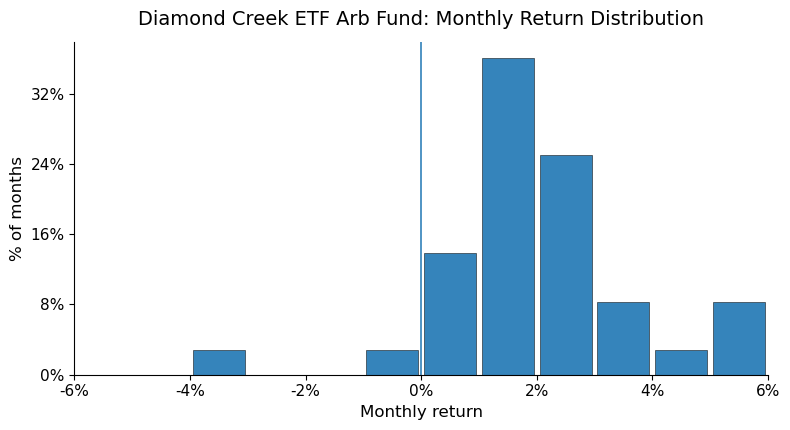

{'n_months': 38, 'mean_monthly': 0.023257675904041396, 'median_monthly': 0.019278238539153114, 'pct_positive_months': 0.9473684210526315, 'worst_month': -0.031427377436092474, 'best_month': 0.09115331050986186}


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

def plot_monthly_return_distribution_clean(
    port_ret_daily: pd.Series,
    title: str = "Diamond Creek ETF Arb Fund: Monthly Return Distribution",
    bin_width: float = 0.01,        # 1% buckets
    xlim: float = 0.06,             # show +/-6% only (clean & concise)
    show_mean: bool = False,
    savepath: str | None = None,
):
    # --- clean daily returns ---
    r = port_ret_daily.replace([np.inf, -np.inf], np.nan).dropna()
    r.index = pd.to_datetime(r.index).tz_localize(None)

    # --- monthly compounded returns ---
    monthly = (1.0 + r).resample("M").prod() - 1.0
    monthly = monthly.dropna()

    # --- clip ONLY for display ---
    monthly_plot = monthly[np.abs(monthly) <= xlim]

    # --- bins ---
    bins = np.arange(-xlim, xlim + bin_width, bin_width)
    counts, edges = np.histogram(monthly_plot, bins=bins)
    pct = counts / counts.sum() * 100
    centers = 0.5 * (edges[:-1] + edges[1:])

    # --- formatters ---
    pct_fmt = FuncFormatter(lambda y, _: f"{y:.0f}%")
    ret_fmt = FuncFormatter(lambda x, _: f"{100*x:.0f}%")

    # --- plot ---
    fig, ax = plt.subplots(figsize=(8.0, 4.4))

    ax.bar(
        centers,
        pct,
        width=bin_width * 0.9,
        edgecolor="black",
        linewidth=0.4,
        alpha=0.9
    )

    # zero line
    ax.axvline(0, linewidth=1.1)

    # optional mean
    if show_mean:
        ax.axvline(monthly.mean(), linestyle="--", linewidth=1)

    # labels
    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xlabel("Monthly return", fontsize=12)
    ax.set_ylabel("% of months", fontsize=12)

    # axis formatting
    ax.set_xlim(-xlim, xlim)
    ax.xaxis.set_major_formatter(ret_fmt)
    ax.yaxis.set_major_formatter(pct_fmt)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax.tick_params(axis="both", labelsize=11)

    # clean frame
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)

    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()

    return {
        "n_months": int(len(monthly)),
        "mean_monthly": float(monthly.mean()),
        "median_monthly": float(monthly.median()),
        "pct_positive_months": float((monthly > 0).mean()),
        "worst_month": float(monthly.min()),
        "best_month": float(monthly.max()),
    }

stats = plot_monthly_return_distribution_clean(
    port_ret,
    bin_width=0.01,   # 1% buckets
    xlim=0.06,        # +/-6% keeps it tight and honest
    savepath="monthly_return_distribution.png"
)
print(stats)


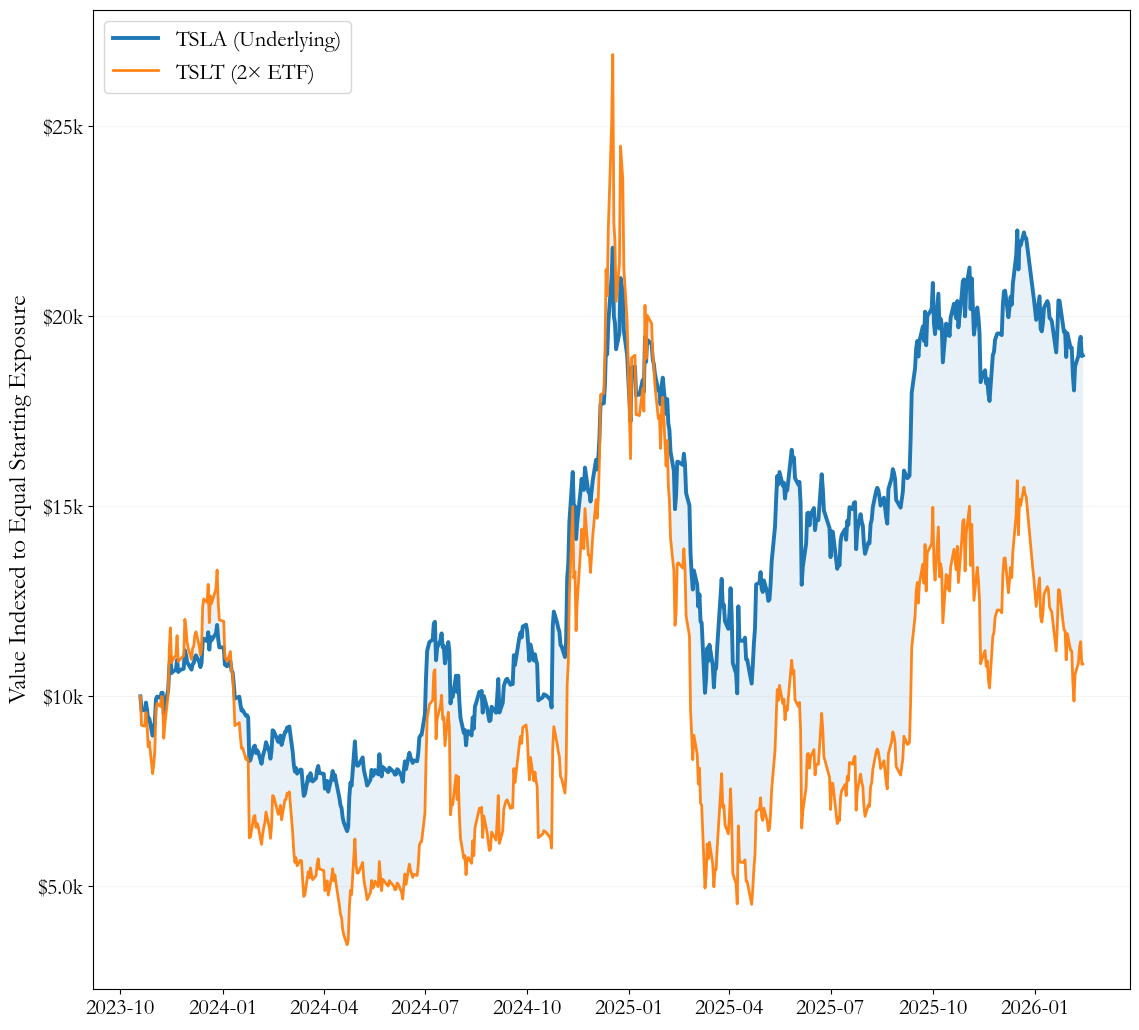

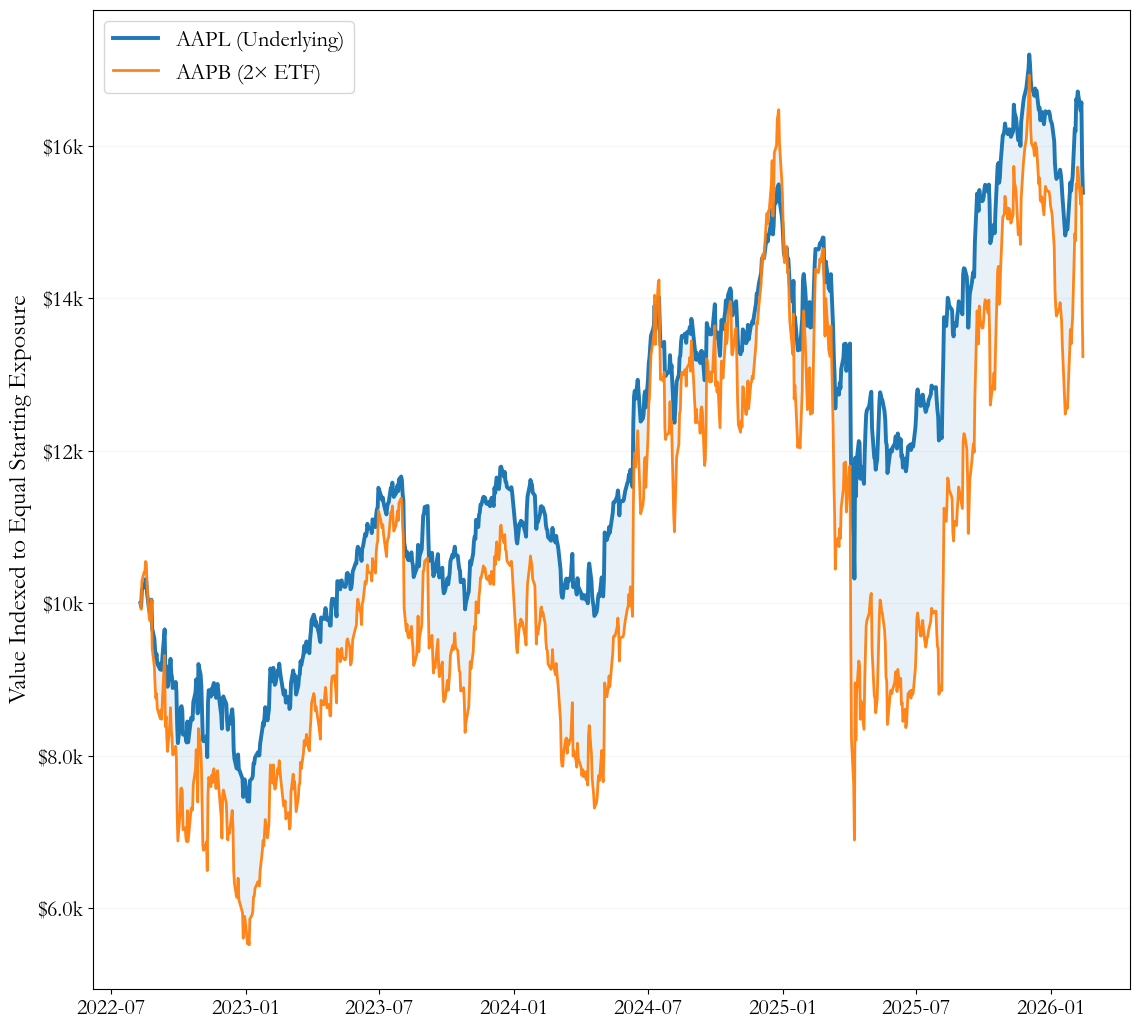

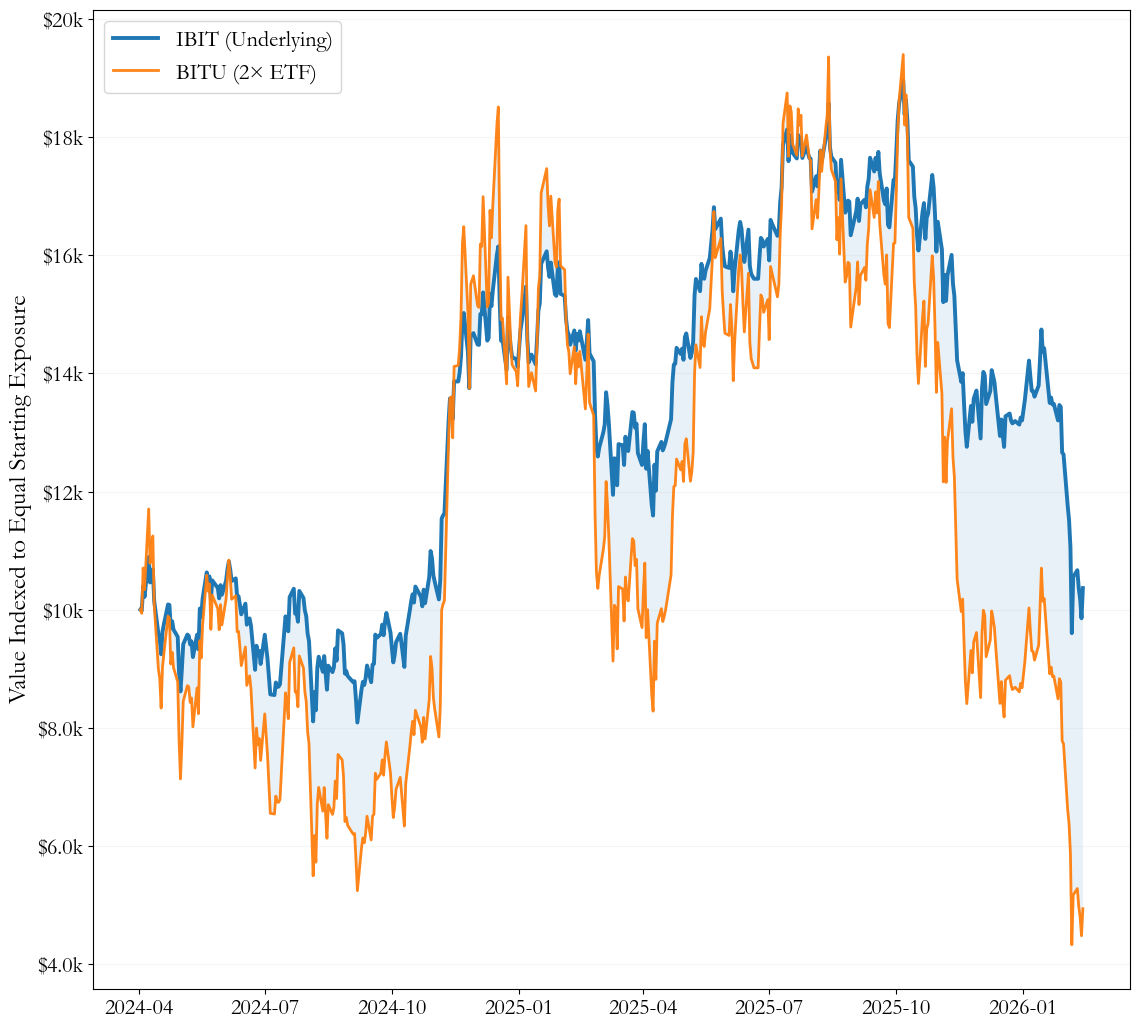

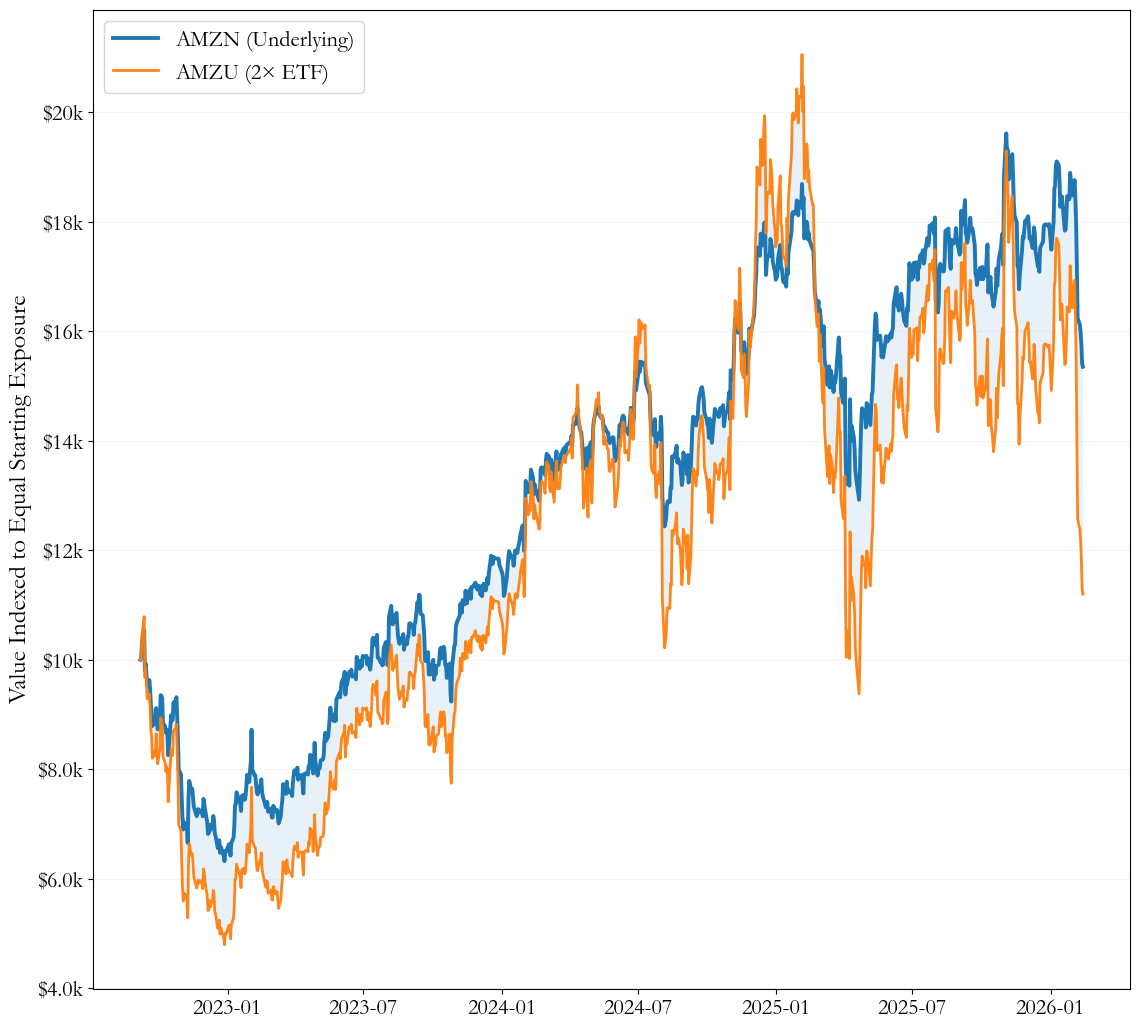

        pair      start        end  end_under_$10k  end_lev_$10k  end_diff_$  max_diff_$   min_diff_$
TSLA vs TSLT 2023-10-19 2026-02-13    18965.062981  10852.562300 8112.500681 8171.122555 -5081.173030
AAPL vs AAPB 2022-08-10 2026-02-13    15381.280601  13233.362621 2147.917980 3427.255159  -978.456093
IBIT vs BITU 2024-04-02 2026-02-13    10364.362447   4933.191973 5431.170474 5431.170474 -2362.690576
AMZN vs AMZU 2022-09-07 2026-02-13    15352.950251  11197.987310 4154.962941 4154.962941 -2364.854342


In [301]:
# LP-READY CHART (SINGLE AXIS): Growth of $10,000 with shaded divergence
# - One axis only (no dollar gap axis)
# - Underlying emphasized, ETF de-emphasized
# - Shaded area between lines shows divergence intuitively
# - Minimal grid, simple legend, no title/footnote by default

import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl

# Set global font to Garamond
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Garamond"]
mpl.rcParams["axes.unicode_minus"] = False

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def fetch_adj_close(tickers, start="2020-01-01", end=None) -> pd.DataFrame:
    px = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=False,
        progress=False,
        threads=True,
        group_by="ticker",
    )

    if isinstance(tickers, str) or len(tickers) == 1:
        t = tickers if isinstance(tickers, str) else tickers[0]
        if "Adj Close" not in px.columns:
            raise ValueError(f"No 'Adj Close' for {t}.")
        return px[["Adj Close"]].rename(columns={"Adj Close": t})

    if "Adj Close" in px.columns.get_level_values(0):
        out = px["Adj Close"].copy()
    elif "Adj Close" in px.columns.get_level_values(-1):
        out = px.xs("Adj Close", axis=1, level=-1)
    else:
        raise ValueError("Could not find 'Adj Close' in downloaded data.")
    return out


def _dollar_formatter(x, pos):
    # compact dollar formatter (k for thousands)
    sign = "-" if x < 0 else ""
    x = abs(x)
    if x >= 1_000_000:
        return f"{sign}${x/1_000_000:.1f}m"
    if x >= 1000:
        return f"{sign}${x/1000:.0f}k" if x >= 10000 else f"{sign}${x/1000:.1f}k"
    return f"{sign}${x:.0f}"


def plot_lp_ready_single_axis(
    under: str,
    lev: str,
    start="2020-01-01",
    end=None,
    initial_investment=10_000,
    under_label=None,
    lev_label=None,
    shade_alpha=0.10,
    show_title=False,
):
    under_label = under_label or f"{under} (Underlying)"
    lev_label   = lev_label   or f"{lev} (2× ETF)"

    adj = fetch_adj_close([under, lev], start=start, end=end)[[under, lev]].dropna()
    if len(adj) < 30:
        print(f"[WARN] Not enough overlap data for {under} vs {lev}.")
        return None

    under_val = initial_investment * (adj[under] / adj[under].iloc[0])
    lev_val   = initial_investment * (adj[lev]   / adj[lev].iloc[0])

    fig, ax = plt.subplots(figsize=(11.5, 10.4))

    # Minimal grid
    ax.grid(axis="y", alpha=0.12)
    ax.grid(axis="x", alpha=0.0)

    # Lines
    ax.plot(under_val.index, under_val.values, linewidth=2.8, label=under_label)
    ax.plot(lev_val.index,   lev_val.values,   linewidth=2.0, alpha=0.95, label=lev_label)

    # Shaded divergence
    ax.fill_between(
        under_val.index,
        under_val.values,
        lev_val.values,
        alpha=shade_alpha,
        linewidth=0
    )

    # Axis label (50% bigger)
    ax.set_ylabel(
        "Value Indexed to Equal Starting Exposure",
        fontsize=18  # was ~12 default → ~50% bigger
    )

    # Tick labels (50% bigger)
    ax.tick_params(axis='both', labelsize=16)

    # Dollar formatter
    ax.yaxis.set_major_formatter(FuncFormatter(_dollar_formatter))

    # Legend (50% bigger)
    ax.legend(
        loc="upper left",
        frameon=True,
        fontsize=16
    )

    plt.tight_layout()
    plt.show()


    return {
        "pair": f"{under} vs {lev}",
        "start": str(adj.index[0].date()),
        "end": str(adj.index[-1].date()),
        "end_under_$10k": float(under_val.iloc[-1]),
        "end_lev_$10k": float(lev_val.iloc[-1]),
        "end_diff_$": float((under_val - lev_val).iloc[-1]),
        "max_diff_$": float((under_val - lev_val).max()),
        "min_diff_$": float((under_val - lev_val).min()),
    }


# --- Run set ---
pairs = [
    ("TSLA", "TSLT"),
    ("AAPL", "AAPB"),
    ("IBIT", "BITU"),
    ("AMZN", "AMZU"),
]

summaries = []
for u, l in pairs:
    s = plot_lp_ready_single_axis(u, l, start="2020-01-01", initial_investment=10_000)
    if s:
        summaries.append(s)

if summaries:
    print(pd.DataFrame(summaries).to_string(index=False))


In [ ]:
import re
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

NASDAQ_LISTED_URL = "https://www.nasdaqtrader.com/dynamic/symdir/nasdaqlisted.txt"
OTHER_LISTED_URL  = "https://www.nasdaqtrader.com/dynamic/symdir/otherlisted.txt"

def _read_nasdaq_pipe_file(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, sep="|", dtype=str)
    # last row is a file timestamp; drop it
    df = df[~df.iloc[:, 0].astype(str).str.contains("File Creation Time", na=False)].copy()
    return df

def load_all_us_symbols() -> pd.DataFrame:
    n = _read_nasdaq_pipe_file(NASDAQ_LISTED_URL)
    o = _read_nasdaq_pipe_file(OTHER_LISTED_URL)

    # Normalize columns
    n = n.rename(columns={"Symbol": "ticker", "Security Name": "name", "ETF": "is_etf"})
    o = o.rename(columns={"ACT Symbol": "ticker", "Security Name": "name", "ETF": "is_etf"})

    keep_cols = ["ticker", "name", "is_etf"]
    df = pd.concat([n[keep_cols], o[keep_cols]], ignore_index=True)
    df["ticker"] = df["ticker"].str.strip()
    df["name"]   = df["name"].str.strip()
    df["is_etf"] = df["is_etf"].str.strip()
    df = df.dropna(subset=["ticker", "name", "is_etf"]).drop_duplicates(subset=["ticker"])
    return df

# Conservative name-based filter: you can tighten/loosen this
LEV_PATTERNS = [
    r"\b2x\b", r"\b3x\b", r"\b-2x\b", r"\b-3x\b",
    r"\bull\b", r"\bbear\b",
    r"\bultra\b", r"\bultrapro\b",
    r"\binverse\b", r"\bleveraged\b",
    r"\bdaily\b",
    r"\bshort\b",  # catches "short" ETFs (be careful: can include non-levered)
]

# Exclusions to reduce false positives (optional)
EXCLUDE_PATTERNS = [
    r"\bultra short\b",   # can be duration, not leverage
    r"\bultrashort\b",
    r"\bshort[- ]term\b", # duration
]

def is_leveraged_name(name: str) -> bool:
    s = name.lower()
    if any(re.search(p, s) for p in EXCLUDE_PATTERNS):
        return False
    return any(re.search(p, s) for p in LEV_PATTERNS)

def infer_first_trade_date(ticker: str) -> pd.Timestamp | None:
    try:
        h = yf.download(ticker, period="max", auto_adjust=False, progress=False)
        if h is None or h.empty:
            return None
        return pd.to_datetime(h.index[0]).tz_localize(None)
    except Exception:
        return None

def build_leveraged_universe(max_tickers: int | None = None) -> pd.DataFrame:
    df = load_all_us_symbols()

    # ETFs only
    df = df[df["is_etf"].eq("Y")].copy()

    # Leveraged/inverse by name
    df["is_leveraged_guess"] = df["name"].apply(is_leveraged_name)
    df = df[df["is_leveraged_guess"]].copy()

    # Optional: cap for quick testing
    if max_tickers is not None:
        df = df.head(max_tickers).copy()

    # First-trade date proxy via yfinance
    first_dates = []
    for t in df["ticker"]:
        first_dates.append(infer_first_trade_date(t))

    df["first_price_date"] = first_dates
    df = df.dropna(subset=["first_price_date"]).copy()
    df["first_price_date"] = pd.to_datetime(df["first_price_date"])
    return df

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

def plot_leveraged_count_over_time(df: pd.DataFrame, freq: str = "M"):
    # freq: "M" monthly, "Q" quarterly

    launched = (
        df.assign(period=df["first_price_date"].dt.to_period(freq).dt.to_timestamp())
          .groupby("period")["ticker"].nunique()
          .sort_index()
    )

    outstanding = launched.cumsum()

    fig, ax = plt.subplots(figsize=(11, 4.6))

    # Main line
    ax.plot(
        outstanding.index,
        outstanding.values,
        linewidth=2.8
    )

    # --- Axes labels (clean, PPT-friendly) ---
    ax.set_ylabel("Number of Leveraged & Inverse ETFs", fontsize=11)
    ax.set_xlabel("")

    # --- X-axis formatting (sparse, readable) ---
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)

    # --- Y-axis formatting (integers only) ---
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

    # --- Grid (LP style) ---
    ax.grid(axis="y", alpha=0.18, linewidth=1.0)
    ax.grid(axis="x", alpha=0.0)

    # --- Clean spines ---
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # --- Margins for right-edge breathing room ---
    ax.margins(x=0.03)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        "launched": launched,
        "outstanding": outstanding
    })

# ---- RUN ----
lev = build_leveraged_universe()  # optionally: build_leveraged_universe(max_tickers=300)


: 

: 

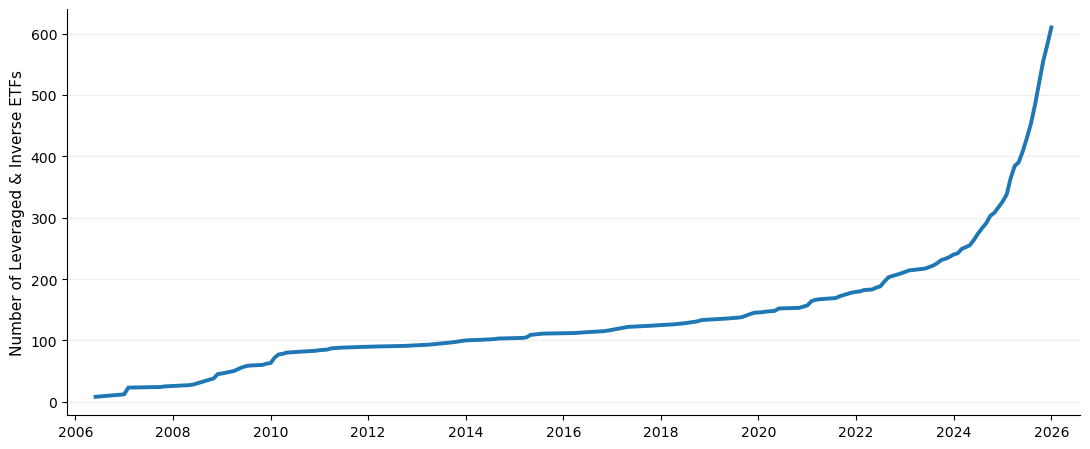

launched  outstanding
period                           
2006-06-01         8            8
2007-01-01         4           12
2007-02-01        11           23
2007-10-01         1           24
2007-11-01         1           25
...              ...          ...
2025-09-01        31          484
2025-10-01        35          519
2025-11-01        36          555
2025-12-01        26          581
2026-01-01        29          610

[117 rows x 2 columns]

: 

: 

In [ ]:
plot_leveraged_count_over_time(lev)

In [ ]:
import re
import time
import random
import pandas as pd
import requests
from bs4 import BeautifulSoup

ETF_CAGR_PATH = "../config/etf_cagr.csv"
OUT_EXPENSE_CSV = "etf_expense_ratios_2x.csv"
OUT_SUMMARY_CSV = "expense_ratio_summary_2x.csv"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; ExpenseRatioBot/1.0; +https://example.com)"
}

def parse_percent_to_float(s: str):
    """
    Convert strings like '0.95%' -> 0.0095
    Return None if cannot parse.
    """
    if not isinstance(s, str):
        return None
    m = re.search(r"([-+]?\d+(\.\d+)?)\s*%", s)
    if not m:
        return None
    return float(m.group(1)) / 100.0

def fetch_etfdb_expense_ratio(ticker: str):
    """
    Scrape expense ratio from ETFdb ETF page:
      https://etfdb.com/etf/{TICKER}/
    Returns (expense_ratio_float, raw_text, url) or (None, None, url) on failure.
    """
    url = f"https://etfdb.com/etf/{ticker}/"
    try:
        r = requests.get(url, headers=HEADERS, timeout=20)
        if r.status_code != 200:
            return None, None, url

        soup = BeautifulSoup(r.text, "html.parser")

        # ETFdb typically shows "Expense Ratio" in the "Vitals" / "Basics" section.
        # We'll find the label text and grab the adjacent value.
        label = soup.find(string=re.compile(r"\bExpense Ratio\b", re.I))
        if not label:
            return None, None, url

        # Walk up to a container row and find the value.
        # This is intentionally a bit flexible to survive minor HTML changes.
        container = label.find_parent()
        # Search nearby for a percent
        text_window = container.get_text(" ", strip=True)
        # Sometimes label container doesn't include value; expand to parent
        if "%" not in text_window:
            parent = container.find_parent()
            if parent:
                text_window = parent.get_text(" ", strip=True)

        # Find first percent in that window
        m = re.search(r"([-+]?\d+(\.\d+)?)\s*%", text_window)
        if not m:
            return None, None, url

        raw = m.group(0)
        val = parse_percent_to_float(raw)
        return val, raw, url

    except Exception:
        return None, None, url

def main():
    etf_cagr = pd.read_csv(ETF_CAGR_PATH)

    # You said: "only read ETFs and corresponding underlyings classified as 2x"
    df_2x = etf_cagr[etf_cagr["LevType"].astype(str).str.lower().eq("2x")].copy()
    tickers = sorted(df_2x["ETF"].astype(str).str.upper().unique())

    rows = []
    for i, tkr in enumerate(tickers, 1):
        val, raw, url = fetch_etfdb_expense_ratio(tkr)

        rows.append({
            "ticker": tkr,
            "expense_ratio": val,          # decimal (e.g. 0.0095)
            "expense_ratio_raw": raw,      # string (e.g. '0.95%')
            "source_url": url,
            "ok": val is not None
        })

        # polite throttle to avoid getting blocked
        time.sleep(0.6 + random.random() * 0.7)

        if i % 25 == 0:
            print(f"Scraped {i}/{len(tickers)}...")

    out = pd.DataFrame(rows)
    out.to_csv(OUT_EXPENSE_CSV, index=False)

    # ----- compute the averages you want -----
    # Long side: corresponding underlyings (stocks) => 0 expense ratio by definition
    # Short side: the 2x ETFs => average of scraped expense ratios
    short_avg = out.loc[out["ok"], "expense_ratio"].mean()

    summary = pd.DataFrame([{
        "n_2x_etfs_total": len(out),
        "n_2x_etfs_with_expense_ratio": int(out["ok"].sum()),
        "avg_expense_ratio_short_2x_etfs": short_avg,
        "avg_expense_ratio_long_underlyings": 0.0,
        "fee_differential_short_minus_long": (short_avg - 0.0) if short_avg is not None else None
    }])
    summary.to_csv(OUT_SUMMARY_CSV, index=False)

    print("\nSaved:")
    print(f" - {OUT_EXPENSE_CSV}")
    print(f" - {OUT_SUMMARY_CSV}")
    print("\nSummary:")
    print(summary.to_string(index=False))

if __name__ == "__main__":
    main()


Scraped 25/236...
Scraped 50/236...
Scraped 75/236...
Scraped 100/236...
Scraped 125/236...
Scraped 150/236...
Scraped 175/236...
Scraped 200/236...
Scraped 225/236...

Saved:
 - etf_expense_ratios_2x.csv
 - expense_ratio_summary_2x.csv

Summary:
 n_2x_etfs_total  n_2x_etfs_with_expense_ratio  avg_expense_ratio_short_2x_etfs  avg_expense_ratio_long_underlyings  fee_differential_short_minus_long
             236                           228                         0.011108                                 0.0                           0.011108


: 

: 

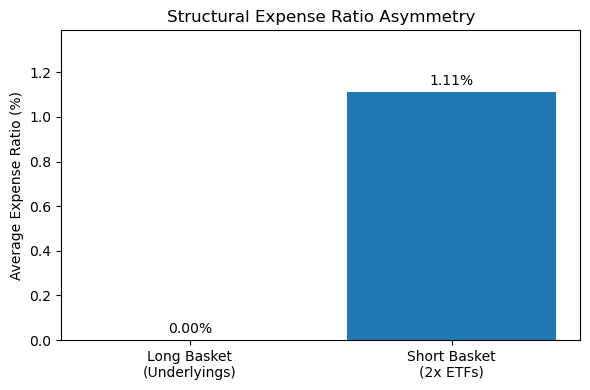

: 

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Load expense ratio data (2x ETFs)
# -------------------------------------------------
df = pd.read_csv("etf_expense_ratios_2x.csv")

# Keep only successfully scraped rows
df = df[df["ok"] == True].copy()

# -------------------------------------------------
# Compute averages
# -------------------------------------------------
short_avg = df["expense_ratio"].mean()      # decimal (e.g. 0.0111)
long_avg = 0.0                              # underlyings assumed 0%

# Convert to percentages for display
values = [long_avg * 100, short_avg * 100]
labels = [
    "Long Basket\n(Underlyings)",
    "Short Basket\n(2x ETFs)"
]

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values)

plt.ylabel("Average Expense Ratio (%)")
plt.title("Structural Expense Ratio Asymmetry")

# Annotate values above bars
for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.2f}%",
        ha="center",
        va="bottom"
    )

# Clean, LP-friendly formatting
plt.ylim(0, max(values) * 1.25)
plt.tight_layout()

plt.show()


: 

: 